<a href="https://colab.research.google.com/github/katha815/ADME-Classifier/blob/main/Different_ML_models_Odata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialization
Feature groups: (1)6 phastCons scores, (2)6 phyloP scores, (3)vepDistance, (4){A-C,A-G,A-T,C-A,...}categorical input, (5)Ensemble search consequence , (6)corresponding SIFT and Polyphen scores, (7) popoulation frequencies.

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
!pip install scikit-optimize
import skopt
from skopt import BayesSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
!pip install numba
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'

find: ‘/proc/59/task/59/net’: Invalid argument
find: ‘/proc/59/net’: Invalid argument
find: ‘/proc/998/task/998/net’: Invalid argument
find: ‘/proc/998/net’: Invalid argument
/usr/local/lib/python3.10/dist-packages/jaxlib/cuda/nvvm/libdevice
/usr/local/cuda-11.8/nvvm/libdevice
find: ‘/proc/59/task/59/net’: Invalid argument
find: ‘/proc/59/net’: Invalid argument
find: ‘/proc/998/task/998/net’: Invalid argument
find: ‘/proc/998/net’: Invalid argument
/usr/local/cuda-11.8/nvvm/lib64/libnvvm.so


In [14]:
import math
from numba import jit, njit, vectorize, cuda, uint32, f8, uint8

In [15]:
base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/"

## Data loading and testing/training split preparation

In [33]:
# Import data
data2 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/Odata_fzero.csv")
# One hot encode with get_dummies
print(f"Whole data: {data2}\n")
Y = data2['Label']
X = data2[[col for col in data2.columns if col!="Location1" and col!="Location2" and
           col!="chr" and col!="Label" and col!="Ref" and col!="Alter"and col!="baseChange"]]
print(X,'\n')
pd.set_option('display.max_rows', None)  # Set the max_rows option to None to show all rows
pd.set_option('display.max_columns', None)  # Set the max_columns option to None to show all columns
print(X.dtypes,'\n')
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
print(Y,'\n')

Whole data:     Chromo  Location1  Location2 Ref Alter  Label  chr  transcript_ablation  \
0     chr1   46930150   46930150   C     T      1    1                    0   
1     chr1   46930161   46930161   G     A      1    1                    0   
2     chr1   46932824   46932824   T     C      1    1                    0   
3     chr1   46932987   46932987   C     T      1    1                    0   
4     chr1   46934207   46934207   A     G      0    1                    0   
..     ...        ...        ...  ..   ...    ...  ...                  ...   
329  chr22   42129836   42129836   C     T      0   22                    0   
330  chr22   42130692   42130692   C     T      1   22                    0   
331  chr22   42130710   42130710   C     T      0   22                    0   
332  chr22   42130715   42130715   G     A      1   22                    0   
333  chr22   42130761   42130761   G     A      1   22                    0   

     splice_acceptor_variant  splice_do

In [34]:
## Prepare leave one chromosome out split indexes
chrom_values = X['Chromo'].unique()
grouped = X.groupby(['Chromo'])

# Initialization
datasplit = []
labels = []
combined_index = [None for _ in range(chrom_values.shape[0])]
testlist = [None for _ in range(chrom_values.shape[0])]
trainlist = [None for _ in range(chrom_values.shape[0])]

# Extract info from grouped data
for n in range(chrom_values.shape[0]):
    chrom_i = chrom_values[n]
    new_data = grouped.get_group(chrom_i)  # Generate random data
    label = f"{chrom_i}"  # Generate label
    datasplit.append(new_data)  # Store data
    labels.append(label)  # Store label
print(type(datasplit[0].index),np.shape(datasplit[0].index))
print(datasplit[0].index.tolist())

# Convert it to chromo label and chromo-splitted testing sets
for i in range(len(labels)):
    print(f"Chromosome: {labels[i]}:")
    # print(f"Iteration: {i+1}\n")
    # print(f"Data_index: {datasplit[i].index}")
    print(f"Data_size: {len(datasplit[i])}")
    testlist[i] = np.array(datasplit[i].index).tolist()
    # print(f"Test size: {len(testlist[i])}\n")
    print(f"Test indexes: {testlist[i]}\n")
    # Label: {labels[i]}\n {type(testlist[i])}\n")

# Always merge the shortest lists, make sure the minimum length<20
while min(map(len, testlist)) < 20 and len(testlist) > 1:
    idx1, idx2 = sorted(range(len(testlist)), key=lambda i: len(testlist[i]))[:2] #not including 2, so 0/1
    print(testlist[idx1], testlist[idx2])
    testlist[idx1] = testlist[idx1] + testlist[idx2]
    testlist.pop(idx2)
# Check merged-testing sets length:
for x in testlist:
    print(f"Test size: {len(x)};")

# Validation list: order = order+1 for the testlist
vlist = testlist[1:] + [testlist[0]]
for x in vlist:
    print(f"Validation size: {len(x)};")

# Build training sets accordingly
all = list(range(len(X)))
# print(all)
trainlist = []
for i, test_indexes in enumerate(testlist):
    train_indexes = np.array([index for index in all if index not in test_indexes])
    trainlist.append(train_indexes)
for x in trainlist:
    print(f"Train size: {len(x)};")
    # print(f"Train size: {len(trainlist[i])}\n")
    # print(f"Train indexes: {trainlist[i]}\n {type(trainlist[i])}\n")

<class 'pandas.core.indexes.numeric.Int64Index'> (18,)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Chromosome: chr1:
Data_size: 18
Test indexes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

Chromosome: chr2:
Data_size: 28
Test indexes: [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]

Chromosome: chr3:
Data_size: 8
Test indexes: [46, 47, 48, 49, 50, 51, 52, 53]

Chromosome: chr4:
Data_size: 8
Test indexes: [54, 55, 56, 57, 58, 59, 60, 61]

Chromosome: chr6:
Data_size: 42
Test indexes: [62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]

Chromosome: chr7:
Data_size: 11
Test indexes: [104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114]

Chromosome: chr8:
Data_size: 29
Test indexes: [115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,

In [35]:
updated_trainlist = []
for i, test_indexes in enumerate(trainlist):
    v_indexes = vlist[i]
    updated_test_indexes = np.array([index for index in test_indexes if index not in v_indexes])
    updated_trainlist.append(updated_test_indexes)
for x in updated_trainlist:
    print(f"Train size: {len(x)};")

Train size: 264;
Train size: 263;
Train size: 276;
Train size: 218;
Train size: 227;
Train size: 280;
Train size: 270;
Train size: 269;
Train size: 271;


In [36]:
# Finalizing with scaling
from sklearn.preprocessing import StandardScaler
X = X.drop('Chromo', axis=1)
X = np.array([X.values.tolist()]).reshape(X.shape[0],-1)
Y = np.array([Y.values.tolist()]).reshape(X.shape[0],)
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

## XGBoost model: LOCO, simple split and Kfold

###Initialization and initial test

In [ ]:
def convert(pred_probs, thres):
    converted_preds = np.empty(len(pred_probs), dtype=object)
    # print(pred_probs)
    for i in range(len(pred_probs)):
        # print(pred_probs[i])
        prob_class_0 = pred_probs[i][0]
        prob_class_1 = pred_probs[i][1]
        if prob_class_0 > thres:
            converted_preds[i] = 0
        elif prob_class_1 > thres:
            converted_preds[i] = 1
        else:
            converted_preds[i] = np.nan
    return converted_preds

def prob_acc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    # print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    # print(len(valid_y_test))
    accuracy = accuracy_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

def prob_auc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    # print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    # print(len(valid_y_test))
    accuracy = roc_auc_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

In [ ]:
# Define XGBoost model hyperparameters grid
def create_xgboost_model(learning_rate, max_depth, n_estimators, min_child_weight, subsample, gamma, reg_alpha):
    model = xgb.XGBClassifier(
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        n_estimators=int(n_estimators),
        min_child_weight=min_child_weight,
        subsample=subsample,
        gamma=gamma,
        reg_alpha=reg_alpha,
        objective='binary:logistic',
        random_state=42
    )
    return model

# Define the hyperparameter search space
param_space = {
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'max_depth': (1, 10),
    'n_estimators': (50, 1000),
    'min_child_weight': (1, 10),
    'subsample': (0.1, 1.0, 'uniform'),
    'gamma': (0.01, 1.0, 'uniform'),
    'reg_alpha': (0.01, 1.0, 'uniform')
}

In [ ]:
# Test with the last train/test split
train_v_indexes = trainlist[-1]
val_indexes = vlist[-1]
test_indexes = testlist[-1]
X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
X_test, y_test= X[test_indexes], Y[test_indexes]
print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
    f"testing index: {len(test_indexes)}") #{test_indexes},
model = XGBClassifier(objective='binary:logistic',random_state=42)
model.fit(X_train, y_train)
pred = model.predict_proba(X_test)
# pred
# Training Accuray: 69.23%
# Model Accuray: 74.29%
# Model AUC_ROC: 0.6700

training+validation index: 299;  testing index: 35


###LOCO

#### No optimisation

In [ ]:
##No optimisation with thresholding
from sklearn.model_selection import PredefinedSplit

#predict
# Average Accuray: 61.20%
# Whole Accuray: 62.57%
# AUC Score: 0.6163%

#predict_proba, thres = 0.7
# Average Accuray: 63.98%
# Whole Accuray: 65.09%, Omitted Percent: 17.66%
# AUC Score: 0.6410%

#predict_proba, thres = 0.8
# Average Accuray: 66.65%
# Whole Accuray: 68.12%, Omitted Percent: 31.44%
# AUC Score: 0.6691%

# Threshold: 0.79*
# Average Accuray: 66.06%
# Whole Accuray: 67.67%, Omitted Percent: 30.54%
# AUC Score: 0.6656%

#1. Initialization
thres = 0.76
o_p = 0

while o_p <30:
  print(f"Threshold: {thres} ")
  yhat_all = []
  ytrue_all = []
  n = 1
  acc_scores = []
  for i in range(len(testlist)):
    print(f"Iteration {n}; ")

    #1 Build training, validation and test sets/Extract individual index list
    train_v_indexes = trainlist[i]
    val_indexes = vlist[i]
    test_indexes = testlist[i]
    X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
    X_test, y_test= X[test_indexes], Y[test_indexes]
    # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
        # f"testing index: {len(test_indexes)}") #{test_indexes},

    #2 Use train and validation indexes to create the custom split
    # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
    custom_split = [-1] * len(train_v_indexes)
    for i, x in enumerate(train_v_indexes):
      if x in val_indexes: custom_split[i] = 0
    # Initialize the PredefinedSplit object
    ps = PredefinedSplit(test_fold=custom_split)

    #3 Create model and optimise by BayesSearch
    model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    model.fit(X_train,y_train)
    yhat = model.predict_proba(X_test)
    # thres = 0.8
    #6 Calculate and store
    acc, _ = prob_acc(y_test, yhat, thres)
    # auc = roc_auc_score(y_test, yhat)
    acc_scores.append(acc)
    ytrue_all.append(y_test)
    yhat_all.append(yhat)
    # auc_scores.append(auc)
    # print("Iteration Accuray: {:.2f}%".format(100*acc))
    # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
    n+=1

  """Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
  #7 Results for all testing folds
  ytrue_all = np.concatenate(ytrue_all)
  yhat_all= np.concatenate(yhat_all)
  acc_w, o_p = prob_acc(ytrue_all, yhat_all, thres)
  auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
  acc_ave = np.mean(acc_scores)
  print("Average Accuray: {:.2f}%".format(100*acc_ave))
  print("Whole Accuray: {:.2f}%, Omitted Percent: {:.2f}%".format(100*acc_w, o_p))
  print("AUC Score: {:.4f}%".format(auc))
  thres+=0.01

Threshold: 0.76 
Iteration 1; 
Iteration 2; 
Iteration 3; 
Iteration 4; 
Iteration 5; 
Iteration 6; 
Iteration 7; 
Iteration 8; 
Iteration 9; 
Average Accuray: 64.19%
Whole Accuray: 65.74%, Omitted Percent: 24.85%
AUC Score: 0.6470%
Threshold: 0.77 
Iteration 1; 
Iteration 2; 
Iteration 3; 
Iteration 4; 
Iteration 5; 
Iteration 6; 
Iteration 7; 
Iteration 8; 
Iteration 9; 
Average Accuray: 64.81%
Whole Accuray: 66.39%, Omitted Percent: 26.95%
AUC Score: 0.6532%
Threshold: 0.78 
Iteration 1; 
Iteration 2; 
Iteration 3; 
Iteration 4; 
Iteration 5; 
Iteration 6; 
Iteration 7; 
Iteration 8; 
Iteration 9; 
Average Accuray: 65.99%
Whole Accuray: 67.66%, Omitted Percent: 29.64%
AUC Score: 0.6649%
Threshold: 0.79 
Iteration 1; 
Iteration 2; 
Iteration 3; 
Iteration 4; 
Iteration 5; 
Iteration 6; 
Iteration 7; 
Iteration 8; 
Iteration 9; 
Average Accuray: 66.06%
Whole Accuray: 67.67%, Omitted Percent: 30.54%
AUC Score: 0.6656%


In [ ]:
#No optimisation with scaled features, different random state
#Results are the same with the former cell
# Average Accuray: 61.20%
# Whole Accuray: 62.57%
# AUC Score: 0.6163%
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

acc_scores = []
#best_params_list = []
n = 1
yhat_all = []
ytrue_all = []
for i in range(len(testlist)):
  print(f"Iteration {n}; ")

  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  val_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      f"testing index: {len(test_indexes)}") #{test_indexes},

  #2 Use train and validation indexes to create the custom split
  # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
  custom_split = [-1] * len(train_v_indexes)
  for i, x in enumerate(train_v_indexes):
    if x in val_indexes: custom_split[i] = 0
  # Initialize the PredefinedSplit object
  ps = PredefinedSplit(test_fold=custom_split)

  #3 Create model and optimise by BayesSearch
  model = make_pipeline(StandardScaler(), XGBClassifier(objective='binary:logistic', random_state=42))
  model.fit(X_train, y_train)
  # pred = clf.predict(X_test)
  # model = xgb.XGBClassifier(objective='binary:logistic', random_state=2)
  # model.fit(X_train,y_train)
  yhat = model.predict(X_test)

  #6 Calculate and store
  acc = accuracy_score(y_test, yhat)
  # auc = roc_auc_score(y_test, yhat)
  acc_scores.append(acc)
  ytrue_all.append(y_test)
  yhat_all.append(yhat)
  # auc_scores.append(auc)
  print("Iteration Accuray: {:.2f}%".format(100*acc))
  # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  n+=1

"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#7 Results for all testing folds
ytrue_all = np.concatenate(ytrue_all)
yhat_all= np.concatenate(yhat_all)
acc_w = accuracy_score(ytrue_all, yhat_all)
auc =  roc_auc_score(ytrue_all, yhat_all)
acc_ave = np.mean(acc_scores)
print("Average Accuray: {:.2f}%".format(100*acc_ave))
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("AUC Score: {:.4f}%".format(auc))

Iteration 1; 
training+validation index: 306;  testing index: 28
Iteration Accuray: 53.57%
Iteration 2; 
training+validation index: 292;  testing index: 42
Iteration Accuray: 69.05%
Iteration 3; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 75.86%
Iteration 4; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 58.62%
Iteration 5; 
training+validation index: 247;  testing index: 87
Iteration Accuray: 62.07%
Iteration 6; 
training+validation index: 314;  testing index: 20
Iteration Accuray: 35.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
Iteration Accuray: 50.00%
Iteration 8; 
training+validation index: 304;  testing index: 30
Iteration Accuray: 66.67%
Iteration 9; 
training+validation index: 299;  testing index: 35
Iteration Accuray: 80.00%
Average Accuray: 61.20%
Whole Accuray: 62.57%
AUC Score: 0.6163%


In [ ]:
#No optimisation with scaled features
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# Average Accuray: 61.20%
# Whole Accuray: 62.57%
# AUC Score: 0.6163%

acc_scores = []
#best_params_list = []
n = 1
yhat_all = []
ytrue_all = []
for i in range(len(testlist)):
  print(f"Iteration {n}; ")

  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  val_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      f"testing index: {len(test_indexes)}") #{test_indexes},

  #2 Use train and validation indexes to create the custom split
  # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
  custom_split = [-1] * len(train_v_indexes)
  for i, x in enumerate(train_v_indexes):
    if x in val_indexes: custom_split[i] = 0
  # Initialize the PredefinedSplit object
  ps = PredefinedSplit(test_fold=custom_split)

  #3 Create model and optimise by BayesSearch
  model = make_pipeline(StandardScaler(), XGBClassifier(objective='binary:logistic', random_state=0))
  model.fit(X_train, y_train)
  # pred = clf.predict(X_test)
  # model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
  # model.fit(X_train,y_train)
  yhat = model.predict(X_test)

  #6 Calculate and store
  acc = accuracy_score(y_test, yhat)
  # auc = roc_auc_score(y_test, yhat)
  acc_scores.append(acc)
  ytrue_all.append(y_test)
  yhat_all.append(yhat)
  # auc_scores.append(auc)
  print("Iteration Accuray: {:.2f}%".format(100*acc))
  # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  n+=1

"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#7 Results for all testing folds
ytrue_all = np.concatenate(ytrue_all)
yhat_all= np.concatenate(yhat_all)
acc_w = accuracy_score(ytrue_all, yhat_all)
auc =  roc_auc_score(ytrue_all, yhat_all)
acc_ave = np.mean(acc_scores)
print("Average Accuray: {:.2f}%".format(100*acc_ave))
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("AUC Score: {:.4f}%".format(auc))

Iteration 1; 
training+validation index: 306;  testing index: 28
Iteration Accuray: 53.57%
Iteration 2; 
training+validation index: 292;  testing index: 42
Iteration Accuray: 69.05%
Iteration 3; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 75.86%
Iteration 4; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 58.62%
Iteration 5; 
training+validation index: 247;  testing index: 87
Iteration Accuray: 62.07%
Iteration 6; 
training+validation index: 314;  testing index: 20
Iteration Accuray: 35.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
Iteration Accuray: 50.00%
Iteration 8; 
training+validation index: 304;  testing index: 30
Iteration Accuray: 66.67%
Iteration 9; 
training+validation index: 299;  testing index: 35
Iteration Accuray: 80.00%
Average Accuray: 61.20%
Whole Accuray: 62.57%
AUC Score: 0.6163%


In [ ]:
#No optimisation with "approx" tree method
from sklearn.model_selection import PredefinedSplit
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline

# "approx" tree method: Average Accuray: 63.35%
# Whole Accuray: 64.07%
# AUC Score: 0.6333%

# "auto" tree method: Average Accuray: 61.20%
# Whole Accuray: 62.57%
# AUC Score: 0.6163%

acc_scores = []
#best_params_list = []
n = 1
yhat_all = []
ytrue_all = []
for i in range(len(testlist)):
  print(f"Iteration {n}; ")

  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  val_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      f"testing index: {len(test_indexes)}") #{test_indexes},

  #2 Use train and validation indexes to create the custom split
  # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
  custom_split = [-1] * len(train_v_indexes)
  for i, x in enumerate(train_v_indexes):
    if x in val_indexes: custom_split[i] = 0
  # Initialize the PredefinedSplit object
  ps = PredefinedSplit(test_fold=custom_split)

  #3 Create model and optimise by BayesSearch
  model = XGBClassifier(objective='binary:logistic',tree_method='approx', random_state=42)
  model.fit(X_train, y_train)
  # pred = clf.predict(X_test)
  # model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
  # model.fit(X_train,y_train)
  yhat = model.predict(X_test)

  #6 Calculate and store
  acc = accuracy_score(y_test, yhat)
  # auc = roc_auc_score(y_test, yhat)
  acc_scores.append(acc)
  ytrue_all.append(y_test)
  yhat_all.append(yhat)
  # auc_scores.append(auc)
  print("Training Accuray: {:.2f}%".format(100*model.score(X_train, y_train)))
  print("Iteration Accuray: {:.2f}%".format(100*acc))
  # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  n+=1

"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#7 Results for all testing folds
ytrue_all = np.concatenate(ytrue_all)
yhat_all= np.concatenate(yhat_all)
acc_w = accuracy_score(ytrue_all, yhat_all)
auc =  roc_auc_score(ytrue_all, yhat_all)
acc_ave = np.mean(acc_scores)
print("Average Accuray: {:.2f}%".format(100*acc_ave))
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("AUC Score: {:.4f}%".format(auc))

Iteration 1; 
training+validation index: 306;  testing index: 28
Training Accuray: 100.00%
Iteration Accuray: 60.71%
Iteration 2; 
training+validation index: 292;  testing index: 42
Training Accuray: 100.00%
Iteration Accuray: 69.05%
Iteration 3; 
training+validation index: 305;  testing index: 29
Training Accuray: 100.00%
Iteration Accuray: 79.31%
Iteration 4; 
training+validation index: 305;  testing index: 29
Training Accuray: 100.00%
Iteration Accuray: 65.52%
Iteration 5; 
training+validation index: 247;  testing index: 87
Training Accuray: 100.00%
Iteration Accuray: 60.92%
Iteration 6; 
training+validation index: 314;  testing index: 20
Training Accuray: 100.00%
Iteration Accuray: 35.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
Training Accuray: 100.00%
Iteration Accuray: 52.94%
Iteration 8; 
training+validation index: 304;  testing index: 30
Training Accuray: 100.00%
Iteration Accuray: 66.67%
Iteration 9; 
training+validation index: 299;  testing index: 35

#### Optimisation2

In [ ]:
XGBClassifier(objective='binary:logistic',
        random_state=42)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

Increasing search space dimension results:
Average Accuray: 56.51%
Whole Accuray: 54.49%
AUC Score: 0.5448%

In [ ]:
from skopt.space import Real, Categorical, Integer
def create_xgboost_model(max_delta_step,colsample_bytree,colsample_bylevel,
                         reg_lambda,scale_pos_weight,
                         learning_rate, max_depth, n_estimators, min_child_weight, subsample, gamma, reg_alpha):
    model = xgb.XGBClassifier(
        max_delta_step=max_delta_step,
        colsample_bytree=colsample_bytree,
        colsample_bylevel=colsample_bylevel,
        reg_lambda=reg_lambda,
        scale_pos_weight=scale_pos_weight,
        learning_rate=learning_rate,
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_child_weight=min_child_weight,
        subsample=subsample,
        gamma=gamma,
        reg_alpha=reg_alpha,
        tree_method='approx',
        objective='binary:logistic',
        random_state=42
    )
    return model
search_spaces = {
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'min_child_weight': Integer(0, 10),
    'max_depth': Integer(0, 20),
    'max_delta_step': Integer(0, 10),#
    'subsample': Real(0.01, 1.0, 'uniform'),
    'colsample_bytree': Real(0.01, 1.0, 'uniform'),#
    'colsample_bylevel': Real(0.01, 1.0, 'uniform'),#
    'reg_lambda': Real(1e-9, 1000, 'log-uniform'),#
    'reg_alpha': Real(1e-9, 1.0, 'log-uniform'),
    'gamma': Real(1e-9, 0.5, 'log-uniform'),
    'n_estimators': Integer(50, 1000),
    'scale_pos_weight': Real(1e-6, 500, 'log-uniform')#
}
#Optimisation1:
# Average Accuray: 62.43%
# Whole Accuray: 64.07%
# AUC Score: 0.6304%

from sklearn.model_selection import PredefinedSplit

acc_scores = []
best_params_list = []
n = 1
yhat_all = []
ytrue_all = []
for i in range(len(testlist)):
  print(f"Iteration {n}; ")

  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  val_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      f"testing index: {len(test_indexes)}") #{test_indexes},

  #2 Use train and validation indexes to create the custom split
  # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
  custom_split = [-1] * len(train_v_indexes)
  for i, x in enumerate(train_v_indexes):
    if x in val_indexes: custom_split[i] = 0
  # Initialize the PredefinedSplit object
  ps = PredefinedSplit(test_fold=custom_split)

  #3 Create model and optimise by BayesSearch
  model = xgb.XGBClassifier(objective='binary:logistic',tree_method='approx')
  opt = BayesSearchCV(
          model,
          search_spaces,
          n_iter=50,  # Number of iterations for optimization
          n_points=3,  # Number of points to sample in the hyperparameter space
          cv=ps,  # Number of cross-validation folds for inner optimization
          n_jobs=-1,  # Number of CPU cores to use (-1 for all cores)
          random_state=42,
          verbose=2
          )
  opt.fit(X_train, y_train)

  #4 Get the best hyperparameters found by the optimizer
  best_params = opt.best_params_
  best_params_list.append(best_params)
  print("Optimised paras: ", best_params, "; ")
  print("Iteration Best Score: {:.2f}%".format(100*opt.best_score_))

  #5 Create the XGBoost model with the best hyperparameters and fit it on the full training data
  xgb_model_best = create_xgboost_model(**best_params)
  xgb_model_best.fit(X_train, y_train)
  yhat = xgb_model_best.predict(X_test)

  #6 Calculate and store
  acc = accuracy_score(y_test, yhat)
  # auc = roc_auc_score(y_test, yhat)
  acc_scores.append(acc)
  ytrue_all.append(y_test)
  yhat_all.append(yhat)
  # auc_scores.append(auc)
  print("Iteration Accuray: {:.2f}%".format(100*acc))
  # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  n+=1

"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#7 Results for all testing folds
print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
ytrue_all = np.concatenate(ytrue_all)
yhat_all= np.concatenate(yhat_all)
acc_w = accuracy_score(ytrue_all, yhat_all)
auc =  roc_auc_score(ytrue_all, yhat_all)
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("AUC Score: {:.4f}%".format(auc))

Iteration 1; 
training+validation index: 306;  testing index: 28
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totallin

#### Optimisation

In [ ]:
# Optimisation
# Average Accuray: 62.43%
# Whole Accuray: 64.07%
# AUC Score: 0.6304%

from sklearn.model_selection import PredefinedSplit

acc_scores = []
best_params_list = []
n = 1
yhat_all = []
ytrue_all = []
for i in range(len(testlist)):
  print(f"Iteration {n}; ")

  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  val_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      f"testing index: {len(test_indexes)}") #{test_indexes},

  #2 Use train and validation indexes to create the custom split
  # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
  custom_split = [-1] * len(train_v_indexes)
  for i, x in enumerate(train_v_indexes):
    if x in val_indexes: custom_split[i] = 0
  # Initialize the PredefinedSplit object
  ps = PredefinedSplit(test_fold=custom_split)

  #3 Create model and optimise by BayesSearch
  model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
  opt = BayesSearchCV(
          model,
          param_space,
          n_iter=50,  # Number of iterations for optimization
          n_points=3,  # Number of points to sample in the hyperparameter space
          cv=ps,  # Number of cross-validation folds for inner optimization
          n_jobs=-1  # Number of CPU cores to use (-1 for all cores)
      )
  opt.fit(X_train, y_train)

  #4 Get the best hyperparameters found by the optimizer
  best_params = opt.best_params_
  best_params_list.append(best_params)
  print("Optimised paras: ", best_params, "; ")
  print("Iteration Best Score: {:.2f}%".format(100*opt.best_score_))

  #5 Create the XGBoost model with the best hyperparameters and fit it on the full training data
  xgb_model_best = create_xgboost_model(**best_params)
  xgb_model_best.fit(X_train, y_train)
  yhat = xgb_model_best.predict(X_test)

  #6 Calculate and store
  acc = accuracy_score(y_test, yhat)
  # auc = roc_auc_score(y_test, yhat)
  acc_scores.append(acc)
  ytrue_all.append(y_test)
  yhat_all.append(yhat)
  # auc_scores.append(auc)
  print("Iteration Accuray: {:.2f}%".format(100*acc))
  # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  n+=1

"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#7 Results for all testing folds
print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
ytrue_all = np.concatenate(ytrue_all)
yhat_all= np.concatenate(yhat_all)
acc_w = accuracy_score(ytrue_all, yhat_all)
auc =  roc_auc_score(ytrue_all, yhat_all)
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("AUC Score: {:.4f}%".format(auc))

Iteration 1; 
training+validation index: 306;  testing index: 28
Optimised paras:  OrderedDict([('gamma', 0.9109351268120883), ('learning_rate', 0.11645772767989536), ('max_depth', 10), ('min_child_weight', 8), ('n_estimators', 231), ('reg_alpha', 0.30802714599066633), ('subsample', 0.23416248372363352)]) ; 
Iteration Best Score: 80.95%
Iteration Accuray: 67.86%
Iteration 2; 
training+validation index: 292;  testing index: 42
Optimised paras:  OrderedDict([('gamma', 0.4672149635627411), ('learning_rate', 0.04532732824281875), ('max_depth', 7), ('min_child_weight', 4), ('n_estimators', 447), ('reg_alpha', 0.0753587013806872), ('subsample', 0.2853220243862351)]) ; 
Iteration Best Score: 86.21%
Iteration Accuray: 64.29%
Iteration 3; 
training+validation index: 305;  testing index: 29
Optimised paras:  OrderedDict([('gamma', 1.0), ('learning_rate', 0.01), ('max_depth', 8), ('min_child_weight', 4), ('n_estimators', 144), ('reg_alpha', 0.01232971710043199), ('subsample', 0.7541652869924649)]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Optimised paras:  OrderedDict([('gamma', 0.5275921795632195), ('learning_rate', 0.08500368428920589), ('max_depth', 9), ('min_child_weight', 4), ('n_estimators', 479), ('reg_alpha', 0.5073256867710483), ('subsample', 0.1283721091290661)]) ; 
Iteration Best Score: 73.56%
Iteration Accuray: 68.97%
Iteration 5; 
training+validation index: 247;  testing index: 87
Optimised paras:  OrderedDict([('gamma', 0.8021772718480767), ('learning_rate', 0.7600519934311465), ('max_depth', 4), ('min_child_weight', 1), ('n_estimators', 50), ('reg_alpha', 0.3502085001032898), ('subsample', 0.41874330269842464)]) ; 
Iteration Best Score: 65.00%
Iteration Accuray: 66.67%
Iteration 6; 
training+validation index: 314;  testing index: 20
Optimised paras:  OrderedDict([('gamma', 0.01), ('learning_rate', 0.01), ('max_depth', 10), ('min_child_weight', 10), ('n_estimators', 50), ('reg_alpha', 0.28359550725882493), ('subsample', 0.1)]) ; 
Iteration Best Score: 61.76%
Iteration Accuray: 30.00%
Iteration 7; 
training

In [ ]:
acc_xg_lolo, auc_xg_lolo = acc_w, auc

### Simple split

In [ ]:
# Build simple training/testing sets
X_train0, X_test0, y_train0, y_test0 = train_test_split(X,Y,test_size=.25, random_state=42)
print("Size of train dataset: {}".format(X_train0.shape))
print("Size of test dataset: {}".format(X_test0.shape))
X_tr, X_v, y_tr, y_v = train_test_split(X_train0,y_train0,test_size=.25, random_state=42)
print("Size of training dataset: {}".format(X_tr.shape))
print("Size of validation dataset: {}".format(X_v.shape))

Size of train dataset: (250, 93)
Size of test dataset: (84, 93)
Size of training dataset: (187, 93)
Size of validation dataset: (63, 93)


In [ ]:
# Prepare dataset for hyperparameter tuning
from sklearn.model_selection import PredefinedSplit
X_tr1 = X_tr.tolist()
X_train1 = X_train0.tolist()
split_index = [-1 if x in X_tr1 else 0 for x in X_train1]
#PredefinedSplit menual: nth test run uses all element which is denoted as n, hence -1 means always train, don't test.
print(len(split_index))
pds = PredefinedSplit(test_fold = split_index)
pds

250


PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1]))

In [ ]:
## Simple Split

# Model optimisation
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
opt = BayesSearchCV(
        model,
        param_space,
        n_iter=50,  # Number of iterations for optimization
        n_points=3,  # Number of points to sample in the hyperparameter space
        cv=pds,  # Number of cross-validation folds for inner optimization
        n_jobs=-1  # Number of CPU cores to use (-1 for all cores)
    )

# Fit the optimizer on the training data
opt.fit(X_train0, y_train0)

# Get the best hyperparameters found by the optimizer
best_params = opt.best_params_
best_params_list.append(best_params)
print("Optimised paras: ", best_params, "; ")
print("Best Validation Score: {:.2f}%".format(100*opt.best_score_))

# Create the XGBoost model with the best hyperparameters and fit it on the full training data
xgb_model_best = create_xgboost_model(**best_params)
xgb_model_best.fit(X_train0, y_train0)
yhat = xgb_model_best.predict(X_test0)

# Calculate and store
acc = accuracy_score(y_test0, yhat)
auc = roc_auc_score(y_test0, yhat)
acc_xg_tr = acc
acc_xg_v = auc
print("Model Accuray: {:.2f}%".format(100*acc))
print("Model AUC_ROC: {:.4f}".format(auc))

Optimised paras:  OrderedDict([('gamma', 0.01), ('learning_rate', 0.34538401645432826), ('max_depth', 9), ('min_child_weight', 6), ('n_estimators', 891), ('reg_alpha', 0.5899332256280718), ('subsample', 0.27450801433976457)]) ; 
Best Validation Score: 66.67%
Model Accuray: 65.48%
Model AUC_ROC: 0.6514


In [ ]:
# Archived: Do I need KFold testing or not?
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
y_true, y_pred1 = [], []
n = 1
for train_indexes, test_indexes in kfold.split(X):
  X_train1, X_test1 = [X[i] for i in train_indexes], [X[i] for i in test_indexes]
  y_train1, y_test1 = [Y[i] for i in train_indexes], [Y[i] for i in test_indexes]
  print(f"Iteration {n}\n")
  #print('Train: ', X_train1, '\n')
  #print('Test: ', X_test1, '\n')
  # fit model
  classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
  classifier.fit(X_train1, y_train1)
  # evaluate model
  yhat = classifier.predict(X_test1)
  #print('True y: ', y_test1, '\n')
  #print('Estimated y: ', yhat, '\n')
  #print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
  # store
  y_true.append(y_test1)
  y_pred1.append(yhat)
  n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc_xg_k = accuracy_score(y_true, y_pred1)
auc_xg_k = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc_xg_k))
#61.42%->66.77%
print("Model AUC_ROC: {:.4f}".format(auc_xg_k))
#0.6009->0.6475

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9

Iteration 10

Model Accuray: 68.26%
Model AUC_ROC: 0.6758


## Gradient Boosting Model

###Initialization and initial test

In [ ]:
def convert(pred_probs, thres):
    converted_preds = np.empty(len(pred_probs), dtype=object)
    # print(pred_probs)
    for i in range(len(pred_probs)):
        # print(pred_probs[i])
        prob_class_0 = pred_probs[i][0]
        prob_class_1 = pred_probs[i][1]
        if prob_class_0 > thres:
            converted_preds[i] = 0
        elif prob_class_1 > thres:
            converted_preds[i] = 1
        else:
            converted_preds[i] = np.nan
    return converted_preds

def prob_acc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    # print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    # print(len(valid_y_test))
    accuracy = accuracy_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

def prob_auc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    # print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    # print(len(valid_y_test))
    accuracy = roc_auc_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from skopt.space import Real, Categorical, Integer
# reg = GradientBoostingClassifier(random_state=0)
# Define XGBoost model hyperparameters grid
def create_gb_model(learning_rate, max_depth, n_estimators, min_samples_leaf,
                    subsample,min_impurity_decrease, ccp_alpha):
    model = GradientBoostingClassifier(
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        n_estimators=int(n_estimators),
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        min_impurity_decrease=min_impurity_decrease,
        #gamma=gamma,
        #alpha
        ccp_alpha=ccp_alpha,
        random_state=42
    )
    return model

# Define the hyperparameter search space
param_space = {
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'max_depth': Integer(1, 10),
    'n_estimators': Integer(50, 1000),
    'min_samples_leaf':  (1, 20),
    'subsample': Real(0.1, 1.0, 'uniform'),
    'min_impurity_decrease': Real(0, 1.0, 'uniform'),
    'ccp_alpha': Real(0.0, 1.0, 'uniform')
    }

In [ ]:
# Test with the last train/test split
train_v_indexes = trainlist[-1]
val_indexes = vlist[-1]
test_indexes = testlist[-1]
X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
X_test, y_test= X[test_indexes], Y[test_indexes]
print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
    f"testing index: {len(test_indexes)}") #{test_indexes},
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)
pred = model.predict_proba(X_test)
pred
# Training Accuray: 69.23%
# Model Accuray: 74.29%
# Model AUC_ROC: 0.6700

training+validation index: 299;  testing index: 35


array([[0.03384497, 0.96615503],
       [0.05983801, 0.94016199],
       [0.04854032, 0.95145968],
       [0.48211741, 0.51788259],
       [0.03172108, 0.96827892],
       [0.10807305, 0.89192695],
       [0.95834167, 0.04165833],
       [0.78024703, 0.21975297],
       [0.25863217, 0.74136783],
       [0.04859936, 0.95140064],
       [0.20583106, 0.79416894],
       [0.05651644, 0.94348356],
       [0.90580214, 0.09419786],
       [0.02207962, 0.97792038],
       [0.93299949, 0.06700051],
       [0.02252659, 0.97747341],
       [0.89328874, 0.10671126],
       [0.80062572, 0.19937428],
       [0.86662247, 0.13337753],
       [0.35520704, 0.64479296],
       [0.07174125, 0.92825875],
       [0.91566421, 0.08433579],
       [0.90337443, 0.09662557],
       [0.0969498 , 0.9030502 ],
       [0.35011472, 0.64988528],
       [0.0895944 , 0.9104056 ],
       [0.79395431, 0.20604569],
       [0.07639782, 0.92360218],
       [0.12154442, 0.87845558],
       [0.1092004 , 0.8907996 ],
       [0.

###LOCO-prob

In [ ]:
#No optimisation with scaler - better than without
# Average Accuray: 63.07%
# Whole Accuray: 65.27%
# AUC Score: 0.6404%

#thres = 0.71*
# Average Accuray: 70.01%
# Whole Accuray: 71.12%, Omitted Percent: 30.54%
# AUC Score: 0.6952%

#thres = 0.7
# Average Accuray: 69.53%
# Whole Accuray: 70.89%, Omitted Percent: 29.04%
# AUC Score: 0.6953%

#thres = 0.6
# Average Accuray: 66.15%
# Whole Accuray: 68.06%, Omitted Percent: 13.77%
# AUC Score: 0.6674%
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

acc_scores = []
#best_params_list = []
n = 1
yhat_all = []
ytrue_all = []
for i in range(len(testlist)):
  print(f"Iteration {n}; ")

  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  val_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      f"testing index: {len(test_indexes)}") #{test_indexes},

  #2 Use train and validation indexes to create the custom split
  # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
  custom_split = [-1] * len(train_v_indexes)
  for i, x in enumerate(train_v_indexes):
    if x in val_indexes: custom_split[i] = 0
  # Initialize the PredefinedSplit object
  ps = PredefinedSplit(test_fold=custom_split)

  #3 Create model and optimise by BayesSearch
  model = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=42))
  # model = GradientBoostingClassifier(random_state=42)
  model.fit(X_train,y_train)
  yhat = model.predict_proba(X_test)
  thres = 0.71
  #6 Calculate and store
  acc, _ = prob_acc(y_test, yhat, thres)
  # auc = roc_auc_score(y_test, yhat)
  acc_scores.append(acc)
  ytrue_all.append(y_test)
  yhat_all.append(yhat)
  # auc_scores.append(auc)
  print("Iteration Accuray: {:.2f}%".format(100*acc))
  # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  n+=1

"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#7 Results for all testing folds
# print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores))) #redundant
ytrue_all = np.concatenate(ytrue_all)
yhat_all= np.concatenate(yhat_all)
acc_w, o_p = prob_acc(ytrue_all, yhat_all, thres)
auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
acc_ave = np.mean(acc_scores)
print("Average Accuray: {:.2f}%".format(100*acc_ave))
print("Whole Accuray: {:.2f}%, Omitted Percent: {:.2f}%".format(100*acc_w, o_p))
print("AUC Score: {:.4f}%".format(auc))

Iteration 1; 
training+validation index: 306;  testing index: 28
Iteration Accuray: 61.90%
Iteration 2; 
training+validation index: 292;  testing index: 42
Iteration Accuray: 89.29%
Iteration 3; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 87.50%
Iteration 4; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 72.22%
Iteration 5; 
training+validation index: 247;  testing index: 87
Iteration Accuray: 70.37%
Iteration 6; 
training+validation index: 314;  testing index: 20
Iteration Accuray: 40.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
Iteration Accuray: 53.85%
Iteration 8; 
training+validation index: 304;  testing index: 30
Iteration Accuray: 75.00%
Iteration 9; 
training+validation index: 299;  testing index: 35
Iteration Accuray: 80.00%
Average Accuray: 70.01%
Whole Accuray: 71.12%, Omitted Percent: 30.54%
AUC Score: 0.6952%


In [ ]:
#No optimisation with scaler - different random state
#Results varies!

#random state = 0
# Average Accuray: 64.44%
# Whole Accuray: 66.17%
# AUC Score: 0.6513%

#random state = 3
# Average Accuray: 64.39%
# Whole Accuray: 65.87%
# AUC Score: 0.6494%

from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

acc_scores = []
#best_params_list = []
n = 1
yhat_all = []
ytrue_all = []
for i in range(len(testlist)):
  print(f"Iteration {n}; ")

  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  val_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      f"testing index: {len(test_indexes)}") #{test_indexes},

  #2 Use train and validation indexes to create the custom split
  # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
  custom_split = [-1] * len(train_v_indexes)
  for i, x in enumerate(train_v_indexes):
    if x in val_indexes: custom_split[i] = 0
  # Initialize the PredefinedSplit object
  ps = PredefinedSplit(test_fold=custom_split)

  #3 Create model and optimise by BayesSearch
  model = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=3))
  # model = GradientBoostingClassifier(random_state=42)
  model.fit(X_train,y_train)
  yhat = model.predict(X_test)

  #6 Calculate and store
  acc = accuracy_score(y_test, yhat)
  # auc = roc_auc_score(y_test, yhat)
  acc_scores.append(acc)
  ytrue_all.append(y_test)
  yhat_all.append(yhat)
  # auc_scores.append(auc)
  print("Iteration Accuray: {:.2f}%".format(100*acc))
  # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  n+=1

"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#7 Results for all testing folds
# print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores))) #redundant
ytrue_all = np.concatenate(ytrue_all)
yhat_all= np.concatenate(yhat_all)
acc_w = accuracy_score(ytrue_all, yhat_all)
auc =  roc_auc_score(ytrue_all, yhat_all)
acc_ave = np.mean(acc_scores)
print("Average Accuray: {:.2f}%".format(100*acc_ave))
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("AUC Score: {:.4f}%".format(auc))

Iteration 1; 
training+validation index: 306;  testing index: 28
Iteration Accuray: 60.71%
Iteration 2; 
training+validation index: 292;  testing index: 42
Iteration Accuray: 71.43%
Iteration 3; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 65.52%
Iteration 4; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 68.97%
Iteration 5; 
training+validation index: 247;  testing index: 87
Iteration Accuray: 67.82%
Iteration 6; 
training+validation index: 314;  testing index: 20
Iteration Accuray: 45.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
Iteration Accuray: 52.94%
Iteration 8; 
training+validation index: 304;  testing index: 30
Iteration Accuray: 70.00%
Iteration 9; 
training+validation index: 299;  testing index: 35
Iteration Accuray: 77.14%
Average Accuray: 64.39%
Whole Accuray: 65.87%
AUC Score: 0.6494%


In [ ]:
#No optimisation
# Average Accuray: 63.07%
# Whole Accuray: 65.27%
# AUC Score: 0.6404%
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

acc_scores = []
#best_params_list = []
n = 1
yhat_all = []
ytrue_all = []
for i in range(len(testlist)):
  print(f"Iteration {n}; ")

  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  val_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      f"testing index: {len(test_indexes)}") #{test_indexes},

  #2 Use train and validation indexes to create the custom split
  # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
  custom_split = [-1] * len(train_v_indexes)
  for i, x in enumerate(train_v_indexes):
    if x in val_indexes: custom_split[i] = 0
  # Initialize the PredefinedSplit object
  ps = PredefinedSplit(test_fold=custom_split)

  #3 Create model and optimise by BayesSearch
  model = GradientBoostingClassifier(random_state=42)
  model.fit(X_train,y_train)
  yhat = model.predict(X_test)

  #6 Calculate and store
  acc = accuracy_score(y_test, yhat)
  # auc = roc_auc_score(y_test, yhat)
  acc_scores.append(acc)
  ytrue_all.append(y_test)
  yhat_all.append(yhat)
  # auc_scores.append(auc)
  print("Iteration Accuray: {:.2f}%".format(100*acc))
  # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  n+=1

"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#7 Results for all testing folds
# print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores))) #redundant
ytrue_all = np.concatenate(ytrue_all)
yhat_all= np.concatenate(yhat_all)
acc_w = accuracy_score(ytrue_all, yhat_all)
auc =  roc_auc_score(ytrue_all, yhat_all)
acc_ave = np.mean(acc_scores)
print("Average Accuray: {:.2f}%".format(100*acc_ave))
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("AUC Score: {:.4f}%".format(auc))

Iteration 1; 
training+validation index: 306;  testing index: 28
Iteration Accuray: 60.71%
Iteration 2; 
training+validation index: 292;  testing index: 42
Iteration Accuray: 73.81%
Iteration 3; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 68.97%
Iteration 4; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 55.17%
Iteration 5; 
training+validation index: 247;  testing index: 87
Iteration Accuray: 68.97%
Iteration 6; 
training+validation index: 314;  testing index: 20
Iteration Accuray: 40.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
Iteration Accuray: 50.00%
Iteration 8; 
training+validation index: 304;  testing index: 30
Iteration Accuray: 70.00%
Iteration 9; 
training+validation index: 299;  testing index: 35
Iteration Accuray: 80.00%
Average Accuray: 63.07%
Whole Accuray: 65.27%
AUC Score: 0.6404%


In [ ]:
# Optimisation
# Average Accuray: 62.43%
# Whole Accuray: 64.07%
# AUC Score: 0.6304%
from sklearn.model_selection import PredefinedSplit

acc_scores = []
best_params_list = []
n = 1
yhat_all = []
ytrue_all = []
for i in range(len(testlist)):
  print(f"Iteration {n}; ")

  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  val_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      f"testing index: {len(test_indexes)}") #{test_indexes},

  #2 Use train and validation indexes to create the custom split
  # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
  custom_split = [-1] * len(train_v_indexes)
  for i, x in enumerate(train_v_indexes):
    if x in val_indexes: custom_split[i] = 0
  # Initialize the PredefinedSplit object
  ps = PredefinedSplit(test_fold=custom_split)

  #3 Create model and optimise by BayesSearch
  model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
  opt = BayesSearchCV(
          model,
          param_space,
          n_iter=50,  # Number of iterations for optimization
          n_points=3,  # Number of points to sample in the hyperparameter space
          cv=ps,  # Number of cross-validation folds for inner optimization
          n_jobs=-1  # Number of CPU cores to use (-1 for all cores)
      )
  opt.fit(X_train, y_train)

  #4 Get the best hyperparameters found by the optimizer
  best_params = opt.best_params_
  best_params_list.append(best_params)
  print("Optimised paras: ", best_params, "; ")
  print("Iteration Best Score: {:.2f}%".format(100*opt.best_score_))

  #5 Create the XGBoost model with the best hyperparameters and fit it on the full training data
  model_best = create_gb_model(**best_params)
  model_best.fit(X_train, y_train)
  yhat = model_best.predict(X_test)

  #6 Calculate and store
  acc = accuracy_score(y_test, yhat)
  # auc = roc_auc_score(y_test, yhat)
  acc_scores.append(acc)
  ytrue_all.append(y_test)
  yhat_all.append(yhat)
  # auc_scores.append(auc)
  print("Iteration Accuray: {:.2f}%".format(100*acc))
  # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  n+=1

"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#7 Results for all testing folds
print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
ytrue_all = np.concatenate(ytrue_all)
yhat_all= np.concatenate(yhat_all)
acc_w = accuracy_score(ytrue_all, yhat_all)
auc =  roc_auc_score(ytrue_all, yhat_all)
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("AUC Score: {:.4f}%".format(auc))

Iteration 1; 
training+validation index: 306;  testing index: 28
[16:10:54] WARNING: ../src/learner.cc:767: 
Parameters: { "ccp_alpha", "min_impurity_decrease", "min_samples_leaf" } are not used.

Optimised paras:  OrderedDict([('ccp_alpha', 0.3536497312825715), ('learning_rate', 0.031864104012910524), ('max_depth', 10), ('min_impurity_decrease', 0), ('min_samples_leaf', 11), ('n_estimators', 670), ('subsample', 1.0)]) ; 
Iteration Best Score: 83.33%
Iteration Accuray: 57.14%
Iteration 2; 
training+validation index: 292;  testing index: 42
[16:12:00] WARNING: ../src/learner.cc:767: 
Parameters: { "ccp_alpha", "min_impurity_decrease", "min_samples_leaf" } are not used.

Optimised paras:  OrderedDict([('ccp_alpha', 1.0), ('learning_rate', 0.01336328414203517), ('max_depth', 1), ('min_impurity_decrease', 1), ('min_samples_leaf', 20), ('n_estimators', 810), ('subsample', 0.1)]) ; 
Iteration Best Score: 86.21%
Iteration Accuray: 64.29%
Iteration 3; 
training+validation index: 305;  testing 

###LOCO

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from skopt.space import Real, Categorical, Integer
# reg = GradientBoostingClassifier(random_state=0)
# Define XGBoost model hyperparameters grid
def create_gb_model(learning_rate, max_depth, n_estimators, min_samples_leaf,
                    subsample,min_impurity_decrease, ccp_alpha):
    model = GradientBoostingClassifier(
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        n_estimators=int(n_estimators),
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        min_impurity_decrease=min_impurity_decrease,
        #gamma=gamma,
        #alpha
        ccp_alpha=ccp_alpha,
        random_state=42
    )
    return model

# Define the hyperparameter search space
param_space = {
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'max_depth': Integer(1, 10),
    'n_estimators': Integer(50, 1000),
    'min_samples_leaf':  (1, 20),
    'subsample': Real(0.1, 1.0, 'uniform'),
    'min_impurity_decrease': Real(0, 1.0, 'uniform'),
    'ccp_alpha': Real(0.0, 1.0, 'uniform')
    # 'learning_rate': (0.01, 1.0, 'log-uniform'),
    # 'max_depth': (1, 10),
    # 'n_estimators': (50, 1000),
    ##'min_child_weight': (1, 10),
    # 'min_samples_leaf': (float(0.0), float(1.0)),
    # 'subsample': (0.1, 1.0, 'uniform'),
    ##'gamma': (0.01, 1.0, 'uniform'),
    # 'min_impurity_decrease': [0, 1.0],
    ##alpha
    # ,
    }

In [ ]:
#No optimisation with scaler - better than without
# Average Accuray: 63.07%
# Whole Accuray: 65.27%
# AUC Score: 0.6404%
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

acc_scores = []
#best_params_list = []
n = 1
yhat_all = []
ytrue_all = []
for i in range(len(testlist)):
  print(f"Iteration {n}; ")

  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  val_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      f"testing index: {len(test_indexes)}") #{test_indexes},

  #2 Use train and validation indexes to create the custom split
  # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
  custom_split = [-1] * len(train_v_indexes)
  for i, x in enumerate(train_v_indexes):
    if x in val_indexes: custom_split[i] = 0
  # Initialize the PredefinedSplit object
  ps = PredefinedSplit(test_fold=custom_split)

  #3 Create model and optimise by BayesSearch
  model = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=42))
  # model = GradientBoostingClassifier(random_state=42)
  model.fit(X_train,y_train)
  yhat = model.predict(X_test)

  #6 Calculate and store
  acc = accuracy_score(y_test, yhat)
  # auc = roc_auc_score(y_test, yhat)
  acc_scores.append(acc)
  ytrue_all.append(y_test)
  yhat_all.append(yhat)
  # auc_scores.append(auc)
  print("Iteration Accuray: {:.2f}%".format(100*acc))
  # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  n+=1

"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#7 Results for all testing folds
# print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores))) #redundant
ytrue_all = np.concatenate(ytrue_all)
yhat_all= np.concatenate(yhat_all)
acc_w = accuracy_score(ytrue_all, yhat_all)
auc =  roc_auc_score(ytrue_all, yhat_all)
acc_ave = np.mean(acc_scores)
print("Average Accuray: {:.2f}%".format(100*acc_ave))
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("AUC Score: {:.4f}%".format(auc))

Iteration 1; 
training+validation index: 306;  testing index: 28
Iteration Accuray: 60.71%
Iteration 2; 
training+validation index: 292;  testing index: 42
Iteration Accuray: 73.81%
Iteration 3; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 68.97%
Iteration 4; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 65.52%
Iteration 5; 
training+validation index: 247;  testing index: 87
Iteration Accuray: 68.97%
Iteration 6; 
training+validation index: 314;  testing index: 20
Iteration Accuray: 45.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
Iteration Accuray: 50.00%
Iteration 8; 
training+validation index: 304;  testing index: 30
Iteration Accuray: 70.00%
Iteration 9; 
training+validation index: 299;  testing index: 35
Iteration Accuray: 80.00%
Average Accuray: 64.77%
Whole Accuray: 66.47%
AUC Score: 0.6532%


In [ ]:
#No optimisation with scaler - different random state
#Results varies!

#random state = 0
# Average Accuray: 64.44%
# Whole Accuray: 66.17%
# AUC Score: 0.6513%

#random state = 3
# Average Accuray: 64.39%
# Whole Accuray: 65.87%
# AUC Score: 0.6494%

from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

acc_scores = []
#best_params_list = []
n = 1
yhat_all = []
ytrue_all = []
for i in range(len(testlist)):
  print(f"Iteration {n}; ")

  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  val_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      f"testing index: {len(test_indexes)}") #{test_indexes},

  #2 Use train and validation indexes to create the custom split
  # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
  custom_split = [-1] * len(train_v_indexes)
  for i, x in enumerate(train_v_indexes):
    if x in val_indexes: custom_split[i] = 0
  # Initialize the PredefinedSplit object
  ps = PredefinedSplit(test_fold=custom_split)

  #3 Create model and optimise by BayesSearch
  model = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=3))
  # model = GradientBoostingClassifier(random_state=42)
  model.fit(X_train,y_train)
  yhat = model.predict(X_test)

  #6 Calculate and store
  acc = accuracy_score(y_test, yhat)
  # auc = roc_auc_score(y_test, yhat)
  acc_scores.append(acc)
  ytrue_all.append(y_test)
  yhat_all.append(yhat)
  # auc_scores.append(auc)
  print("Iteration Accuray: {:.2f}%".format(100*acc))
  # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  n+=1

"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#7 Results for all testing folds
# print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores))) #redundant
ytrue_all = np.concatenate(ytrue_all)
yhat_all= np.concatenate(yhat_all)
acc_w = accuracy_score(ytrue_all, yhat_all)
auc =  roc_auc_score(ytrue_all, yhat_all)
acc_ave = np.mean(acc_scores)
print("Average Accuray: {:.2f}%".format(100*acc_ave))
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("AUC Score: {:.4f}%".format(auc))

Iteration 1; 
training+validation index: 306;  testing index: 28
Iteration Accuray: 60.71%
Iteration 2; 
training+validation index: 292;  testing index: 42
Iteration Accuray: 71.43%
Iteration 3; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 65.52%
Iteration 4; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 68.97%
Iteration 5; 
training+validation index: 247;  testing index: 87
Iteration Accuray: 67.82%
Iteration 6; 
training+validation index: 314;  testing index: 20
Iteration Accuray: 45.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
Iteration Accuray: 52.94%
Iteration 8; 
training+validation index: 304;  testing index: 30
Iteration Accuray: 70.00%
Iteration 9; 
training+validation index: 299;  testing index: 35
Iteration Accuray: 77.14%
Average Accuray: 64.39%
Whole Accuray: 65.87%
AUC Score: 0.6494%


In [ ]:
#No optimisation
# Average Accuray: 63.07%
# Whole Accuray: 65.27%
# AUC Score: 0.6404%
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

acc_scores = []
#best_params_list = []
n = 1
yhat_all = []
ytrue_all = []
for i in range(len(testlist)):
  print(f"Iteration {n}; ")

  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  val_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      f"testing index: {len(test_indexes)}") #{test_indexes},

  #2 Use train and validation indexes to create the custom split
  # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
  custom_split = [-1] * len(train_v_indexes)
  for i, x in enumerate(train_v_indexes):
    if x in val_indexes: custom_split[i] = 0
  # Initialize the PredefinedSplit object
  ps = PredefinedSplit(test_fold=custom_split)

  #3 Create model and optimise by BayesSearch
  model = GradientBoostingClassifier(random_state=42)
  model.fit(X_train,y_train)
  yhat = model.predict(X_test)

  #6 Calculate and store
  acc = accuracy_score(y_test, yhat)
  # auc = roc_auc_score(y_test, yhat)
  acc_scores.append(acc)
  ytrue_all.append(y_test)
  yhat_all.append(yhat)
  # auc_scores.append(auc)
  print("Iteration Accuray: {:.2f}%".format(100*acc))
  # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  n+=1

"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#7 Results for all testing folds
# print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores))) #redundant
ytrue_all = np.concatenate(ytrue_all)
yhat_all= np.concatenate(yhat_all)
acc_w = accuracy_score(ytrue_all, yhat_all)
auc =  roc_auc_score(ytrue_all, yhat_all)
acc_ave = np.mean(acc_scores)
print("Average Accuray: {:.2f}%".format(100*acc_ave))
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("AUC Score: {:.4f}%".format(auc))

Iteration 1; 
training+validation index: 306;  testing index: 28
Iteration Accuray: 60.71%
Iteration 2; 
training+validation index: 292;  testing index: 42
Iteration Accuray: 73.81%
Iteration 3; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 68.97%
Iteration 4; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 55.17%
Iteration 5; 
training+validation index: 247;  testing index: 87
Iteration Accuray: 68.97%
Iteration 6; 
training+validation index: 314;  testing index: 20
Iteration Accuray: 40.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
Iteration Accuray: 50.00%
Iteration 8; 
training+validation index: 304;  testing index: 30
Iteration Accuray: 70.00%
Iteration 9; 
training+validation index: 299;  testing index: 35
Iteration Accuray: 80.00%
Average Accuray: 63.07%
Whole Accuray: 65.27%
AUC Score: 0.6404%


In [ ]:
# Optimisation
# Average Accuray: 62.43%
# Whole Accuray: 64.07%
# AUC Score: 0.6304%
from sklearn.model_selection import PredefinedSplit

acc_scores = []
best_params_list = []
n = 1
yhat_all = []
ytrue_all = []
for i in range(len(testlist)):
  print(f"Iteration {n}; ")

  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  val_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      f"testing index: {len(test_indexes)}") #{test_indexes},

  #2 Use train and validation indexes to create the custom split
  # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
  custom_split = [-1] * len(train_v_indexes)
  for i, x in enumerate(train_v_indexes):
    if x in val_indexes: custom_split[i] = 0
  # Initialize the PredefinedSplit object
  ps = PredefinedSplit(test_fold=custom_split)

  #3 Create model and optimise by BayesSearch
  model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
  opt = BayesSearchCV(
          model,
          param_space,
          n_iter=50,  # Number of iterations for optimization
          n_points=3,  # Number of points to sample in the hyperparameter space
          cv=ps,  # Number of cross-validation folds for inner optimization
          n_jobs=-1  # Number of CPU cores to use (-1 for all cores)
      )
  opt.fit(X_train, y_train)

  #4 Get the best hyperparameters found by the optimizer
  best_params = opt.best_params_
  best_params_list.append(best_params)
  print("Optimised paras: ", best_params, "; ")
  print("Iteration Best Score: {:.2f}%".format(100*opt.best_score_))

  #5 Create the XGBoost model with the best hyperparameters and fit it on the full training data
  model_best = create_gb_model(**best_params)
  model_best.fit(X_train, y_train)
  yhat = model_best.predict(X_test)

  #6 Calculate and store
  acc = accuracy_score(y_test, yhat)
  # auc = roc_auc_score(y_test, yhat)
  acc_scores.append(acc)
  ytrue_all.append(y_test)
  yhat_all.append(yhat)
  # auc_scores.append(auc)
  print("Iteration Accuray: {:.2f}%".format(100*acc))
  # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  n+=1

"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#7 Results for all testing folds
print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
ytrue_all = np.concatenate(ytrue_all)
yhat_all= np.concatenate(yhat_all)
acc_w = accuracy_score(ytrue_all, yhat_all)
auc =  roc_auc_score(ytrue_all, yhat_all)
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("AUC Score: {:.4f}%".format(auc))

Iteration 1; 
training+validation index: 306;  testing index: 28
[16:10:54] WARNING: ../src/learner.cc:767: 
Parameters: { "ccp_alpha", "min_impurity_decrease", "min_samples_leaf" } are not used.

Optimised paras:  OrderedDict([('ccp_alpha', 0.3536497312825715), ('learning_rate', 0.031864104012910524), ('max_depth', 10), ('min_impurity_decrease', 0), ('min_samples_leaf', 11), ('n_estimators', 670), ('subsample', 1.0)]) ; 
Iteration Best Score: 83.33%
Iteration Accuray: 57.14%
Iteration 2; 
training+validation index: 292;  testing index: 42
[16:12:00] WARNING: ../src/learner.cc:767: 
Parameters: { "ccp_alpha", "min_impurity_decrease", "min_samples_leaf" } are not used.

Optimised paras:  OrderedDict([('ccp_alpha', 1.0), ('learning_rate', 0.01336328414203517), ('max_depth', 1), ('min_impurity_decrease', 1), ('min_samples_leaf', 20), ('n_estimators', 810), ('subsample', 0.1)]) ; 
Iteration Best Score: 86.21%
Iteration Accuray: 64.29%
Iteration 3; 
training+validation index: 305;  testing 

###Simple Split

In [ ]:
# GradientBoosting Model
from sklearn.ensemble import GradientBoostingClassifier
reg = GradientBoostingClassifier(random_state=0)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
acc_gb_tr = reg.score(X_train, y_train)
acc_gb = accuracy_score(y_test, pred)
auc_gb = roc_auc_score(y_test, pred)
print("Training Accuray: {:.2f}%".format(100*acc_gb_tr))
print("Model Accuray: {:.2f}%".format(100*acc_gb))
print("Model AUC_ROC: {:.4f}".format(auc_gb))

Training Accuray: 100.00%
Model Accuray: 65.48%
Model AUC_ROC: 0.6526


In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
y_true, y_pred1 = [], []
n = 1
for train_indexes, test_indexes in kfold.split(X):
  X_train1, X_test1 = [X[i] for i in train_indexes], [X[i] for i in test_indexes]
  y_train1, y_test1 = [Y[i] for i in train_indexes], [Y[i] for i in test_indexes]
  print(f"Iteration {n}\n")
  #print('Train: ', X_train1, '\n')
  #print('Test: ', X_test1, '\n')
  reg = GradientBoostingClassifier(random_state=0)
  reg.fit(X_train1, y_train1)
  # evaluate model
  yhat = reg.predict(X_test1)
  #print('True y: ', y_test1, '\n')
  #print('Estimated y: ', yhat, '\n')
  #print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
  # store
  y_true.append(y_test1)
  y_pred1.append(yhat)
  n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate
acc_gb_k = accuracy_score(y_true, y_pred1)
auc_gb_k = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc_gb_k))
print("Model AUC_ROC: {:.4f}".format(auc_gb_k))

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9

Iteration 10

Model Accuray: 66.17%
Model AUC_ROC: 0.6520


Finding: the training and testing accuracy are the closest.

## Linear Model

In [ ]:
# Linear Regression Model
# Terminology: Stochastic Gradient Descent (SGD) Classifier is an optimization algorithm used to find the values of parameters of a function
# that minimizes a cost function.
import math
from sklearn import datasets, linear_model
regr = linear_model.SGDClassifier()
regr.fit(X_train, y_train)
pred = regr.predict(X_test)
acc_lr_tr = regr.score(X_train, y_train)
acc_lr_v = accuracy_score(y_test, pred)
auc_lr_v = roc_auc_score(y_test, pred)
print("Training Accuray: {:.2f}%".format(100*regr.score(X_train, y_train)))
print("Model Accuray: {:.2f}%".format(100*acc_lr_v))
print("Model AUC_ROC: {:.4f}".format(auc_lr_v))
#XGBoost
#Model Accuray: 67.06%
#Model AUC_ROC: 0.6509

Training Accuray: 65.60%
Model Accuray: 52.38%
Model AUC_ROC: 0.5190


Finding: Even linear model shows a low training accuracy??

In [ ]:
# Linear Classifier LOCO
y_true, y_pred1 = list(), list()
n = 1
for i in range(len(test1ist)):
 #print('Left chrom: ', labels[i], '\n')
 # split data
 X_train1, X_test1 = [X[i] for i in train1ist[i]], [X[i] for i in test1ist[i]]
 y_train1, y_test1 = [Y[i] for i in train1ist[i]], [Y[i] for i in test1ist[i]]
 print(f"Iteration {n}\n")
 #print('Train: ', X_train1, '\n')
 #print('Test: ', X_test1, '\n')
 # fit model
 regr = linear_model.SGDClassifier()
 regr.fit(X_train1, y_train1)
 # evaluate model
 yhat = regr.predict(X_test1)
 #print('True y: ', y_test1, '\n')
 #print('Estimated y: ', yhat, '\n')
 #print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
 # store
 y_true.append(y_test1)
 y_pred1.append(yhat)
 n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc_lr_lolo = accuracy_score(y_true, y_pred1)
auc_lr_lolo = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc_lr_lolo))
#61.42%->66.77%
print("Model AUC_ROC: {:.4f}".format(auc_lr_lolo))

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9

Iteration 10

Iteration 11

Iteration 12

Iteration 13

Iteration 14

Iteration 15

Iteration 16

Iteration 17

Iteration 18

Model Accuray: 61.98%
Model AUC_ROC: 0.6051


In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
y_true, y_pred1 = [], []
n = 1
for train_indexes, test_indexes in kfold.split(X):
  X_train1, X_test1 = [X[i] for i in train_indexes], [X[i] for i in test_indexes]
  y_train1, y_test1 = [Y[i] for i in train_indexes], [Y[i] for i in test_indexes]
  print(f"Iteration {n}\n")
  #print('Train: ', X_train1, '\n')
  #print('Test: ', X_test1, '\n')
  # fit model
  regr = linear_model.SGDClassifier()
  regr.fit(X_train1, y_train1)
  # evaluate model
  yhat = regr.predict(X_test1)
  #print('True y: ', y_test1, '\n')
  #print('Estimated y: ', yhat, '\n')
  #print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
  # store
  y_true.append(y_test1)
  y_pred1.append(yhat)
  n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate
acc_lr_k = accuracy_score(y_true, y_pred1)
auc_lr_k = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*auc_lr_k))
#61.42%->66.77%
print("Model AUC_ROC: {:.4f}".format(auc_lr_k))
#0.6009->0.6475

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9

Iteration 10

Model Accuray: 54.39%
Model AUC_ROC: 0.5439


## K-neighbor Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
pred = neigh.predict(X_test)
acc_kn_tr = neigh.score(X_train, y_train)
acc_kn = accuracy_score(y_test, pred)
auc_kn = roc_auc_score(y_test, pred)
print("Training Accuray: {:.2f}%".format(acc_kn_tr))
print("Model Accuray: {:.2f}%".format(100*acc_kn))
#65-67%
print("Model AUC_ROC: {:.4f}".format(auc_kn))

Training Accuray: 0.82%
Model Accuray: 52.38%
Model AUC_ROC: 0.5218


*To make it more rigorous, tuning the hyperparameters with a separate set.

In [ ]:
# K-neighbour LOCO
y_true, y_pred1 = list(), list()
n = 1
for i in range(len(test1ist)):
 #print('Left chrom: ', labels[i], '\n')
 # split data
 X_train1, X_test1 = [X[i] for i in train1ist[i]], [X[i] for i in test1ist[i]]
 y_train1, y_test1 = [Y[i] for i in train1ist[i]], [Y[i] for i in test1ist[i]]
 print(f"Iteration {n}\n")
 #print('Train: ', X_train1, '\n')
 #print('Test: ', X_test1, '\n')
 # fit model
 neigh = KNeighborsClassifier(n_neighbors=3)
 neigh.fit(X_train1, y_train1)
 # evaluate model
 yhat = neigh.predict(X_test1)
 #print('True y: ', y_test1, '\n')
 #print('Estimated y: ', yhat, '\n')
 #print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
 # store
 y_true.append(y_test1)
 y_pred1.append(yhat)
 n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate accuracy
acc_kn_lolo = accuracy_score(y_true, y_pred1)
auc_kn_lolo = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc_kn_lolo))
print("Model AUC_ROC: {:.4f}".format(auc_kn_lolo))
#Model Accuray: 75.37% for k_o = 7, but the tuning involves the testing data so it doesn't count
#Model AUC_ROC: 0.7354

#Collected acc: [0.5905044510385756, 0.5905044510385756, 0.6201780415430267, 0.5786350148367952, 0.6142433234421365, 0.6053412462908012, 0.6172106824925816, 0.6231454005934718, 0.6053412462908012, 0.5964391691394659]
# 0.6041543026706232
#Collected AUC: [0.5691013247404224, 0.5667919799498746, 0.5946473326172574, 0.5547261009667024, 0.5901539563193698, 0.5799498746867168, 0.5935553168635875, 0.5988184747583244, 0.5845685642678125, 0.57359470103831]
# 0.5805907626208378

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9

Iteration 10

Iteration 11

Iteration 12

Iteration 13

Iteration 14

Iteration 15

Iteration 16

Iteration 17

Iteration 18

Model Accuray: 57.49%
Model AUC_ROC: 0.5730


Finding: First time I get both acc and auc over 70%!

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
y_true, y_pred1 = [], []
n = 1
for train_indexes, test_indexes in kfold.split(X):
  X_train1, X_test1 = [X[i] for i in train_indexes], [X[i] for i in test_indexes]
  y_train1, y_test1 = [Y[i] for i in train_indexes], [Y[i] for i in test_indexes]
  print(f"Iteration {n}\n")
  #print('Train: ', X_train1, '\n')
  #print('Test: ', X_test1, '\n')
  # fit model
  neigh = KNeighborsClassifier(n_neighbors=3)
  neigh.fit(X_train1, y_train1)
  # evaluate model
  yhat = neigh.predict(X_test1)
  #print('True y: ', y_test1, '\n')
  #print('Estimated y: ', yhat, '\n')
  #print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
  # store
  y_true.append(y_test1)
  y_pred1.append(yhat)
  n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate
acc_kn_k = accuracy_score(y_true, y_pred1)
auc_kn_k = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc_kn_k))
print("Model AUC_ROC: {:.4f}".format(auc_kn_k))

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9

Iteration 10

Model Accuray: 59.28%
Model AUC_ROC: 0.5774


Finding: the k-Fold testing results are much lower, but we can also explain it with the hyposthesis that there are negative-effect training data when using k-Fold.

## *SVM

In [ ]:
# Support Vector Machine and test with the last train/test split
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
# Training Accuray: 81.27%
# Model Accuray: 74.29%
# Model AUC_ROC: 0.7000
# clf = make_pipeline(StandardScaler(), SVC(probability=True,gamma='auto'))
# #gamma = scale: 74.29%; auto: 74.29%
clf = SVC(probability=True,gamma='auto', random_state=42)
train_v_indexes = trainlist[-1]
val_indexes = vlist[-1]
test_indexes = testlist[-1]
X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
X_test, y_test= X[test_indexes], Y[test_indexes]
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
acc_b_tr = clf.score(X_train, y_train)
acc_b = accuracy_score(y_test, pred)
auc_b = roc_auc_score(y_test, pred)
print("Training Accuray: {:.2f}%".format(100*clf.score(X_train, y_train)))
print("Model Accuray: {:.2f}%".format(100*acc_b))
print("Model AUC_ROC: {:.4f}".format(auc_b))

Training Accuray: 74.58%
Model Accuray: 77.14%
Model AUC_ROC: 0.7500


**Using StandardScaler in combination with SVC(gamma='auto') can significantly improve the accuracy of an SVM classifier for the following reasons:

Feature Scaling: SVM is sensitive to the scale of the input features. When the features have different scales, certain features may dominate the optimization process, while others may be neglected. By using StandardScaler, you standardize the features to have a mean of 0 and a standard deviation of 1. This ensures that all features contribute equally to the decision boundary, preventing any particular feature from overshadowing others.

Gamma parameter: The gamma parameter in the SVC class determines the kernel coefficient for 'rbf' (Radial Basis Function) kernel. When you set gamma='auto', the value of gamma is automatically set to 1/n_features, which means the scale of the input features affects the gamma value. When features have different scales, the automatically computed gamma might not be optimal for the data. By using StandardScaler, you ensure that the gamma value is better suited to the standardized data.
REF: search "SVMs and data preprocessing"

***Due to the nature of SVM, no scaler option is not tested.

#### No optimisation

In [ ]:
#No optimisation
# make_pipeline: Average Accuray: 63.18%
# Whole Accuray: 63.47%
# AUC Score: 0.6221%
from sklearn.model_selection import PredefinedSplit
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

acc_scores = []
#best_params_list = []
n = 1
yhat_all = []
ytrue_all = []
for i in range(len(testlist)):
  print(f"Iteration {n}; ")

  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  val_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      f"testing index: {len(test_indexes)}") #{test_indexes},

  #2 Use train and validation indexes to create the custom split
  # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
  custom_split = [-1] * len(train_v_indexes)
  for i, x in enumerate(train_v_indexes):
    if x in val_indexes: custom_split[i] = 0
  # Initialize the PredefinedSplit object
  ps = PredefinedSplit(test_fold=custom_split)

  #3 Create model and optimise by BayesSearch
  # clf = make_pipeline(StandardScaler(), SVC(probability=True,gamma='auto'))
  clf = SVC(probability=True,gamma='auto',random_state=42)
  #Note: probablity allows thresholding!
  # scale: Average Accuray: 62.12%
  # Whole Accuray: 62.28%
  # AUC Score: 0.6100%
  clf.fit(X_train,y_train)
  yhat = clf.predict(X_test)

  #6 Calculate and store
  acc = accuracy_score(y_test, yhat)
  # auc = roc_auc_score(y_test, yhat)
  acc_scores.append(acc)
  ytrue_all.append(y_test)
  yhat_all.append(yhat)
  # auc_scores.append(auc)
  print("Training Accuray: {:.2f}%".format(100*clf.score(X_train, y_train)))
  print("Iteration Accuray: {:.2f}%".format(100*acc))
  # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  n+=1

"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#7 Results for all testing folds
# print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores))) #redundant
ytrue_all = np.concatenate(ytrue_all)
yhat_all= np.concatenate(yhat_all)
acc_w = accuracy_score(ytrue_all, yhat_all)
auc =  roc_auc_score(ytrue_all, yhat_all)
acc_ave = np.mean(acc_scores)
print("Average Accuray: {:.2f}%".format(100*acc_ave))
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("AUC Score: {:.4f}%".format(auc))

#Opt Loop:
# Fold1: Iteration Best Score: 78.57%
# Iteration Accuray: 60.71%
# Fold2: Iteration Best Score: 79.31%
# Iteration Accuray: 76.19%
# Fold3: Iteration Best Score: 82.76%
# Iteration Accuray: 72.41%
# Fold4: Iteration Best Score: 73.56%
# Iteration Accuray: 48.28%
# Fold5: Iteration Best Score: 60.00%
# Iteration Accuray: 54.02%
# Fold6: Iteration Best Score: 73.53%
# Iteration Accuray: 40.00%
# Iteration 7; Iteration Best Score: 73.33%
# Iteration Accuray: 50.00%
# Iteration 8; Iteration Best Score: 82.86%
# Iteration Accuray: 56.67%
# Iteration 9; Iteration Best Score: 67.86%
# Iteration Accuray: 77.14%
# Average Accuray: 59.49%
# Whole Accuray: 59.88%
# AUC Score: 0.5806%

Iteration 1; 
training+validation index: 306;  testing index: 28
Training Accuray: 77.78%
Iteration Accuray: 64.29%
Iteration 2; 
training+validation index: 292;  testing index: 42
Training Accuray: 77.40%
Iteration Accuray: 71.43%
Iteration 3; 
training+validation index: 305;  testing index: 29
Training Accuray: 76.72%
Iteration Accuray: 79.31%
Iteration 4; 
training+validation index: 305;  testing index: 29
Training Accuray: 76.07%
Iteration Accuray: 68.97%
Iteration 5; 
training+validation index: 247;  testing index: 87
Training Accuray: 82.19%
Iteration Accuray: 58.62%
Iteration 6; 
training+validation index: 314;  testing index: 20
Training Accuray: 78.98%
Iteration Accuray: 35.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
Training Accuray: 77.67%
Iteration Accuray: 55.88%
Iteration 8; 
training+validation index: 304;  testing index: 30
Training Accuray: 78.29%
Iteration Accuray: 66.67%
Iteration 9; 
training+validation index: 299;  testing index: 35
Trainin

#### *Optimisatioin

GridSearchCV: Average Accuray: 62.53%
Whole Accuray: 62.28%
AUC Score: 0.6042%

In [ ]:
# from skopt.space import Real, Categorical, Integer
# reg = GradientBoostingClassifier(random_state=0)
# Define XGBoost model hyperparameters grid
@jit
def create_rbf_model(C,kernel,gamma, degree):#, gamma, coef0kernel, degree, coef0=coef0,
   model = SVC(C=C, kernel=kernel, degree=degree,
        gamma=gamma, probability=True, random_state=42)#degree=degree,
   return model


# Define the hyperparameter search space
param_space = {
    "kernel": ["rbf","linear","poly","sigmoid"], "gamma": [1,0.1,0.01,1e-3,1e-4], "C": [1, 10, 100, 1000],"degree": [2,3,4,5]
    # 'C': (0.01, 100.0, 'log-uniform'),  # Note the '' prefix for the 'C' parameter
    #'coef0': (0, 2, 'uniform'),
    # 'kernel': 'rbf',  # ['linear', 'poly', '' , 'sigmoid']prefix for the 'kernel' parameter
    #('precomputed' need data in shape (n_samples, n_samples))
    # 'gamma': ['auto', 'scale'],#(0.01, 100.0, 'log-uniform'),  # '' prefix for the 'gamma' parameter
    # 'degree': (1, 5),  # Set an appropriate range for the 'degree' parameter of the 'poly' kernel
 } # Fro rbf

In [ ]:
# Optimisation
# Average Accuray: 60.06%
# Whole Accuray: 61.08%
# AUC Score: 0.5891%
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV

acc_scores = []
best_params_list = []
n = 1
yhat_all = []
ytrue_all = []
for i in range(len(testlist)):
  print(f"Iteration {n}; ")

  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  val_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      f"testing index: {len(test_indexes)}") #{test_indexes},

  #2 Use train and validation indexes to create the custom split
  # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
  custom_split = [-1] * len(train_v_indexes)
  for i, x in enumerate(train_v_indexes):
    if x in val_indexes: custom_split[i] = 0
  # Initialize the PredefinedSplit object
  ps = PredefinedSplit(test_fold=custom_split)

  #3 Create model and optimise by BayesSearch
  clf = SVC(probability=True,gamma='auto')
  opt = GridSearchCV(
          clf,
          param_space,
          # n_iter=50,  # Number of iterations for optimization
          # n_points=3,  # Number of points to sample in the hyperparameter space
          cv=ps,  # Number of cross-validation folds for inner optimization
          verbose=2,
          n_jobs=-1  # Number of CPU cores to use (-1 for all cores)
      )
  opt.fit(X_train, y_train)

  #4 Get the best hyperparameters found by the optimizer
  best_params = opt.best_params_
  best_params_list.append(best_params)
  print("Optimised paras: ", best_params, "; ")
  print("Iteration Best Score: {:.2f}%".format(100*opt.best_score_))

  #5 Create the XGBoost model with the best hyperparameters and fit it on the full training data
  model_best = create_rbf_model(**best_params)
  model_best.fit(X_train, y_train)
  yhat = model_best.predict(X_test)

  #6 Calculate and store
  acc = accuracy_score(y_test, yhat)
  # auc = roc_auc_score(y_test, yhat)
  acc_scores.append(acc)
  ytrue_all.append(y_test)
  yhat_all.append(yhat)
  # auc_scores.append(auc)
  print("Iteration Accuray: {:.2f}%".format(100*acc))
  # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  n+=1

"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#7 Results for all testing folds
print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
ytrue_all = np.concatenate(ytrue_all)
yhat_all= np.concatenate(yhat_all)
acc_w = accuracy_score(ytrue_all, yhat_all)
auc =  roc_auc_score(ytrue_all, yhat_all)
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("AUC Score: {:.4f}%".format(auc))

Iteration 1; 
training+validation index: 306;  testing index: 28
Fitting 1 folds for each of 320 candidates, totalling 320 fits
Optimised paras:  {'C': 1, 'degree': 2, 'gamma': 0.01, 'kernel': 'sigmoid'} ; 
Iteration Best Score: 78.57%
Iteration Accuray: 71.43%
Iteration 2; 
training+validation index: 292;  testing index: 42
Fitting 1 folds for each of 320 candidates, totalling 320 fits


<ipython-input-71-b8f0360ecb40>:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "create_rbf_model" failed type inference due to: Untyped global name 'SVC': Cannot determine Numba type of <class 'abc.ABCMeta'>

File "<ipython-input-71-b8f0360ecb40>", line 6:
def create_rbf_model(C,kernel,gamma, degree):#, gamma, coef0kernel, degree, coef0=coef0,
   model = SVC(C=C, kernel=kernel, degree=degree,
   ^

  @jit
/usr/local/lib/python3.10/dist-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "create_rbf_model" was compiled in object mode without forceobj=True.

File "<ipython-input-71-b8f0360ecb40>", line 5:
@jit
def create_rbf_model(C,kernel,gamma, degree):#, gamma, coef0kernel, degree, coef0=coef0,
^

  warnings.warn(errors.NumbaWarning(warn_msg,
/usr/local/lib/python3.10/dist-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode comp

In [ ]:
opt.cv_results_

{'mean_fit_time': array([0.10666013, 0.05532956, 0.08261442, 0.0675323 , 0.10405564,
        0.08097911, 0.10728121, 0.103163  , 0.06833148, 0.1143415 ,
        0.14358258, 0.06058764, 0.11899257, 0.11318541, 0.04864573,
        0.09895325, 0.05336356, 0.05848122, 0.13574481, 0.12469459,
        0.04901338, 0.09348321, 0.0532372 , 0.07059526, 0.14301658,
        0.12481213, 0.06438875, 0.07807779, 0.1673038 , 0.06995106,
        0.05877852, 0.0832572 , 0.04332018, 0.07052946, 0.08385634,
        0.04096889, 0.05624723, 0.06140065, 0.03705168, 0.06941414,
        0.05712533, 0.03834224, 0.07368612, 0.05523872, 0.04434967,
        0.07111597, 0.0720458 , 0.03390861, 0.09470439, 0.12729216]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'mean_score_time': array([0.00331998, 0.0030787 , 0.003976

###Kfold

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
y_true, y_pred1 = [], []
n = 1
for train_indexes, test_indexes in kfold.split(X):
  X_train1, X_test1 = [X[i] for i in train_indexes], [X[i] for i in test_indexes]
  y_train1, y_test1 = [Y[i] for i in train_indexes], [Y[i] for i in test_indexes]
  print(f"Iteration {n}\n")
  #print('Train: ', X_train1, '\n')
  #print('Test: ', X_test1, '\n')
  # fit model
  clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
  clf.fit(X_train1, y_train1)
  # evaluate model
  yhat = clf.predict(X_test1)
  #print('True y: ', y_test1, '\n')
  #print('Estimated y: ', yhat, '\n')
  #print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
  # store
  y_true.append(y_test1)
  y_pred1.append(yhat)
  n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate
acc_svm_k = accuracy_score(y_true, y_pred1)
auc_svm_k = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*auc_svm_k))
print("Model AUC_ROC: {:.4f}".format(auc_svm_k))

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9

Iteration 10

Model Accuray: 66.35%
Model AUC_ROC: 0.6635


## Bayesian Model

###Initialization and initial test

In [ ]:
# Bayesian Regression Model with the last train/test split
from sklearn.naive_bayes import GaussianNB
# Build training, validation and test sets/Extract individual index list
train_v_indexes = trainlist[-1]
val_indexes = vlist[-1]
test_indexes = testlist[-1]
X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
X_test, y_test= X[test_indexes], Y[test_indexes]
print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
    f"testing index: {len(test_indexes)}") #{test_indexes},
gnb = GaussianNB()
gnb.fit(X_train, y_train)
pred = gnb.predict(X_test)
acc_b_tr = gnb.score(X_train, y_train)
acc_b = accuracy_score(y_test, pred)
auc_b = roc_auc_score(y_test, pred)
print("Training Accuray: {:.2f}%".format(100*gnb.score(X_train, y_train)))
print("Model Accuray: {:.2f}%".format(100*acc_b))
print("Model AUC_ROC: {:.4f}".format(auc_b))
# Training Accuray: 69.23%
# Model Accuray: 74.29%
# Model AUC_ROC: 0.6700

training+validation index: 299;  testing index: 35
Training Accuray: 69.23%
Model Accuray: 74.29%
Model AUC_ROC: 0.6700


***GaussianNB is designed to work with continuous numerical features. It assumes that the features follow a Gaussian (normal) distribution. However, it can also handle boolean features and other discrete data quite well. When dealing with boolean features, the algorithm will implicitly convert them to binary values (0 or 1), which works effectively in most cases.

Since boolean data only have two possible values (True or False, 1 or 0), they can be treated as binary features. The GaussianNB algorithm calculates the mean and standard deviation for each feature (attribute) for each class label (category), and then uses these statistics to estimate probabilities for new data points.

***Preliminary testing: Scaler() doesn't alter the performance of GaussianNB

### LOCO with probablistic prediction

In [37]:
# Bayesian Regression Model with the last train/test split
from sklearn.naive_bayes import GaussianNB
def convert(pred_probs, thres):
    converted_preds = np.empty(len(pred_probs), dtype=object)
    # print(pred_probs)
    for i in range(len(pred_probs)):
        # print(pred_probs[i])
        prob_class_0 = pred_probs[i][0]
        prob_class_1 = pred_probs[i][1]

        if prob_class_0 > thres:
            converted_preds[i] = 0
        elif prob_class_1 > thres:
            converted_preds[i] = 1
        else:
            converted_preds[i] = np.nan
    return converted_preds

def prob_acc(y_test, converted_preds):
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    print(type(nan_indices),type(nan_indices[0]))
    print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    print(len(valid_y_test))
    accuracy = accuracy_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

def prob_auc(y_test, converted_preds):
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    print(type(nan_indices),type(nan_indices[0]))
    print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    print(len(valid_y_test))
    accuracy = roc_auc_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage
# Build training, validation and test sets/Extract individual index list
train_v_indexes = trainlist[-1]
val_indexes = vlist[-1]
test_indexes = testlist[-1]
X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
X_test, y_test= X[test_indexes], Y[test_indexes]
print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
    f"testing index: {len(test_indexes)}") #{test_indexes},
gnb = GaussianNB()
gnb.fit(X_train, y_train)
pred00 = gnb.predict(X_test)
# print(pred00)
# pred0 = gnb.predict_proba(X_test)
pred0 = gnb.predict_log_proba(X_test)
print(pred0)
pred = convert(pred0,np.log(0.9))
print(pred)
acc_b_tr = gnb.score(X_train, y_train)
accuracy, omitted_percentage = prob_acc(y_test,pred)
auc, omitted_percentage = prob_auc(y_test,pred)
print("Training Accuray: {:.2f}%".format(100*gnb.score(X_train, y_train)))
print("Model Accuracy: {:.2f}%, Percentage of Data Omitted: \
    {:.2f}%".format(accuracy * 100, omitted_percentage))
print("Model AUC_ROC: {:.4f}".format(auc))
# Training Accuray: 69.23%
# Model Accuray: 74.29%
# Model AUC_ROC: 0.6700

training+validation index: 299;  testing index: 35
[[-1.33620063e+01 -1.57381884e-06]
 [-1.44839168e+01 -5.12524920e-07]
 [-1.24103031e+01 -4.07638050e-06]
 [-1.30751344e+01 -2.09672623e-06]
 [-1.79265102e+01 -1.63913825e-08]
 [-1.07779421e+01 -2.08546905e-05]
 [ 0.00000000e+00 -9.87519197e+01]
 [-2.32818494e+00 -1.02556124e-01]
 [-7.65781732e+01  0.00000000e+00]
 [-1.47038797e+01 -4.11326091e-07]
 [-7.67607710e+01  0.00000000e+00]
 [-1.72337318e+01 -3.27706715e-08]
 [ 0.00000000e+00 -3.46545016e+01]
 [-1.98813611e+01 -2.32078179e-09]
 [-2.73632669e+00 -6.70033913e-02]
 [-1.45621797e+01 -4.73942677e-07]
 [-4.42160704e-06 -1.23290096e+01]
 [-7.17596719e-03 -4.94060357e+00]
 [ 0.00000000e+00 -3.98839017e+01]
 [-1.17690800e+00 -3.68502204e-01]
 [-2.13768322e+01 -5.20188337e-10]
 [-1.32117163e-05 -1.12344131e+01]
 [-4.45660349e-03 -5.41559583e+00]
 [-1.18997623e+01 -6.79204206e-06]
 [-1.30051972e+01 -2.24861497e-06]
 [-7.53977411e+01  0.00000000e+00]
 [-4.50626633e+00 -1.11009902e-02]
 [-1

In [ ]:
np.log(0.7)

-0.35667494393873245

In [38]:
# No optimisation

#no prob
# Average Accuray: 62.65%
# Whole Accuray: 63.17%
# AUC Score: 0.6042%

#thres = np.log(0.999)
# Average Accuray: 67.42%
# Whole Accuracy: 68.25%, Percentage of Data Omitted:     17.96%
# Whole AUC: 0.6433%


#thres = np.log(0.9999)
# Average Accuray: 69.86%
# Whole Accuracy: 70.13%, Percentage of Data Omitted:     30.84%
# Whole AUC: 0.6641%
#***Control the omitted percent to be below 31%
from sklearn.model_selection import PredefinedSplit
def convert(pred_probs, thres):
    converted_preds = np.empty(len(pred_probs), dtype=object)
    # print(pred_probs)
    for i in range(len(pred_probs)):
        # print(pred_probs[i])
        prob_class_0 = pred_probs[i][0]
        prob_class_1 = pred_probs[i][1]
        if prob_class_0 > thres:
            converted_preds[i] = 0
        elif prob_class_1 > thres:
            converted_preds[i] = 1
        else:
            converted_preds[i] = np.nan
    return converted_preds

def prob_acc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    # print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    # print(len(valid_y_test))
    accuracy = accuracy_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

def prob_auc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    # print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    # print(len(valid_y_test))
    accuracy = roc_auc_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

acc_scores = []
thres = np.log(0.99)
n = 1
yhat_all = []
ytrue_all = []
o_p_l = []
for i in range(len(testlist)):
  print(f"Iteration {n}; ")

  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  val_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      f"testing index: {len(test_indexes)}") #{test_indexes},

  #2 Use train and validation indexes to create the custom split
  # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
  custom_split = [-1] * len(train_v_indexes)
  for i, x in enumerate(train_v_indexes):
    if x in val_indexes: custom_split[i] = 0
  # Initialize the PredefinedSplit object
  ps = PredefinedSplit(test_fold=custom_split)

  #3 Create model and optimise by BayesSearch
  model = GaussianNB()
  model.fit(X_train, y_train)
  yhat = model.predict_log_proba(X_test)

  #6 Calculate and store
  acc, o_p = prob_acc(y_test, yhat, thres)
  # auc = roc_auc_score(y_test, yhat)
  acc_scores.append(acc)
  o_p_l.append(o_p)
  ytrue_all.append(y_test)
  yhat_all.append(yhat)
  # auc_scores.append(auc)
  print("Iteration Accuray: {:.2f}%".format(100*acc))
  # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  n+=1

"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#7 Results for all testing folds
# print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
ytrue_all = np.concatenate(ytrue_all)
yhat_all= np.concatenate(yhat_all)
acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
acc_ave = np.mean(acc_scores)
print("Average Accuray: {:.2f}%".format(100*acc_ave))
print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
    {:.2f}%".format(acc_w * 100, o_p_all))
print("Whole AUC: {:.4f}%".format(auc))

Iteration 1; 
training+validation index: 306;  testing index: 28
Iteration Accuray: 65.38%
Iteration 2; 
training+validation index: 292;  testing index: 42
Iteration Accuray: 75.68%
Iteration 3; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 75.86%
Iteration 4; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 77.27%
Iteration 5; 
training+validation index: 247;  testing index: 87
Iteration Accuray: 63.29%
Iteration 6; 
training+validation index: 314;  testing index: 20
Iteration Accuray: 35.29%
Iteration 7; 
training+validation index: 300;  testing index: 34
Iteration Accuray: 55.17%
Iteration 8; 
training+validation index: 304;  testing index: 30
Iteration Accuray: 65.38%
Iteration 9; 
training+validation index: 299;  testing index: 35
Iteration Accuray: 83.33%
Average Accuray: 66.30%
Whole Accuracy: 67.12%, Percentage of Data Omitted:     11.68%
Whole AUC: 0.6358%


In [30]:
def create_baye_model(var_smoothing):
    model = GaussianNB(var_smoothing=var_smoothing)
    return model

# Define the hyperparameter search space
param_space = { #'priors': (0.0, 1.0),           # Prior probabilities for class 0 (class 1 will be 1-priors)
          'var_smoothing': (1e-11, 1e-7),  # Smoothing parameter for numerical stability, default: 1e-9
         }

#### Optimisation2 - verbose=2

In [ ]:
from sklearn.model_selection import PredefinedSplit

acc_scores = []
#best_params_list = []
n = 1
yhat_all = []
ytrue_all = []
for i in range(len(testlist)):
  print(f"Iteration {n}; ")

  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  val_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      # f"testing index: {len(test_indexes)}") #{test_indexes},

  #2 Use train and validation indexes to create the custom split
  # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
  custom_split = [-1] * len(train_v_indexes)
  for i, x in enumerate(train_v_indexes):
    if x in val_indexes: custom_split[i] = 0
  # Initialize the PredefinedSplit object
  ps = PredefinedSplit(test_fold=custom_split)

  #3 Create model and optimise by BayesSearch
  model = GaussianNB()
  opt = BayesSearchCV(
          model,
          param_space,
          n_iter=20,  # Number of iterations for optimization, adjust due to "already explored" warning
          n_points=3,  # Number of points to sample in the hyperparameter space
          cv=ps,  # Number of cross-validation folds for inner optimization
          n_jobs=-1,  # Number of CPU cores to use (-1 for all cores)
          verbose=1
      )
  opt.fit(X_train, y_train)

  #4 Get the best hyperparameters found by the optimizer
  best_params = opt.best_params_
  #best_params_list.append(best_params)
  print("Optimised paras: ", best_params, "; ")
  print("Iteration Best Score: {:.2f}%".format(100*opt.best_score_))

  #5 Create the XGBoost model with the best hyperparameters and fit it on the full training data
  model_best = create_baye_model(**best_params)
  model_best.fit(X_train, y_train)
  yhat = model_best.predict(X_test)

  #6 Calculate and store
  acc = accuracy_score(y_test, yhat)
  # auc = roc_auc_score(y_test, yhat)
  acc_scores.append(acc)
  ytrue_all.append(y_test)
  yhat_all.append(yhat)
  # auc_scores.append(auc)
  print("Iteration Accuray: {:.2f}%".format(100*acc))
  # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  n+=1

"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#7 Results for all testing folds
ytrue_all = np.concatenate(ytrue_all)
yhat_all= np.concatenate(yhat_all)
acc_w = accuracy_score(ytrue_all, yhat_all)
auc =  roc_auc_score(ytrue_all, yhat_all)
acc_ave = np.mean(acc_scores)
print("Average Accuray: {:.2f}%".format(100*acc_ave))
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("AUC Score: {:.4f}%".format(auc))

Iteration 1; 
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('var_smoothing', 6.449822936751385e-08)]) ; 
Iteration Best Score: 80.95%
Iteration Accuray: 60.71%
Iteration 2; 
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('var_smoothing', 6.945289930784285e-08)]) ; 
Iteration Best Score: 89.66%
Iteration Accuray: 78.57%
Iteration 3; 
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('var_smoothing', 6.44822715418504e-08)]) ; 
Iteration Best Score: 79.31%
Iteration Accuray: 82.76%
Iteration 4; 
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('var_smoothing', 4.111591895372764e-08)]) ; 
Iteration Best Score: 68.97%
Iteration Accuray: 75.86%
Iteration 5; 
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('var_smoothing', 7.961334216401705e-08)]) ; 
Iteration Best Score: 40.00%
Iteration Accuray: 70.11%
Iteration 6; 
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('var_smoothing', 8.144628724783084e-08)]) ; 
Iteration Best Score: 64.71%
Iteration Accuray: 35.00%
Iteration 7; 
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('var_smoothing', 3.837309354552681e-08)]) ; 
Iteration Best Score: 80.00%
Iteration Accuray: 64.71%
Iteration 8; 
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('var_smoothing', 1.1131297367674798e-11)]) ; 
Iteration Best Score: 82.86%
Iteration Accuray: 63.33%
Iteration 9; 
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('var_smoothing', 1.3783931312318917e-11)]) ; 
Iteration Best Score: 67.86%
Iteration Accuray: 77.14%
Average Accuray: 67.58%
Average Accuray: 67.58%
Whole Accuray: 69.46%
AUC Score: 0.6763%


#### Optimisation1

In [31]:
from sklearn.model_selection import PredefinedSplit

acc_scores = []
thres = np.log(0.9)
n = 1
yhat_all = []
ytrue_all = []
for i in range(len(testlist)):
  print(f"Iteration {n}; ")

  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  val_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      f"testing index: {len(test_indexes)}") #{test_indexes},

  #2 Use train and validation indexes to create the custom split
  # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
  custom_split = [-1] * len(train_v_indexes)
  for i, x in enumerate(train_v_indexes):
    if x in val_indexes: custom_split[i] = 0
  # Initialize the PredefinedSplit object
  ps = PredefinedSplit(test_fold=custom_split)

  #3 Create model and optimise by BayesSearch
  model = GaussianNB()
  opt = BayesSearchCV(
          model,
          param_space,
          n_iter=12,  # Number of iterations for optimization, adjust due to "already explored" warning
          n_points=3,  # Number of points to sample in the hyperparameter space
          cv=ps,  # Number of cross-validation folds for inner optimization
          n_jobs=-1  # Number of CPU cores to use (-1 for all cores)
      )
  opt.fit(X_train, y_train)

  #4 Get the best hyperparameters found by the optimizer
  best_params = opt.best_params_
  #best_params_list.append(best_params)
  print("Optimised paras: ", best_params, "; ")
  print("Iteration Best Score: {:.2f}%".format(100*opt.best_score_))

  #5 Create the XGBoost model with the best hyperparameters and fit it on the full training data
  model_best = create_baye_model(**best_params)
  model_best.fit(X_train, y_train)
  yhat = model_best.predict_log_proba(X_test)

  #6 Calculate and store
  acc, o_p = prob_acc(y_test, yhat, thres)
  # auc = roc_auc_score(y_test, yhat)
  acc_scores.append(acc)
  ytrue_all.append(y_test)
  yhat_all.append(yhat)
  # auc_scores.append(auc)
  print("Iteration Accuracy: {:.2f}%, Percentage of Data Omitted: \
    {:.2f}%".format(acc * 100, o_p))
  # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  n+=1

"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#7 Results for all testing folds
# print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
ytrue_all = np.concatenate(ytrue_all)
yhat_all= np.concatenate(yhat_all)
acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
auc, _ =  prob_acc(ytrue_all, yhat_all, thres)
acc_ave = np.mean(acc_scores)
print("Average Accuray: {:.2f}%".format(100*acc_ave))
print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
    {:.2f}%".format(acc_w * 100, o_p_all))
print("Whole AUC: {:.4f}%".format(auc))

Iteration 1; 
training+validation index: 306;  testing index: 28


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Optimised paras:  OrderedDict([('var_smoothing', 1.550915171734568e-08)]) ; 
Iteration Best Score: 69.05%
Iteration Accuracy: 66.67%, Percentage of Data Omitted:     14.29%
Iteration 2; 
training+validation index: 292;  testing index: 42


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Optimised paras:  OrderedDict([('var_smoothing', 8.40820783969961e-08)]) ; 
Iteration Best Score: 68.97%
Iteration Accuracy: 74.36%, Percentage of Data Omitted:     7.14%
Iteration 3; 
training+validation index: 305;  testing index: 29


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Optimised paras:  OrderedDict([('var_smoothing', 6.872180414572084e-08)]) ; 
Iteration Best Score: 51.72%
Iteration Accuracy: 72.41%, Percentage of Data Omitted:     0.00%
Iteration 4; 
training+validation index: 305;  testing index: 29


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Optimised paras:  OrderedDict([('var_smoothing', 2.662579591297548e-08)]) ; 
Iteration Best Score: 66.67%
Iteration Accuracy: 62.96%, Percentage of Data Omitted:     6.90%
Iteration 5; 
training+validation index: 247;  testing index: 87


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Optimised paras:  OrderedDict([('var_smoothing', 9.491000541715252e-09)]) ; 
Iteration Best Score: 40.00%
Iteration Accuracy: 59.04%, Percentage of Data Omitted:     4.60%
Iteration 6; 
training+validation index: 314;  testing index: 20


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Optimised paras:  OrderedDict([('var_smoothing', 2.1599524752917077e-08)]) ; 
Iteration Best Score: 38.24%
Iteration Accuracy: 42.11%, Percentage of Data Omitted:     5.00%
Iteration 7; 
training+validation index: 300;  testing index: 34


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Optimised paras:  OrderedDict([('var_smoothing', 2.423088918089954e-09)]) ; 
Iteration Best Score: 60.00%
Iteration Accuracy: 39.39%, Percentage of Data Omitted:     2.94%
Iteration 8; 
training+validation index: 304;  testing index: 30


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Optimised paras:  OrderedDict([('var_smoothing', 6.953444819949553e-08)]) ; 
Iteration Best Score: 80.00%
Iteration Accuracy: 56.67%, Percentage of Data Omitted:     0.00%
Iteration 9; 
training+validation index: 299;  testing index: 35


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Optimised paras:  OrderedDict([('var_smoothing', 6.513812277958239e-08)]) ; 
Iteration Best Score: 67.86%
Iteration Accuracy: 79.41%, Percentage of Data Omitted:     2.86%
Average Accuray: 61.45%
Whole Accuracy: 61.95%, Percentage of Data Omitted:     4.79%
Whole AUC: 0.6195%


thres = np.log(0.99):
Average Accuray: 75.45%
Whole Accuracy: 74.60%, Percentage of Data Omitted:     62.28%
Whole AUC: 0.7460;

thres = np.log(0.9): Average Accuray: 70.06%
Whole Accuracy: 72.24%, Percentage of Data Omitted:     26.65%
Whole AUC: 0.7224;

boolean prediction with optimisation:
Average Accuray: 67.58%
Whole Accuray: 69.46%
AUC Score: 0.6763

### LOCO with boolean prediction

In [ ]:
# No optimisation with scaler - the results are the same compared to without
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

acc_scores = []
#best_params_list = []
n = 1
yhat_all = []
ytrue_all = []
for i in range(len(testlist)):
  print(f"Iteration {n}; ")

  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  val_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      f"testing index: {len(test_indexes)}") #{test_indexes},

  #2 Use train and validation indexes to create the custom split
  # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
  custom_split = [-1] * len(train_v_indexes)
  for i, x in enumerate(train_v_indexes):
    if x in val_indexes: custom_split[i] = 0
  # Initialize the PredefinedSplit object
  ps = PredefinedSplit(test_fold=custom_split)

  #3 Create model and optimise by BayesSearch
  # model = GaussianNB()
  model = make_pipeline(GaussianNB())
  model.fit(X_train, y_train)
  yhat = model.predict(X_test)

  #6 Calculate and store
  acc = accuracy_score(y_test, yhat)
  # auc = roc_auc_score(y_test, yhat)
  acc_scores.append(acc)
  ytrue_all.append(y_test)
  yhat_all.append(yhat)
  # auc_scores.append(auc)
  print("Iteration Accuray: {:.2f}%".format(100*acc))
  # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  n+=1

"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#7 Results for all testing folds
ytrue_all = np.concatenate(ytrue_all)
yhat_all= np.concatenate(yhat_all)
acc_w = accuracy_score(ytrue_all, yhat_all)
auc =  roc_auc_score(ytrue_all, yhat_all)
acc_ave = np.mean(acc_scores)
print("Average Accuray: {:.2f}%".format(100*acc_ave))
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("AUC Score: {:.4f}%".format(auc))

Iteration 1; 
training+validation index: 306;  testing index: 28
Iteration Accuray: 64.29%
Iteration 2; 
training+validation index: 292;  testing index: 42
Iteration Accuray: 69.05%
Iteration 3; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 75.86%
Iteration 4; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 68.97%
Iteration 5; 
training+validation index: 247;  testing index: 87
Iteration Accuray: 59.77%
Iteration 6; 
training+validation index: 314;  testing index: 20
Iteration Accuray: 35.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
Iteration Accuray: 50.00%
Iteration 8; 
training+validation index: 304;  testing index: 30
Iteration Accuray: 66.67%
Iteration 9; 
training+validation index: 299;  testing index: 35
Iteration Accuray: 74.29%
Average Accuray: 62.65%
Average Accuray: 62.65%
Whole Accuray: 63.17%
AUC Score: 0.6042%


Porb - 0.7 thres:
Average Accuray: 62.81%
Whole Accuracy: 63.33%, Percentage of Data Omitted:     1.20%
Whole AUC: 0.6333%

In [ ]:
# No optimisation
# Average Accuray: 62.65%
# Whole Accuray: 63.17%
# AUC Score: 0.6042%
from sklearn.model_selection import PredefinedSplit

acc_scores = []
#best_params_list = []
n = 1
yhat_all = []
ytrue_all = []
for i in range(len(testlist)):
  print(f"Iteration {n}; ")

  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  val_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      f"testing index: {len(test_indexes)}") #{test_indexes},

  #2 Use train and validation indexes to create the custom split
  # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
  custom_split = [-1] * len(train_v_indexes)
  for i, x in enumerate(train_v_indexes):
    if x in val_indexes: custom_split[i] = 0
  # Initialize the PredefinedSplit object
  ps = PredefinedSplit(test_fold=custom_split)

  #3 Create model and optimise by BayesSearch
  model = GaussianNB()
  model.fit(X_train, y_train)
  yhat = model.predict(X_test)

  #6 Calculate and store
  acc = accuracy_score(y_test, yhat)
  # auc = roc_auc_score(y_test, yhat)
  acc_scores.append(acc)
  ytrue_all.append(y_test)
  yhat_all.append(yhat)
  # auc_scores.append(auc)
  print("Iteration Accuray: {:.2f}%".format(100*acc))
  # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  n+=1

"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#7 Results for all testing folds
print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
ytrue_all = np.concatenate(ytrue_all)
yhat_all= np.concatenate(yhat_all)
acc_w = accuracy_score(ytrue_all, yhat_all)
auc =  roc_auc_score(ytrue_all, yhat_all)
acc_ave = np.mean(acc_scores)
print("Average Accuray: {:.2f}%".format(100*acc_ave))
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("AUC Score: {:.4f}%".format(auc))

Iteration 1; 
training+validation index: 306;  testing index: 28
Iteration Accuray: 64.29%
Iteration 2; 
training+validation index: 292;  testing index: 42
Iteration Accuray: 69.05%
Iteration 3; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 75.86%
Iteration 4; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 68.97%
Iteration 5; 
training+validation index: 247;  testing index: 87
Iteration Accuray: 59.77%
Iteration 6; 
training+validation index: 314;  testing index: 20
Iteration Accuray: 35.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
Iteration Accuray: 50.00%
Iteration 8; 
training+validation index: 304;  testing index: 30
Iteration Accuray: 66.67%
Iteration 9; 
training+validation index: 299;  testing index: 35
Iteration Accuray: 74.29%
Average Accuray: 62.65%
Average Accuray: 62.65%
Whole Accuray: 63.17%
AUC Score: 0.6042%


In [ ]:
def create_baye_model(var_smoothing):
    model = GaussianNB(var_smoothing=var_smoothing)
    return model

# Define the hyperparameter search space
param_space = { #'priors': (0.0, 1.0),           # Prior probabilities for class 0 (class 1 will be 1-priors)
          'var_smoothing': (1e-11, 1e-7),  # Smoothing parameter for numerical stability, default: 1e-9
         }

#### Optimisation2

In [ ]:
from sklearn.model_selection import PredefinedSplit

acc_scores = []
#best_params_list = []
n = 1
yhat_all = []
ytrue_all = []
for i in range(len(testlist)):
  print(f"Iteration {n}; ")

  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  val_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      # f"testing index: {len(test_indexes)}") #{test_indexes},

  #2 Use train and validation indexes to create the custom split
  # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
  custom_split = [-1] * len(train_v_indexes)
  for i, x in enumerate(train_v_indexes):
    if x in val_indexes: custom_split[i] = 0
  # Initialize the PredefinedSplit object
  ps = PredefinedSplit(test_fold=custom_split)

  #3 Create model and optimise by BayesSearch
  model = GaussianNB()
  opt = BayesSearchCV(
          model,
          param_space,
          n_iter=20,  # Number of iterations for optimization, adjust due to "already explored" warning
          n_points=3,  # Number of points to sample in the hyperparameter space
          cv=ps,  # Number of cross-validation folds for inner optimization
          n_jobs=-1,  # Number of CPU cores to use (-1 for all cores)
          verbose=1
      )
  opt.fit(X_train, y_train)

  #4 Get the best hyperparameters found by the optimizer
  best_params = opt.best_params_
  #best_params_list.append(best_params)
  print("Optimised paras: ", best_params, "; ")
  print("Iteration Best Score: {:.2f}%".format(100*opt.best_score_))

  #5 Create the XGBoost model with the best hyperparameters and fit it on the full training data
  model_best = create_baye_model(**best_params)
  model_best.fit(X_train, y_train)
  yhat = model_best.predict(X_test)

  #6 Calculate and store
  acc = accuracy_score(y_test, yhat)
  # auc = roc_auc_score(y_test, yhat)
  acc_scores.append(acc)
  ytrue_all.append(y_test)
  yhat_all.append(yhat)
  # auc_scores.append(auc)
  print("Iteration Accuray: {:.2f}%".format(100*acc))
  # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  n+=1

"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#7 Results for all testing folds
ytrue_all = np.concatenate(ytrue_all)
yhat_all= np.concatenate(yhat_all)
acc_w = accuracy_score(ytrue_all, yhat_all)
auc =  roc_auc_score(ytrue_all, yhat_all)
acc_ave = np.mean(acc_scores)
print("Average Accuray: {:.2f}%".format(100*acc_ave))
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("AUC Score: {:.4f}%".format(auc))

Iteration 1; 
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('var_smoothing', 6.449822936751385e-08)]) ; 
Iteration Best Score: 80.95%
Iteration Accuray: 60.71%
Iteration 2; 
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('var_smoothing', 6.945289930784285e-08)]) ; 
Iteration Best Score: 89.66%
Iteration Accuray: 78.57%
Iteration 3; 
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('var_smoothing', 6.44822715418504e-08)]) ; 
Iteration Best Score: 79.31%
Iteration Accuray: 82.76%
Iteration 4; 
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('var_smoothing', 4.111591895372764e-08)]) ; 
Iteration Best Score: 68.97%
Iteration Accuray: 75.86%
Iteration 5; 
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('var_smoothing', 7.961334216401705e-08)]) ; 
Iteration Best Score: 40.00%
Iteration Accuray: 70.11%
Iteration 6; 
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('var_smoothing', 8.144628724783084e-08)]) ; 
Iteration Best Score: 64.71%
Iteration Accuray: 35.00%
Iteration 7; 
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('var_smoothing', 3.837309354552681e-08)]) ; 
Iteration Best Score: 80.00%
Iteration Accuray: 64.71%
Iteration 8; 
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('var_smoothing', 1.1131297367674798e-11)]) ; 
Iteration Best Score: 82.86%
Iteration Accuray: 63.33%
Iteration 9; 
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('var_smoothing', 1.3783931312318917e-11)]) ; 
Iteration Best Score: 67.86%
Iteration Accuray: 77.14%
Average Accuray: 67.58%
Average Accuray: 67.58%
Whole Accuray: 69.46%
AUC Score: 0.6763%


#### Optimisation1

In [ ]:
from sklearn.model_selection import PredefinedSplit

acc_scores = []
#best_params_list = []
n = 1
yhat_all = []
ytrue_all = []
for i in range(len(testlist)):
  print(f"Iteration {n}; ")

  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  val_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      f"testing index: {len(test_indexes)}") #{test_indexes},

  #2 Use train and validation indexes to create the custom split
  # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
  custom_split = [-1] * len(train_v_indexes)
  for i, x in enumerate(train_v_indexes):
    if x in val_indexes: custom_split[i] = 0
  # Initialize the PredefinedSplit object
  ps = PredefinedSplit(test_fold=custom_split)

  #3 Create model and optimise by BayesSearch
  model = GaussianNB()
  opt = BayesSearchCV(
          model,
          param_space,
          n_iter=20,  # Number of iterations for optimization, adjust due to "already explored" warning
          n_points=3,  # Number of points to sample in the hyperparameter space
          cv=ps,  # Number of cross-validation folds for inner optimization
          n_jobs=-1  # Number of CPU cores to use (-1 for all cores)
      )
  opt.fit(X_train, y_train)

  #4 Get the best hyperparameters found by the optimizer
  best_params = opt.best_params_
  #best_params_list.append(best_params)
  print("Optimised paras: ", best_params, "; ")
  print("Iteration Best Score: {:.2f}%".format(100*opt.best_score_))

  #5 Create the XGBoost model with the best hyperparameters and fit it on the full training data
  model_best = create_baye_model(**best_params)
  model_best.fit(X_train, y_train)
  yhat = model_best.predict(X_test)

  #6 Calculate and store
  acc = accuracy_score(y_test, yhat)
  # auc = roc_auc_score(y_test, yhat)
  acc_scores.append(acc)
  ytrue_all.append(y_test)
  yhat_all.append(yhat)
  # auc_scores.append(auc)
  print("Iteration Accuray: {:.2f}%".format(100*acc))
  # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  n+=1

"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#7 Results for all testing folds
print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
ytrue_all = np.concatenate(ytrue_all)
yhat_all= np.concatenate(yhat_all)
acc_w = accuracy_score(ytrue_all, yhat_all)
auc =  roc_auc_score(ytrue_all, yhat_all)
acc_ave = np.mean(acc_scores)
print("Average Accuray: {:.2f}%".format(100*acc_ave))
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("AUC Score: {:.4f}%".format(auc))

Iteration 1; 
training+validation index: 306;  testing index: 28


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

Optimised paras:  OrderedDict([('var_smoothing', 6.64628668005362e-08)]) ; 
Iteration Best Score: 80.95%
Iteration Accuray: 60.71%
Iteration 2; 
training+validation index: 292;  testing index: 42


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

Optimised paras:  OrderedDict([('var_smoothing', 4.6700090876728364e-08)]) ; 
Iteration Best Score: 89.66%
Iteration Accuray: 78.57%
Iteration 3; 
training+validation index: 305;  testing index: 29


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

Optimised paras:  OrderedDict([('var_smoothing', 2.2289914098792105e-08)]) ; 
Iteration Best Score: 79.31%
Iteration Accuray: 82.76%
Iteration 4; 
training+validation index: 305;  testing index: 29


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

Optimised paras:  OrderedDict([('var_smoothing', 4.7048458100400456e-09)]) ; 
Iteration Best Score: 68.97%
Iteration Accuray: 79.31%
Iteration 5; 
training+validation index: 247;  testing index: 87


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

Optimised paras:  OrderedDict([('var_smoothing', 7.017665355515268e-08)]) ; 
Iteration Best Score: 40.00%
Iteration Accuray: 70.11%
Iteration 6; 
training+validation index: 314;  testing index: 20


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

Optimised paras:  OrderedDict([('var_smoothing', 8.120552339166951e-08)]) ; 
Iteration Best Score: 64.71%
Iteration Accuray: 35.00%
Iteration 7; 
training+validation index: 300;  testing index: 34


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

Optimised paras:  OrderedDict([('var_smoothing', 5.362458577424563e-08)]) ; 
Iteration Best Score: 80.00%
Iteration Accuray: 64.71%
Iteration 8; 
training+validation index: 304;  testing index: 30


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

Optimised paras:  OrderedDict([('var_smoothing', 6.068377525603256e-10)]) ; 
Iteration Best Score: 77.14%
Iteration Accuray: 66.67%
Iteration 9; 
training+validation index: 299;  testing index: 35


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

Optimised paras:  OrderedDict([('var_smoothing', 1.6496343690109812e-11)]) ; 
Iteration Best Score: 67.86%
Iteration Accuray: 77.14%
Average Accuray: 68.33%
Average Accuray: 68.33%
Whole Accuray: 70.06%
AUC Score: 0.6831%


### Kfold

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
y_true, y_pred1 = [], []
n = 1
for train_indexes, test_indexes in kfold.split(X):
  X_train1, X_test1 = [X[i] for i in train_indexes], [X[i] for i in test_indexes]
  y_train1, y_test1 = [Y[i] for i in train_indexes], [Y[i] for i in test_indexes]
  print(f"Iteration {n}\n")
  #print('Train: ', X_train1, '\n')
  #print('Test: ', X_test1, '\n')
  gnb = GaussianNB()
  gnb.fit(X_train1, y_train1)
  # evaluate model
  yhat = gnb.predict(X_test1)
  #print('True y: ', y_test1, '\n')
  #print('Estimated y: ', yhat, '\n')
  #print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
  # store
  y_true.append(y_test1)
  y_pred1.append(yhat)
  n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate
acc_b_k = accuracy_score(y_true, y_pred1)
auc_b_k = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc_b_k))
print("Model AUC_ROC: {:.4f}".format(auc_b_k))

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9

Iteration 10

Model Accuray: 66.47%
Model AUC_ROC: 0.6358


Finding: the training and testing accuracy are the closest.

## NN Model - abandoned

#### Terminology Explanantion:

1. **Adam** is different to classical stochastic gradient descent.

Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.

A learning rate is maintained for each network weight (parameter) and separately adapted as learning unfolds.

The method computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients.

The authors describe Adam as combining the advantages of two other extensions of stochastic gradient descent. Specifically:

Adaptive Gradient Algorithm (AdaGrad) that maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems).
Root Mean Square Propagation (RMSProp) that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).
Adam realizes the benefits of both AdaGrad and RMSProp.

Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance).

Specifically, the algorithm calculates an exponential moving average of the gradient and the squared gradient, and the parameters beta1 and beta2 control the decay rates of these moving averages.

The initial value of the moving averages and beta1 and beta2 values close to 1.0 (recommended) result in a bias of moment estimates towards zero. This bias is overcome by first calculating the biased estimates before then calculating bias-corrected estimates.

2. The variability in accuracy between different training runs of the neural network model is due to the random initialization of the model's weights and biases. Neural networks often have many parameters, and these **randomly initialized** parameters can lead to different convergence paths during training. Therefore, it is common to observe some variability in the final accuracy across different runs.

####Write/Read functions

In [ ]:
import csv
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# Example data (a list of lists)
data = [
    [[1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]],
    [[1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]],
]
path = '/content/gdrive/My Drive/Colab Notebooks/ADME Project/test.csv'
write_to_csv(path, data)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            # row_data = [int(element) for element in row]
            row_data = [element for element in row]
            data.append(row_data)
    return data
list8 = read_csv(path)
list8

[['[1, 2, 3]', '[4, 5, 6]', '[7, 8, 9]'],
 ['[1, 2, 3]', '[4, 5, 6]', '[7, 8, 9]']]

###LOCO

#### Model building and intial testing

In [ ]:
import tensorflow
tensorflow.__version__

'2.12.0'

In [ ]:
import keras
keras.__version__

'2.12.0'

In [ ]:
#1 Initializatioin
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from skopt import BayesSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

#2 Standardize the features
#2.1 Build training, validation and test sets/Extract individual index list
train_v_indexes = trainlist[-1]
val_indexes = vlist[-1]
test_indexes = testlist[-1]
X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
X_test, y_test= X[test_indexes], Y[test_indexes]
print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
    f"testing index: {len(test_indexes)}") #{test_indexes},

# scaler = StandardScaler()
# ***The purpose of scaling is to standardize the features so that they
# have zero mean and unit variance. This helps in preventing certain
# features from dominating the learning process and ensures better
# convergence during training.

#3 Buid NN Model
def build_nn_model(hidden_layers, units, learning_rate, epochs):
    # hidden_layers=1, units=16, learning_rate=0.001, epochs=10

    # #1 Preprocessing
    # scaler = StandardScaler()
    # X_train1 = scaler.fit_transform(X_train)
    # X_test1 = scaler.transform(X_test)

    #2 Input layer
    model = Sequential()
    model.add(Dense(units, input_dim=X.shape[1], activation='relu'))

    #3 Hidden layers: If hidden_layers is greater than 1, a loop
    # is used to add additional hidden layers, each having the
    # specified number of units and using the ReLU activation function.
    for _ in range(hidden_layers - 1):
        model.add(Dense(units, activation='relu'))

    #4 Output layer
    # Binary classifier with one output unit and sigmoid activation
    # model.add(Dense(1, activation='sigmoid'))
    model.add(Dense(2, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])

    nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)

    return nn_model

# from keras.wrappers.scikit_learn import KerasClassifier
# model = KerasClassifier(build_fn=build_nn_model, epochs=10, verbose=0)
#(Keras.io) If unspecified, batch_size will default to 32. Do not specify the batch_size if your data is in the form of dataset, generators, or keras.
# model = build_nn_model(1,16,0.001,10)
    #hidden_layers=1, units=16, learning_rate=0.001, epochs=10)
model = make_pipeline(StandardScaler(), build_nn_model(1,16,0.001,30))
# Test with the last split
model.fit(X_train, y_train)
pred = model.predict(X_test)
acc_tr = model.score(X_train, y_train)
acc = accuracy_score(y_test, pred)
auc = roc_auc_score(y_test, pred)
print("Training Accuray: {:.2f}%".format(100*acc_tr))
print("Model Accuray: {:.2f}%".format(100*acc))
# 65-67%
print("Model AUC_ROC: {:.4f}".format(auc))
print(pred)
print(y_test)

training+validation index: 299;  testing index: 35


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 11ms/step
Training Accuray: 84.28%
Model Accuray: 71.43%
Model AUC_ROC: 0.6500
[1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0]
[1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 0 1]


####*Archived

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from skopt import BayesSearchCV
from sklearn.model_selection import check_cv
from sklearn.base import is_classifier, clone
from sklearn.model_selection import PredefinedSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

class CustomBayesSearchCV(BayesSearchCV):
    def __init__(self, estimator, search_spaces, n_iter=50, n_iter_per_round=1, scoring=None, n_jobs=1,
                 cv=None, refit=True, verbose=0, pre_dispatch='2*n_jobs', random_state=None,
                 return_train_score=False):
        super(CustomBayesSearchCV, self).__init__(
            estimator=estimator,
            search_spaces=search_spaces,
            n_iter=n_iter,
            scoring=scoring,
            n_jobs=n_jobs,
            cv=cv,
            refit=refit,
            verbose=verbose,
            pre_dispatch=pre_dispatch,
            random_state=random_state,
            return_train_score=return_train_score
        )
        self.n_iter_per_round = n_iter_per_round
        self.scores_rounds_ = []

    def _fit(self, X, y, groups=None, **fit_params):
        cv = check_cv(self.cv, y, classifier=is_classifier(self.estimator))
        # self.scores_rounds_ = []  # List to store scores for each round

        for train, test in cv.split(X, y, groups):
            best_score_round = None

            # Perform n_iter_per_round rounds on the same fold
            for i in range(self.n_iter_per_round):
                print(i,";")
                # Create a new model for each round to avoid reusing weights
                model = make_pipeline(StandardScaler(), build_nn_model(1, 16, 0.001, 10))

                # Train the model on the current fold
                model.fit(X[train], y[train], **fit_params)

                # Evaluate the model on the test fold
                score = model.score(X[test], y[test])

                if best_score_round is None or score > best_score_round:
                    best_score_round = score

            self.scores_rounds_.append(best_score_round)

        self.best_score_ = np.mean(self.scores_rounds_)
        self.best_index_ = np.argmax(self.scores_rounds_)
        if self.refit:
            self.best_estimator_ = clone(self.estimator)
            self.best_estimator_.set_params(**self.best_params_)

        return self

## Search Grid
param_space = {
    'hidden_layers': (1, 5),          # Number of hidden layers (integer)
    'units': (8, 128),                # Number of units in each hidden layer (integer)
    'learning_rate': (0.0001, 0.1, 'log-uniform'),   # Learning rate (float, log scale)
}

# Use train and validation indexes to create the custom split
custom_split = [-1] * len(train_v_indexes)
for i, x in enumerate(train_v_indexes):
  if x in val_indexes: custom_split[i] = 0

# Initialize the PredefinedSplit object
ps = PredefinedSplit(test_fold=custom_split)

# Create the neural network model function with fixed input and output dimensions
model = KerasClassifier(build_fn=build_nn_model, epochs=10, verbose=0)

# Create the CustomBayesSearchCV object with the desired number of testing rounds (n_iter_per_round)
custom_bayes_cv_tuner = CustomBayesSearchCV(
    model,
    search_spaces=param_space,
    n_iter=50,  # Total number of iterations for Bayesian optimization
    n_iter_per_round=5,  # Number of testing rounds per fold
    cv=ps,
    n_jobs=-1,
    verbose=0,
    refit=True,
)

# Perform the search for the best hyperparameters
custom_bayes_cv_tuner.fit(X_train, y_train)

# Access the best model and its hyperparameters
best_hyperparams = custom_bayes_cv_tuner.best_params_
best_model = custom_bayes_cv_tuner.best_estimator_
print(best_hyperparams)

# Access the scores for each testing fold after multiple rounds
scores_rounds = custom_bayes_cv_tuner.scores_rounds_
print(scores_rounds,custom_bayes_cv_tuner.best_score_,custom_bayes_cv_tuner.best_index_)

# Test
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

<ipython-input-92-21e9c4de45b6>:86: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_nn_model, epochs=10, verbose=0)


OrderedDict([('hidden_layers', 1), ('learning_rate', 0.04305081999395082), ('units', 36)])


AttributeError: ignored

In [ ]:
print(best_hyperparams)

OrderedDict([('hidden_layers', 1), ('learning_rate', 0.02731909950198034), ('units', 15)])


##### *Archived

In [ ]:
class NNWrapper:
    def __init__(self, hidden_layers=1, units=16, learning_rate=0.001, epochs=10, batch_size=32):
        self.hidden_layers = hidden_layers
        self.units = units
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self.build_nn_model()

    def build_nn_model(self):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model = Sequential()
        model.add(Dense(self.units, input_dim=X_train_scaled.shape[1], activation='relu'))

        for _ in range(self.hidden_layers - 1):
            model.add(Dense(self.units, activation='relu'))

        model.add(Dense(3, activation='softmax'))

        optimizer = Adam(learning_rate=self.learning_rate)
        model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model

    def fit(self, X, y):
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        _, accuracy = self.model.evaluate(X, y, verbose=0)
        return accuracy

    def get_params(self, deep=True):
        return {
            'hidden_layers': self.hidden_layers,
            'units': self.units,
            'learning_rate': self.learning_rate,
            'epochs': self.epochs,
            'batch_size': self.batch_size
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

#### No Optimisation (v2)

In [ ]:
# No optimisation with scaler - the results are the same compared to without
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline

# model = build_nn_model(1,16,0.001,30)
# Average Accuray: 61.93%
# Whole Accuray: 63.77%
# AUC Score: 0.6277%
acc_w_all = []
auc_all = []
acc_all = []
for n_run in range(10):
  print(f"%Run {n_run}")
  #Initialization
  acc_scores = []
  #best_params_list = []
  n = 1
  yhat_all = []
  ytrue_all = []
  for i in range(len(testlist)):
    print(f"Iteration {n}; ")

    #1 Build training, validation and test sets/Extract individual index list
    train_v_indexes = trainlist[i]
    val_indexes = vlist[i]
    test_indexes = testlist[i]
    X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
    X_test, y_test= X[test_indexes], Y[test_indexes]
    print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
        f"testing index: {len(test_indexes)}") #{test_indexes},

    #2 Use train and validation indexes to create the custom split
    # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
    custom_split = [-1] * len(train_v_indexes)
    for i, x in enumerate(train_v_indexes):
      if x in val_indexes: custom_split[i] = 0
    # Initialize the PredefinedSplit object
    ps = PredefinedSplit(test_fold=custom_split)

    #3 Create model and optimise by BayesSearch
    # model = GaussianNB()
    model = build_nn_model(1,16,0.001,30)
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)

    #6 Calculate and store
    acc = accuracy_score(y_test, yhat)
    # auc = roc_auc_score(y_test, yhat)
    acc_scores.append(acc)
    ytrue_all.append(y_test)
    yhat_all.append(yhat)
    # auc_scores.append(auc)
    print("Iteration Accuray: {:.2f}%".format(100*acc))
    # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
    n+=1

  """Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
  #7 Results for all testing folds
  ytrue_all = np.concatenate(ytrue_all)
  yhat_all= np.concatenate(yhat_all)
  acc_w = accuracy_score(ytrue_all, yhat_all)
  auc =  roc_auc_score(ytrue_all, yhat_all)
  acc_ave = np.mean(acc_scores)
  print("Average Accuray: {:.2f}%".format(100*acc_ave))
  print("Whole Accuray: {:.2f}%".format(100*acc_w))
  print("AUC Score: {:.4f}%".format(auc))
  acc_w_all.append(acc_w)
  acc_all.append(acc_ave)
  auc_all.append(auc)
print(acc_w_all)
print(acc_all)
print(auc_all)

%Run 0
Iteration 1; 
training+validation index: 306;  testing index: 28


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 282ms/step
Iteration Accuray: 67.86%
Iteration 2; 
training+validation index: 292;  testing index: 42


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Iteration Accuray: 61.90%
Iteration 3; 
training+validation index: 305;  testing index: 29


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 118ms/step
Iteration Accuray: 65.52%
Iteration 4; 
training+validation index: 305;  testing index: 29


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 84ms/step
Iteration Accuray: 65.52%
Iteration 5; 
training+validation index: 247;  testing index: 87


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 7ms/step
Iteration Accuray: 60.92%
Iteration 6; 
training+validation index: 314;  testing index: 20


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 85ms/step
Iteration Accuray: 35.00%
Iteration 7; 
training+validation index: 300;  testing index: 34


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 10ms/step
Iteration Accuray: 50.00%
Iteration 8; 
training+validation index: 304;  testing index: 30


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 88ms/step
Iteration Accuray: 63.33%
Iteration 9; 
training+validation index: 299;  testing index: 35


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 11ms/step
Iteration Accuray: 74.29%
Average Accuray: 60.48%
Whole Accuray: 61.38%
AUC Score: 0.5998%
%Run 1
Iteration 1; 
training+validation index: 306;  testing index: 28


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 233ms/step
Iteration Accuray: 60.71%
Iteration 2; 
training+validation index: 292;  testing index: 42


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 9ms/step
Iteration Accuray: 66.67%
Iteration 3; 
training+validation index: 305;  testing index: 29


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 86ms/step
Iteration Accuray: 68.97%
Iteration 4; 
training+validation index: 305;  testing index: 29


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 77ms/step
Iteration Accuray: 58.62%
Iteration 5; 
training+validation index: 247;  testing index: 87


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 4ms/step
Iteration Accuray: 60.92%
Iteration 6; 
training+validation index: 314;  testing index: 20


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 88ms/step
Iteration Accuray: 45.00%
Iteration 7; 
training+validation index: 300;  testing index: 34


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 8ms/step
Iteration Accuray: 47.06%
Iteration 8; 
training+validation index: 304;  testing index: 30


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 184ms/step
Iteration Accuray: 60.00%
Iteration 9; 
training+validation index: 299;  testing index: 35


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 9ms/step
Iteration Accuray: 77.14%
Average Accuray: 60.57%
Whole Accuray: 61.38%
AUC Score: 0.6027%
%Run 2
Iteration 1; 
training+validation index: 306;  testing index: 28


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 82ms/step
Iteration Accuray: 60.71%
Iteration 2; 
training+validation index: 292;  testing index: 42


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 4ms/step
Iteration Accuray: 71.43%
Iteration 3; 
training+validation index: 305;  testing index: 29


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 85ms/step
Iteration Accuray: 62.07%
Iteration 4; 
training+validation index: 305;  testing index: 29


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 97ms/step
Iteration Accuray: 75.86%
Iteration 5; 
training+validation index: 247;  testing index: 87


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 4ms/step
Iteration Accuray: 58.62%
Iteration 6; 
training+validation index: 314;  testing index: 20


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 79ms/step
Iteration Accuray: 40.00%
Iteration 7; 
training+validation index: 300;  testing index: 34


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Iteration Accuray: 38.24%
Iteration 8; 
training+validation index: 304;  testing index: 30


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 53ms/step
Iteration Accuray: 60.00%
Iteration 9; 
training+validation index: 299;  testing index: 35


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Iteration Accuray: 77.14%
Average Accuray: 60.45%
Whole Accuray: 61.08%
AUC Score: 0.6029%
%Run 3
Iteration 1; 
training+validation index: 306;  testing index: 28


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 56ms/step
Iteration Accuray: 67.86%
Iteration 2; 
training+validation index: 292;  testing index: 42


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Iteration Accuray: 71.43%
Iteration 3; 
training+validation index: 305;  testing index: 29


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 101ms/step
Iteration Accuray: 55.17%
Iteration 4; 
training+validation index: 305;  testing index: 29


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 115ms/step
Iteration Accuray: 68.97%
Iteration 5; 
training+validation index: 247;  testing index: 87


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 5ms/step
Iteration Accuray: 60.92%
Iteration 6; 
training+validation index: 314;  testing index: 20


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 65ms/step
Iteration Accuray: 40.00%
Iteration 7; 
training+validation index: 300;  testing index: 34


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 8ms/step
Iteration Accuray: 52.94%
Iteration 8; 
training+validation index: 304;  testing index: 30


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
Iteration Accuray: 60.00%
Iteration 9; 
training+validation index: 299;  testing index: 35


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Iteration Accuray: 74.29%
Average Accuray: 61.29%
Whole Accuray: 62.28%
AUC Score: 0.6136%
%Run 4
Iteration 1; 
training+validation index: 306;  testing index: 28


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 56ms/step
Iteration Accuray: 64.29%
Iteration 2; 
training+validation index: 292;  testing index: 42


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Iteration Accuray: 73.81%
Iteration 3; 
training+validation index: 305;  testing index: 29


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 85ms/step
Iteration Accuray: 65.52%
Iteration 4; 
training+validation index: 305;  testing index: 29


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 95ms/step
Iteration Accuray: 79.31%
Iteration 5; 
training+validation index: 247;  testing index: 87


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 4ms/step
Iteration Accuray: 62.07%
Iteration 6; 
training+validation index: 314;  testing index: 20


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 62ms/step
Iteration Accuray: 35.00%
Iteration 7; 
training+validation index: 300;  testing index: 34


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Iteration Accuray: 52.94%
Iteration 8; 
training+validation index: 304;  testing index: 30


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 54ms/step
Iteration Accuray: 60.00%
Iteration 9; 
training+validation index: 299;  testing index: 35


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Iteration Accuray: 74.29%
Average Accuray: 63.02%
Whole Accuray: 64.07%
AUC Score: 0.6319%
%Run 5
Iteration 1; 
training+validation index: 306;  testing index: 28


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 56ms/step
Iteration Accuray: 64.29%
Iteration 2; 
training+validation index: 292;  testing index: 42


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Iteration Accuray: 64.29%
Iteration 3; 
training+validation index: 305;  testing index: 29


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 83ms/step
Iteration Accuray: 72.41%
Iteration 4; 
training+validation index: 305;  testing index: 29


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 82ms/step
Iteration Accuray: 65.52%
Iteration 5; 
training+validation index: 247;  testing index: 87


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 4ms/step
Iteration Accuray: 63.22%
Iteration 6; 
training+validation index: 314;  testing index: 20


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
Iteration Accuray: 50.00%
Iteration 7; 
training+validation index: 300;  testing index: 34


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Iteration Accuray: 50.00%
Iteration 8; 
training+validation index: 304;  testing index: 30


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
Iteration Accuray: 70.00%
Iteration 9; 
training+validation index: 299;  testing index: 35


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Iteration Accuray: 77.14%
Average Accuray: 64.10%
Whole Accuray: 64.37%
AUC Score: 0.6374%
%Run 6
Iteration 1; 
training+validation index: 306;  testing index: 28


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 52ms/step
Iteration Accuray: 57.14%
Iteration 2; 
training+validation index: 292;  testing index: 42


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 9ms/step
Iteration Accuray: 71.43%
Iteration 3; 
training+validation index: 305;  testing index: 29


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 75ms/step
Iteration Accuray: 68.97%
Iteration 4; 
training+validation index: 305;  testing index: 29


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 54ms/step
Iteration Accuray: 79.31%
Iteration 5; 
training+validation index: 247;  testing index: 87


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 3ms/step
Iteration Accuray: 63.22%
Iteration 6; 
training+validation index: 314;  testing index: 20


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 52ms/step
Iteration Accuray: 40.00%
Iteration 7; 
training+validation index: 300;  testing index: 34


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Iteration Accuray: 55.88%
Iteration 8; 
training+validation index: 304;  testing index: 30


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 52ms/step
Iteration Accuray: 63.33%
Iteration 9; 
training+validation index: 299;  testing index: 35


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 8ms/step
Iteration Accuray: 74.29%
Average Accuray: 63.73%
Whole Accuray: 64.67%
AUC Score: 0.6328%
%Run 7
Iteration 1; 
training+validation index: 306;  testing index: 28


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 52ms/step
Iteration Accuray: 67.86%
Iteration 2; 
training+validation index: 292;  testing index: 42


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 8ms/step
Iteration Accuray: 71.43%
Iteration 3; 
training+validation index: 305;  testing index: 29


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 102ms/step
Iteration Accuray: 65.52%
Iteration 4; 
training+validation index: 305;  testing index: 29


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 88ms/step
Iteration Accuray: 72.41%
Iteration 5; 
training+validation index: 247;  testing index: 87


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 3ms/step
Iteration Accuray: 59.77%
Iteration 6; 
training+validation index: 314;  testing index: 20


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 62ms/step
Iteration Accuray: 40.00%
Iteration 7; 
training+validation index: 300;  testing index: 34


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 8ms/step
Iteration Accuray: 52.94%
Iteration 8; 
training+validation index: 304;  testing index: 30


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
Iteration Accuray: 73.33%
Iteration 9; 
training+validation index: 299;  testing index: 35


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Iteration Accuray: 71.43%
Average Accuray: 63.85%
Whole Accuray: 64.07%
AUC Score: 0.6297%
%Run 8
Iteration 1; 
training+validation index: 306;  testing index: 28


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 57ms/step
Iteration Accuray: 60.71%
Iteration 2; 
training+validation index: 292;  testing index: 42


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 4ms/step
Iteration Accuray: 66.67%
Iteration 3; 
training+validation index: 305;  testing index: 29


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 81ms/step
Iteration Accuray: 72.41%
Iteration 4; 
training+validation index: 305;  testing index: 29


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 88ms/step
Iteration Accuray: 79.31%
Iteration 5; 
training+validation index: 247;  testing index: 87


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 4ms/step
Iteration Accuray: 52.87%
Iteration 6; 
training+validation index: 314;  testing index: 20


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
Iteration Accuray: 40.00%
Iteration 7; 
training+validation index: 300;  testing index: 34


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Iteration Accuray: 52.94%
Iteration 8; 
training+validation index: 304;  testing index: 30


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 56ms/step
Iteration Accuray: 63.33%
Iteration 9; 
training+validation index: 299;  testing index: 35


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 12ms/step
Iteration Accuray: 74.29%
Average Accuray: 62.50%
Whole Accuray: 61.68%
AUC Score: 0.6126%
%Run 9
Iteration 1; 
training+validation index: 306;  testing index: 28


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 54ms/step
Iteration Accuray: 67.86%
Iteration 2; 
training+validation index: 292;  testing index: 42


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Iteration Accuray: 76.19%
Iteration 3; 
training+validation index: 305;  testing index: 29


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
Iteration Accuray: 65.52%
Iteration 4; 
training+validation index: 305;  testing index: 29


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 78ms/step
Iteration Accuray: 68.97%
Iteration 5; 
training+validation index: 247;  testing index: 87


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 5ms/step
Iteration Accuray: 55.17%
Iteration 6; 
training+validation index: 314;  testing index: 20


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 53ms/step
Iteration Accuray: 40.00%
Iteration 7; 
training+validation index: 300;  testing index: 34


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 8ms/step
Iteration Accuray: 47.06%
Iteration 8; 
training+validation index: 304;  testing index: 30


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 51ms/step
Iteration Accuray: 66.67%
Iteration 9; 
training+validation index: 299;  testing index: 35


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 8ms/step
Iteration Accuray: 71.43%
Average Accuray: 62.10%
Whole Accuray: 61.98%
AUC Score: 0.6117%
[0.6137724550898204, 0.6137724550898204, 0.6107784431137725, 0.6227544910179641, 0.6407185628742516, 0.6437125748502994, 0.6467065868263473, 0.6407185628742516, 0.6167664670658682, 0.6197604790419161]
[0.6048166392993979, 0.6056537557551757, 0.6045252583792137, 0.6128556403404274, 0.6302429784174206, 0.6409596788907134, 0.6372967577835733, 0.6385443832705495, 0.6250431973555706, 0.6209520589845134]
[0.5997853686929318, 0.6026956237040271, 0.6029320819236785, 0.613627269089454, 0.6318527410964385, 0.6374367928989778, 0.6328349521626833, 0.629670049838117, 0.6126450580232092, 0.6116810360507838]


In [ ]:
np.mean(acc_all)

0.6220890348476555

#### No optimisation + LOCO (v1)

In [ ]:
# Replacing loop with LOCO testing function

def loco_test(model, X, Y, trainlist,testlist):
  acc_scores = []
  #best_params_list = [
  yhat_all = []
  ytrue_all = []
  for i in range(len(testlist)):
    print(f"Iteration {i+1}; ")

    #1 Build training, validation and test sets/Extract individual index list
    train_v_indexes = trainlist[i]
    test_indexes = testlist[i]
    X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
    X_test, y_test= X[test_indexes], Y[test_indexes]
    print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
        f"testing index: {len(test_indexes)}") #{test_indexes}

    #3 Create model and optimise by BayesSearch
    model.fit(X_train,y_train)
    yhat = model.predict(X_test)

    #6 Calculate and store
    acc = accuracy_score(y_test, yhat)
    # auc = roc_auc_score(y_test, yhat)
    acc_scores.append(acc)
    ytrue_all.append(y_test)
    yhat_all.append(yhat)
    # auc_scores.append(auc)
    print("Iteration Accuray: {:.2f}%".format(100*acc))
    # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))

  #7 Results for all testing folds
  # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores))) #redundant
  ytrue_all = np.concatenate(ytrue_all)
  yhat_all= np.concatenate(yhat_all)
  acc_w = accuracy_score(ytrue_all, yhat_all)
  auc =  roc_auc_score(ytrue_all, yhat_all)
  acc_ave = np.mean(acc_scores)

  return acc_ave, acc_w, auc, yhat_all, ytrue_all

# No optimisation test
# model = build_nn_model(1,16,0.001,10)
model = make_pipeline(StandardScaler(), build_nn_model(1,16,0.001,30))
acc_ave, acc_w, auc, yhat_all, ytrue_all = loco_test(model, X, Y, trainlist,testlist)
print("Average Accuray: {:.2f}%".format(100*acc_ave))
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("AUC Score: {:.4f}".format(auc))
print("Prediction: {}".format(yhat_all))

<ipython-input-124-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


Iteration 1; 
training+validation index: 306;  testing index: 28
1/1 [==============================] - 0s 85ms/step
Iteration Accuray: 67.86%
Iteration 2; 
training+validation index: 292;  testing index: 42
2/2 [==============================] - 0s 12ms/step
Iteration Accuray: 78.57%
Iteration 3; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 35ms/step
Iteration Accuray: 86.21%
Iteration 4; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 31ms/step
Iteration Accuray: 89.66%
Iteration 5; 
training+validation index: 247;  testing index: 87
3/3 [==============================] - 0s 5ms/step
Iteration Accuray: 83.91%
Iteration 6; 
training+validation index: 314;  testing index: 20
1/1 [==============================] - 0s 35ms/step
Iteration Accuray: 90.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
2/2 [==============================] - 0s 8ms/step
Iteration Accuray: 73.53%
I

####Optimisation-Baye

In [ ]:
param_space = {
    'hidden_layers': (1, 10),          # Number of hidden layers (integer)
    'units': (2, 100),                # Number of units in each hidden layer (integer)
    'epoch': (10, 100),                # Number of training times (integer) Not be able to modify in BayesSearchCV
    'learning_rate': (0.0001, 0.1, 'log-uniform'),   # Learning rate (float, log scale)
}
def build_nn_model(hidden_layers, units, learning_rate, epochs):
    model = Sequential()
    model.add(Dense(units, input_dim=X.shape[1], activation='relu'))

    for _ in range(hidden_layers - 1):
        model.add(Dense(units, activation='relu'))

    model.add(Dense(2, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
from sklearn.model_selection import PredefinedSplit

acc_scores = []
#best_params_list = []
n = 1
yhat_all = []
ytrue_all = []
for i in range(len(testlist)):
  print(f"Iteration {n}; ")

  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  val_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      f"testing index: {len(test_indexes)}") #{test_indexes},

  #2 Use train and validation indexes to create the custom split
  # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
  custom_split = [-1] * len(train_v_indexes)
  for i, x in enumerate(train_v_indexes):
    if x in val_indexes: custom_split[i] = 0
  # Initialize the PredefinedSplit object
  ps = PredefinedSplit(test_fold=custom_split)

  #3 Create model and optimise by BayesSearch
  model = build_nn_model(1,16,0.001,30)
  opt = BayesSearchCV(
          model,
          param_space,
          n_iter=20,  # Number of iterations for optimization, adjust due to "already explored" warning
          n_points=3,  # Number of points to sample in the hyperparameter space
          cv=ps,  # Number of cross-validation folds for inner optimization
          verbose=1, # Process message
          n_jobs=-1  # Number of CPU cores to use (-1 for all cores)
      )
  opt.fit(X_train, y_train)

  #4 Get the best hyperparameters found by the optimizer
  best_params = opt.best_params_
  #best_params_list.append(best_params)
  print("Optimised paras: ", best_params, "; ")
  print("Iteration Best Score: {:.2f}%".format(100*opt.best_score_))

  #5 Create the XGBoost model with the best hyperparameters and fit it on the full training data
  # model_best = create_baye_model(**best_params)
  model_best = build_nn_model(**best_params)
  model_best.fit(X_train, y_train)
  yhat = model_best.predict(X_test)

  #6 Calculate and store
  acc = accuracy_score(y_test, yhat)
  # auc = roc_auc_score(y_test, yhat)
  acc_scores.append(acc)
  ytrue_all.append(y_test)
  yhat_all.append(yhat)
  # auc_scores.append(auc)
  print("Iteration Accuray: {:.2f}%".format(100*acc))
  # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  n+=1

"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#7 Results for all testing folds
print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
ytrue_all = np.concatenate(ytrue_all)
yhat_all= np.concatenate(yhat_all)
acc_w = accuracy_score(ytrue_all, yhat_all)
auc =  roc_auc_score(ytrue_all, yhat_all)
acc_ave = np.mean(acc_scores)
print("Average Accuray: {:.2f}%".format(100*acc_ave))
print("Whole Accuray: {:.2f}%".format(100*acc_w))
print("AUC Score: {:.4f}%".format(auc))

Iteration 1; 
training+validation index: 306;  testing index: 28
Fitting 1 folds for each of 3 candidates, totalling 3 fits


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


BrokenProcessPool: ignored

#### Optimisation2

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from skopt import BayesSearchCV
from sklearn.model_selection import check_cv
from sklearn.base import is_classifier, clone
from sklearn.model_selection import PredefinedSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

class CustomBayesSearchCV(BayesSearchCV):
    def __init__(self, estimator, search_spaces, n_iter=50, n_points=3, n_iter_per_round=1,scoring=None, n_jobs=1,
                 cv=None, refit=True, verbose=0, pre_dispatch='2*n_jobs', random_state=None,
                 return_train_score=False):
        super(CustomBayesSearchCV, self).__init__(
            estimator=estimator,
            search_spaces=search_spaces,
            n_iter=n_iter,
            n_points=n_points,
            scoring=scoring,
            n_jobs=n_jobs,
            cv=cv,
            refit=refit,
            verbose=verbose,
            pre_dispatch=pre_dispatch,
            random_state=random_state,
            return_train_score=return_train_score
        )
        self.n_iter_per_round = n_iter_per_round
        self.scores_rounds_ = []

    def _fit(self, X, y, groups=None, **fit_params):
        cv = check_cv(self.cv, y, classifier=is_classifier(self.estimator))
        self.scores_rounds_ = []  # Initialize scores_rounds for each fit

        for train, test in cv.split(X, y, groups):
            best_score_round = None

            for _ in range(self.n_iter_per_round):
                self.fit(X[train], y[train], **fit_params)

                if self.refit:
                    best_score = self.best_score_
                    self.best_estimator_ = clone(self.estimator)
                    self.best_estimator_.set_params(**self.best_params_)
                    self.best_index_ = np.flatnonzero(self.cv_results_['rank_test_score'] == 1)[0]
                    #np.flatnonzero: Return indices that are non-zero in the flattened version of a.
                    #This is equivalent to np.nonzero(np.ravel(a))[0].
                else:
                    best_score = self.cv_results_['mean_test_score'][self.best_index_]

                if best_score_round is None or best_score > best_score_round:
                    best_score_round = best_score

            self.scores_rounds_.append(best_score_round)

        self.best_score_ = np.mean(self.scores_rounds_)
        self.best_index_ = np.argmax(self.scores_rounds_)
        if self.refit:
            self.best_estimator_ = clone(self.estimator)
            self.best_estimator_.set_params(**self.best_params_)

        return self

def build_nn_model(hidden_layers, units, learning_rate, epochs):
    model = Sequential()
    model.add(Dense(units, input_dim=X.shape[1], activation='relu'))

    for _ in range(hidden_layers - 1):
        model.add(Dense(units, activation='relu'))

    model.add(Dense(2, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])

    return model
## Search Grid
param_space = {
    'hidden_layers': (1, 5),          # Number of hidden layers (integer)
    'units': (8, 128),                # Number of units in each hidden layer (integer)
    'learning_rate': (0.0001, 0.1, 'log-uniform'),   # Learning rate (float, log scale)
}

# Use train and validation indexes to create the custom split
custom_split = [-1] * len(train_v_indexes)
for i, x in enumerate(train_v_indexes):
  if x in val_indexes: custom_split[i] = 0

# Initialize the PredefinedSplit object
ps = PredefinedSplit(test_fold=custom_split)

# Create the neural network model function with fixed input and output dimensions
model = KerasClassifier(build_fn=build_nn_model, epochs=10, verbose=0)

# Create the CustomBayesSearchCV object with the desired number of testing rounds (n_iter_per_round)
custom_bayes_cv_tuner = CustomBayesSearchCV(
    model,
    search_spaces=param_space,
    n_iter=50,  # Total number of iterations for Bayesian optimization
    n_iter_per_round=5,  # Number of testing rounds per fold
    cv=ps,
    n_jobs=-1,
    verbose=1,
    refit=True,
)

# Perform the search for the best hyperparameters
custom_bayes_cv_tuner.fit(X_train, y_train)

# Access the best model and its hyperparameters
best_hyperparams = custom_bayes_cv_tuner.best_params_
best_model = custom_bayes_cv_tuner.best_estimator_

# Access the scores for each testing fold after multiple rounds
scores_rounds = custom_bayes_cv_tuner.scores_rounds_

# Test
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

<ipython-input-141-04e139ec5143>:98: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_nn_model, epochs=10, verbose=0)


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 2 candidates, totalling 2 fits
1/1 [==============================] - 0s 216ms/step
Test Accuracy: 0.5714285714285714


In [ ]:
print(scores_rounds)
print(best_hyperparams)

[]
OrderedDict([('hidden_layers', 2), ('learning_rate', 0.00018236534139917608), ('units', 63)])


In [ ]:
print(custom_bayes_cv_tuner.scores_rounds_,custom_bayes_cv_tuner.best_score_,custom_bayes_cv_tuner.best_index_)

[] 0.7857142686843872 6


####*Optimisation-no BayesSearch

In [ ]:
from numpy.core.fromnumeric import argmax
# Lists of hyperparameter values to test
hidden_layers_list = [1]#, 2, 3]  # Example values for hidden layers
units_list = [16]#, 16, 32]  # Example values for units
learning_rate_list = [0.001]#, 0.01]#, 0.1]  # Example values for learning rate
epochs_list = [20, 30, 40]  # Example values for epochs

# Outer loop to repeat the process for 20 times
n_iterations = 10
best_accuracy = 0
best_hyperparameters = {}

# Inner loops to iterate over hyperparameter combinations
for hidden_layers in hidden_layers_list:
  for units in units_list:
    for learning_rate in learning_rate_list:
      for epochs in epochs_list:
        hyperparameters = {
                "hidden_layers": hidden_layers,
                "units": units,
                "learning_rate": learning_rate,
                "epochs": epochs
            }
        print(hyperparameters)
        acc_list = []
        for n in range(1, n_iterations + 1): #Move it inside!
          print(f"Test round {n};")
          # model = build_nn_model(hidden_layers,units,learning_rate,epochs)
          model = make_pipeline(StandardScaler(), build_nn_model(hidden_layers,units,learning_rate,epochs))
          acc_ave, acc_w, auc, yhat_all, ytrue_all = loco_test(model, X, Y, updated_trainlist,vlist)
          acc_list.append(acc_w)
        accuracy = max(acc_list)
        print(f"For hyperparameters to be {hyperparameters}, \
        max accuracy is {accuracy};")
        # Find the optinal settings
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hyperparameters = {
                "hidden_layers": hidden_layers,
                "units": units,
                "learning_rate": learning_rate,
                "epochs": epochs
            }

# Print the best hyperparameters and testing accuracy across iterations
print("Best Hyperparameters:", best_hyperparameters)
print("Best Testing Accuracy: {:.2f}%".format(100 * best_accuracy))

# # Testing with trainlist/testlist
# acc_list = []
# auc_list = []
# model_list = []
# for n in range(1, n_iterations + 1): #Move it inside!
#   print(f"Test round {n};")
#   best_model = make_pipeline(StandardScaler(), build_nn_model(**best_hyperparameters))
#   acc_ave, acc_w, auc, yhat_all, ytrue_all = loco_test(best_model, X, Y, trainlist,testlist)
#   acc_list.append(acc_w)
#   auc_list.append(auc)
#   model_list.append(best_model)

# best_best = model_list[np.argmax(acc_list)]
# print("Accuray: {:.2f}%".format(100*acc_w))
# print("AUC Score: {:.4f}".format(auc))

{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 20}
Test round 1;
Iteration 1; 
training+validation index: 264;  testing index: 42


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 10ms/step
Iteration Accuray: 59.52%
Iteration 2; 
training+validation index: 263;  testing index: 29
1/1 [==============================] - 0s 35ms/step
Iteration Accuray: 58.62%
Iteration 3; 
training+validation index: 276;  testing index: 29
1/1 [==============================] - 0s 75ms/step
Iteration Accuray: 89.66%
Iteration 4; 
training+validation index: 218;  testing index: 87
3/3 [==============================] - 0s 6ms/step
Iteration Accuray: 79.31%
Iteration 5; 
training+validation index: 227;  testing index: 20
1/1 [==============================] - 0s 35ms/step
Iteration Accuray: 90.00%
Iteration 6; 
training+validation index: 280;  testing index: 34
2/2 [==============================] - 0s 4ms/step
Iteration Accuray: 76.47%
Iteration 7; 
training+validation index: 270;  testing index: 30
1/1 [==============================] - 0s 45ms/step
Iteration Accuray: 96.67%
Iteration 8; 
training+validation index: 269;  testing index: 35
2

<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 8ms/step
Iteration Accuray: 73.81%
Iteration 2; 
training+validation index: 263;  testing index: 29
1/1 [==============================] - 0s 31ms/step
Iteration Accuray: 75.86%
Iteration 3; 
training+validation index: 276;  testing index: 29
1/1 [==============================] - 0s 32ms/step
Iteration Accuray: 79.31%
Iteration 4; 
training+validation index: 218;  testing index: 87
3/3 [==============================] - 0s 7ms/step
Iteration Accuray: 75.86%
Iteration 5; 
training+validation index: 227;  testing index: 20
1/1 [==============================] - 0s 32ms/step
Iteration Accuray: 90.00%
Iteration 6; 
training+validation index: 280;  testing index: 34
2/2 [==============================] - 0s 9ms/step
Iteration Accuray: 85.29%
Iteration 7; 
training+validation index: 270;  testing index: 30
1/1 [==============================] - 0s 38ms/step
Iteration Accuray: 90.00%
Iteration 8; 
training+validation index: 269;  testing index: 35
2/

<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 14ms/step
Iteration Accuray: 78.57%
Iteration 2; 
training+validation index: 263;  testing index: 29
1/1 [==============================] - 0s 31ms/step
Iteration Accuray: 79.31%
Iteration 3; 
training+validation index: 276;  testing index: 29
1/1 [==============================] - 0s 39ms/step
Iteration Accuray: 86.21%
Iteration 4; 
training+validation index: 218;  testing index: 87
3/3 [==============================] - 0s 5ms/step
Iteration Accuray: 77.01%
Iteration 5; 
training+validation index: 227;  testing index: 20
1/1 [==============================] - 0s 33ms/step
Iteration Accuray: 85.00%
Iteration 6; 
training+validation index: 280;  testing index: 34
2/2 [==============================] - 0s 10ms/step
Iteration Accuray: 82.35%
Iteration 7; 
training+validation index: 270;  testing index: 30
1/1 [==============================] - 0s 37ms/step
Iteration Accuray: 96.67%
Iteration 8; 
training+validation index: 269;  testing index: 35


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Iteration Accuray: 59.52%
Iteration 2; 
training+validation index: 263;  testing index: 29
1/1 [==============================] - 0s 49ms/step
Iteration Accuray: 82.76%
Iteration 3; 
training+validation index: 276;  testing index: 29
1/1 [==============================] - 0s 52ms/step
Iteration Accuray: 89.66%
Iteration 4; 
training+validation index: 218;  testing index: 87
3/3 [==============================] - 0s 6ms/step
Iteration Accuray: 80.46%
Iteration 5; 
training+validation index: 227;  testing index: 20
1/1 [==============================] - 0s 138ms/step
Iteration Accuray: 75.00%
Iteration 6; 
training+validation index: 280;  testing index: 34
2/2 [==============================] - 0s 7ms/step
Iteration Accuray: 79.41%
Iteration 7; 
training+validation index: 270;  testing index: 30
1/1 [==============================] - 0s 90ms/step
Iteration Accuray: 93.33%
Iteration 8; 
training+validation index: 269;  testing index: 35
2

<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 8ms/step
Iteration Accuray: 76.19%
Iteration 2; 
training+validation index: 263;  testing index: 29
1/1 [==============================] - 0s 38ms/step
Iteration Accuray: 72.41%
Iteration 3; 
training+validation index: 276;  testing index: 29
1/1 [==============================] - 0s 133ms/step
Iteration Accuray: 89.66%
Iteration 4; 
training+validation index: 218;  testing index: 87
3/3 [==============================] - 0s 8ms/step
Iteration Accuray: 83.91%
Iteration 5; 
training+validation index: 227;  testing index: 20
1/1 [==============================] - 0s 92ms/step
Iteration Accuray: 85.00%
Iteration 6; 
training+validation index: 280;  testing index: 34
2/2 [==============================] - 0s 10ms/step
Iteration Accuray: 76.47%
Iteration 7; 
training+validation index: 270;  testing index: 30
1/1 [==============================] - 0s 45ms/step
Iteration Accuray: 100.00%
Iteration 8; 
training+validation index: 269;  testing index: 35

KeyboardInterrupt: ignored

In [ ]:
# Testing with trainlist/testlist
acc_list = []
auc_list = []
model_list = []
for n in range(1, n_iterations + 1): #Move it inside!
  print(f"Test round {n};")
  best_model = make_pipeline(StandardScaler(), build_nn_model(**best_hyperparameters))
  acc_ave, acc_w, auc, yhat_all, ytrue_all = loco_test(best_model, X, Y, trainlist,testlist)
  acc_list.append(acc_w)
  auc_list.append(auc)
  model_list.append(best_model)

best_best = model_list[np.argmax(acc_list)]
print("Accuray: {:.2f}%".format(100*max(acc_list)))
print("AUC Score: {:.4f}".format(auc_list[np.argmax(acc_list)]))
print("AUC Score Highest: {:.4f}".format(max(auc_list)))

Test round 1;
Iteration 1; 
training+validation index: 306;  testing index: 28


<ipython-input-46-dd48caaeec7e>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 40ms/step
Iteration Accuray: 71.43%
Iteration 2; 
training+validation index: 292;  testing index: 42
2/2 [==============================] - 0s 5ms/step
Iteration Accuray: 71.43%
Iteration 3; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 17ms/step
Iteration Accuray: 86.21%
Iteration 4; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 19ms/step
Iteration Accuray: 79.31%
Iteration 5; 
training+validation index: 247;  testing index: 87
3/3 [==============================] - 0s 2ms/step
Iteration Accuray: 88.51%
Iteration 6; 
training+validation index: 314;  testing index: 20
1/1 [==============================] - 0s 19ms/step
Iteration Accuray: 100.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
2/2 [==============================] - 0s 3ms/step
Iteration Accuray: 94.12%
Iteration 8; 
training+validation index: 304;  testing index: 30
1

<ipython-input-46-dd48caaeec7e>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 38ms/step
Iteration Accuray: 57.14%
Iteration 2; 
training+validation index: 292;  testing index: 42
2/2 [==============================] - 0s 4ms/step
Iteration Accuray: 73.81%
Iteration 3; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 14ms/step
Iteration Accuray: 89.66%
Iteration 4; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 18ms/step
Iteration Accuray: 89.66%
Iteration 5; 
training+validation index: 247;  testing index: 87
3/3 [==============================] - 0s 3ms/step
Iteration Accuray: 87.36%
Iteration 6; 
training+validation index: 314;  testing index: 20
1/1 [==============================] - 0s 38ms/step
Iteration Accuray: 95.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
2/2 [==============================] - 0s 5ms/step
Iteration Accuray: 88.24%
Iteration 8; 
training+validation index: 304;  testing index: 30
1/

<ipython-input-46-dd48caaeec7e>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 35ms/step
Iteration Accuray: 57.14%
Iteration 2; 
training+validation index: 292;  testing index: 42
2/2 [==============================] - 0s 3ms/step
Iteration Accuray: 78.57%
Iteration 3; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 17ms/step
Iteration Accuray: 72.41%
Iteration 4; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 15ms/step
Iteration Accuray: 96.55%
Iteration 5; 
training+validation index: 247;  testing index: 87
3/3 [==============================] - 0s 2ms/step
Iteration Accuray: 85.06%
Iteration 6; 
training+validation index: 314;  testing index: 20
1/1 [==============================] - 0s 16ms/step
Iteration Accuray: 85.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
2/2 [==============================] - 0s 5ms/step
Iteration Accuray: 82.35%
Iteration 8; 
training+validation index: 304;  testing index: 30
1/

<ipython-input-46-dd48caaeec7e>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 35ms/step
Iteration Accuray: 57.14%
Iteration 2; 
training+validation index: 292;  testing index: 42
2/2 [==============================] - 0s 3ms/step
Iteration Accuray: 85.71%
Iteration 3; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 15ms/step
Iteration Accuray: 89.66%
Iteration 4; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 18ms/step
Iteration Accuray: 89.66%
Iteration 5; 
training+validation index: 247;  testing index: 87
3/3 [==============================] - 0s 3ms/step
Iteration Accuray: 75.86%
Iteration 6; 
training+validation index: 314;  testing index: 20
1/1 [==============================] - 0s 17ms/step
Iteration Accuray: 100.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
2/2 [==============================] - 0s 2ms/step
Iteration Accuray: 85.29%
Iteration 8; 
training+validation index: 304;  testing index: 30
1

<ipython-input-46-dd48caaeec7e>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 59ms/step
Iteration Accuray: 53.57%
Iteration 2; 
training+validation index: 292;  testing index: 42
2/2 [==============================] - 0s 3ms/step
Iteration Accuray: 76.19%
Iteration 3; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 19ms/step
Iteration Accuray: 93.10%
Iteration 4; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 20ms/step
Iteration Accuray: 86.21%
Iteration 5; 
training+validation index: 247;  testing index: 87
3/3 [==============================] - 0s 4ms/step
Iteration Accuray: 89.66%
Iteration 6; 
training+validation index: 314;  testing index: 20
1/1 [==============================] - 0s 15ms/step
Iteration Accuray: 95.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
2/2 [==============================] - 0s 5ms/step
Iteration Accuray: 79.41%
Iteration 8; 
training+validation index: 304;  testing index: 30
1/

<ipython-input-46-dd48caaeec7e>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 38ms/step
Iteration Accuray: 67.86%
Iteration 2; 
training+validation index: 292;  testing index: 42
2/2 [==============================] - 0s 4ms/step
Iteration Accuray: 76.19%
Iteration 3; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 17ms/step
Iteration Accuray: 89.66%
Iteration 4; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 20ms/step
Iteration Accuray: 86.21%
Iteration 5; 
training+validation index: 247;  testing index: 87
3/3 [==============================] - 0s 3ms/step
Iteration Accuray: 85.06%
Iteration 6; 
training+validation index: 314;  testing index: 20
1/1 [==============================] - 0s 15ms/step
Iteration Accuray: 95.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
2/2 [==============================] - 0s 5ms/step
Iteration Accuray: 85.29%
Iteration 8; 
training+validation index: 304;  testing index: 30
1/

<ipython-input-46-dd48caaeec7e>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 38ms/step
Iteration Accuray: 60.71%
Iteration 2; 
training+validation index: 292;  testing index: 42
2/2 [==============================] - 0s 2ms/step
Iteration Accuray: 76.19%
Iteration 3; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 15ms/step
Iteration Accuray: 82.76%
Iteration 4; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 16ms/step
Iteration Accuray: 75.86%
Iteration 5; 
training+validation index: 247;  testing index: 87
3/3 [==============================] - 0s 3ms/step
Iteration Accuray: 85.06%
Iteration 6; 
training+validation index: 314;  testing index: 20
1/1 [==============================] - 0s 16ms/step
Iteration Accuray: 95.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
2/2 [==============================] - 0s 5ms/step
Iteration Accuray: 91.18%
Iteration 8; 
training+validation index: 304;  testing index: 30
1/

<ipython-input-46-dd48caaeec7e>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 40ms/step
Iteration Accuray: 64.29%
Iteration 2; 
training+validation index: 292;  testing index: 42
2/2 [==============================] - 0s 4ms/step
Iteration Accuray: 78.57%
Iteration 3; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 15ms/step
Iteration Accuray: 68.97%
Iteration 4; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 16ms/step
Iteration Accuray: 93.10%
Iteration 5; 
training+validation index: 247;  testing index: 87
3/3 [==============================] - 0s 2ms/step
Iteration Accuray: 86.21%
Iteration 6; 
training+validation index: 314;  testing index: 20
1/1 [==============================] - 0s 17ms/step
Iteration Accuray: 95.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
2/2 [==============================] - 0s 3ms/step
Iteration Accuray: 82.35%
Iteration 8; 
training+validation index: 304;  testing index: 30
1/

<ipython-input-46-dd48caaeec7e>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 39ms/step
Iteration Accuray: 57.14%
Iteration 2; 
training+validation index: 292;  testing index: 42
2/2 [==============================] - 0s 4ms/step
Iteration Accuray: 73.81%
Iteration 3; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 14ms/step
Iteration Accuray: 86.21%
Iteration 4; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 14ms/step
Iteration Accuray: 79.31%
Iteration 5; 
training+validation index: 247;  testing index: 87
3/3 [==============================] - 0s 2ms/step
Iteration Accuray: 80.46%
Iteration 6; 
training+validation index: 314;  testing index: 20
1/1 [==============================] - 0s 22ms/step
Iteration Accuray: 85.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
2/2 [==============================] - 0s 3ms/step
Iteration Accuray: 85.29%
Iteration 8; 
training+validation index: 304;  testing index: 30
1/

<ipython-input-46-dd48caaeec7e>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 36ms/step
Iteration Accuray: 50.00%
Iteration 2; 
training+validation index: 292;  testing index: 42
2/2 [==============================] - 0s 5ms/step
Iteration Accuray: 78.57%
Iteration 3; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 18ms/step
Iteration Accuray: 86.21%
Iteration 4; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 15ms/step
Iteration Accuray: 93.10%
Iteration 5; 
training+validation index: 247;  testing index: 87
3/3 [==============================] - 0s 2ms/step
Iteration Accuray: 89.66%
Iteration 6; 
training+validation index: 314;  testing index: 20
1/1 [==============================] - 0s 15ms/step
Iteration Accuray: 95.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
2/2 [==============================] - 0s 5ms/step
Iteration Accuray: 97.06%
Iteration 8; 
training+validation index: 304;  testing index: 30
1/

In [ ]:
## Train with O and test with S

#1 Data import
dataS = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/Sdata_fzero.csv")
# print(f"Whole data: {dataS}\n")
Y_s = dataS['Label']
X_s = dataS[[col for col in dataS.columns if col!="Location1" and col!="Location2" and
           col!="Chromo" and col!="Label" and col!="Ref" and col!="Alter"and col!="baseChange"]]
X_s = X_s.drop('chr', axis=1)
# print(f"X_s: {X_s}\n")
# print(f"Y_s: {Y_s}\n")
X_s = np.array([X_s.values.tolist()]).reshape(X_s.shape[0],-1)
Y_s = np.array([Y_s.values.tolist()]).reshape(X_s.shape[0],)

#2 Test
acc_list = []
auc_list = []
model_list = []
for n in range(1, n_iterations + 1): #Move it inside!
  print(f"Test round {n};")
  best_best.fit(X,Y)
  pred = best_best.predict(X_s)
  acc_w = accuracy_score(pred,Y_s)
  auc = auc
  acc_list.append(acc_w)
  auc_list.append(auc)
  model_list.append(best_best)

best_OtoS = model_list[np.argmax(acc_list)]
print("Accuray: {:.2f}%".format(100*max(acc_list)))
print("AUC Score: {:.4f}".format(auc_list[np.argmax(acc_list)]))
print("AUC Score Highest: {:.4f}".format(max(auc_list)))

Test round 1;
11/11 [==============================] - 0s 1ms/step
Test round 2;
11/11 [==============================] - 0s 2ms/step
Test round 3;
11/11 [==============================] - 0s 1ms/step
Test round 4;
11/11 [==============================] - 0s 1ms/step
Test round 5;
11/11 [==============================] - 0s 2ms/step
Test round 6;
11/11 [==============================] - 0s 2ms/step
Test round 7;
11/11 [==============================] - 0s 1ms/step
Test round 8;
11/11 [==============================] - 0s 1ms/step
Test round 9;
11/11 [==============================] - 0s 993us/step
Test round 10;
11/11 [==============================] - 0s 1ms/step
Accuray: 57.02%
AUC Score: 0.8729
AUC Score Highest: 0.8729


In [ ]:
# Print the best hyperparameters and testing accuracy across iterations
print("Best Hyperparameters:", best_hyperparameters)
print("Best Testing Accuracy: {:.2f}%".format(100 * best_accuracy))

# Testing with trainlist/testlist
for n in range(1, n_iterations + 1): #Move it inside!
  print(f"Test round {n};")
  best_model = build_nn_model(hidden_layers,units,learning_rate,epochs)
  acc_ave, acc_w, auc, yhat_all, ytrue_all = loco_test(best_model, X, Y, trainlist,testlist)
  print("Average Accuray: {:.2f}%".format(100*acc_ave))
  print("Whole Accuray: {:.2f}%".format(100*acc_w))
  print("AUC Score: {:.4f}".format(auc))

Best Hyperparameters: {'hidden_layers': 1, 'units': 32, 'learning_rate': 0.01, 'epochs': 30}
Best Testing Accuracy: 79.04%
Test round 1;


<ipython-input-60-86851b9cdad4>:53: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


Iteration 1; 
training+validation index: 306;  testing index: 28
1/1 [==============================] - 0s 65ms/step
Iteration Accuray: 57.14%
Iteration 2; 
training+validation index: 292;  testing index: 42
2/2 [==============================] - 0s 7ms/step
Iteration Accuray: 64.29%
Iteration 3; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 22ms/step
Iteration Accuray: 75.86%
Iteration 4; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 24ms/step
Iteration Accuray: 31.03%
Iteration 5; 
training+validation index: 247;  testing index: 87
3/3 [==============================] - 0s 4ms/step
Iteration Accuray: 59.77%
Iteration 6; 
training+validation index: 314;  testing index: 20
1/1 [==============================] - 0s 33ms/step
Iteration Accuray: 30.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
2/2 [==============================] - 0s 6ms/step
Iteration Accuray: 38.24%
It

<ipython-input-60-86851b9cdad4>:53: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 134ms/step
Iteration Accuray: 57.14%
Iteration 2; 
training+validation index: 292;  testing index: 42
2/2 [==============================] - 0s 5ms/step
Iteration Accuray: 40.48%
Iteration 3; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 31ms/step
Iteration Accuray: 58.62%
Iteration 4; 
training+validation index: 305;  testing index: 29
1/1 [==============================] - 0s 35ms/step
Iteration Accuray: 79.31%
Iteration 5; 
training+validation index: 247;  testing index: 87
3/3 [==============================] - 0s 4ms/step
Iteration Accuray: 56.32%
Iteration 6; 
training+validation index: 314;  testing index: 20
1/1 [==============================] - 0s 31ms/step
Iteration Accuray: 30.00%
Iteration 7; 
training+validation index: 300;  testing index: 34
2/2 [==============================] - 0s 5ms/step
Iteration Accuray: 70.59%
Iteration 8; 
training+validation index: 304;  testing index: 30
1

*Note: Save the model with the best performance score (NN has randomness it self)

#### *py for sh

In [ ]:
# .sh
## Optimisation
from numpy.core.fromnumeric import argmax
# Lists of hyperparameter values to test
hidden_layers_list = [1]#, 2, 3, 4, 5]  # values for hidden layers
units_list = [16]#, 16, 32, 64, 128]  # values for units
learning_rate_list = [0.001]#, 0.01, 0.1]  # values for learning rate
epochs_list = [10, 20, 30, 40, 50, 60]  # values for epochs

# Test more than one time to reduce randomness of nn model
n_iterations = 10

# Initialization before loop
acc_all_folds = []
best_fold_model = []
best_params_list = []
yhat_all_folds = []
for i in range(len(testlist)):
  print(f"Testing fold {i}; ")
  #1 Build training, validation and test sets/Extract individual index list
  train_v_indexes = trainlist[i]
  tr_indexes = updated_trainlist[i]
  v_indexes = vlist[i]
  test_indexes = testlist[i]
  X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
  X_tr, y_tr = X[tr_indexes], Y[tr_indexes]
  X_v, y_v = X[v_indexes], Y[v_indexes]
  X_test, y_test= X[test_indexes], Y[test_indexes]
  # Inner loops to iterate over hyperparameter combinations
  best_accuracy = 0
  best_hyperparameters = {}
  best_model = make_pipeline(StandardScaler(), build_nn_model(1,16,0.001,10))
  for hidden_layers in hidden_layers_list:
    for units in units_list:
      for learning_rate in learning_rate_list:
        for epochs in epochs_list:
          hyperparameters = {
                  "hidden_layers": hidden_layers,
                  "units": units,
                  "learning_rate": learning_rate,
                  "epochs": epochs
              }
          print(hyperparameters)

        # Valiation
          acc_run_list = []
          model_list = []
          for n in range(1, n_iterations + 1): #Move it inside!
            print(f"Test round {n};")
            # model = build_nn_model(hidden_layers,units,learning_rate,epochs)
            model = make_pipeline(StandardScaler(), build_nn_model(hidden_layers,units,learning_rate,epochs))
            model.fit(X_tr, y_tr)
            yhat = model.predict(X_v)
            acc = accuracy_score(y_v, yhat)
            acc_run_list.append(acc)
            model_list.append(model)

          # Record for one setting and store best model
          accuracy = max(acc_run_list)
          best_run_model = model_list[np.argmax(acc_run_list)]
          print(f"For hyperparameters to be {hyperparameters}, \
          max accuracy is {accuracy} for {n_iterations} runs;")
          # Updates the optinal settings
          if accuracy > best_accuracy:
            best_model = best_run_model
            best_accuracy = accuracy
            best_hyperparameters = {
                "hidden_layers": hidden_layers,
                "units": units,
                "learning_rate": learning_rate,
                "epochs": epochs
            }

  #6 Store
  best_fold_model.append(best_model)
  best_params_list.append(best_hyperparameters)
  #Test with test dataset
  yhat_l = []
  acc_list = []
  for n in range(20): #Test with best model for 20 times
    best_model.fit(X_train, y_train)
    yhat = best_model.predict(X_test)
    acc = accuracy_score(y_test, yhat)
    yhat_l.append(yhat)
    acc_list.append(acc)
  print(acc_list)
  acc_all_folds.append(np.mean(acc_list))
print(acc_all_folds)

Testing fold 0; 
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 10}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 10ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 11ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 1s 11ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 4ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 9ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 10ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 10ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 11ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 11ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 10},           max accuracy is 0.7857142857142857 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 20}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 10ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 11ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 9ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 11ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 9ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 20},           max accuracy is 0.7380952380952381 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 30}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 10ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 9ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 9ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 16ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 8ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 30},           max accuracy is 0.7380952380952381 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 40}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 4ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 8ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 8ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 40},           max accuracy is 0.7619047619047619 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 50}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 4ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 8ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 9ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 8ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 50},           max accuracy is 0.7619047619047619 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 60}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 8ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 8ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 9ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 11ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 60},           max accuracy is 0.7380952380952381 for 10 runs;
1/1 [==============================] - 0s 25ms/step
[0.7142857142857143, 0.6785714285714286, 0.6785714285714286, 0.6428571428571429, 0.6071428571428571, 0.6428571428571429, 0.6785714285714286, 0.6071428571428571, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429]
Testing fold 1; 
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 10}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 82ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 91ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 90ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 60ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 56ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 62ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 65ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 10},           max accuracy is 0.7931034482758621 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 20}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 54ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 71ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 76ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 79ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 82ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 62ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 53ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 56ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 20},           max accuracy is 0.7931034482758621 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 30}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 59ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 57ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 103ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 71ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 61ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 61ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 56ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 30},           max accuracy is 0.7586206896551724 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 40}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 63ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 57ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 56ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 80ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 78ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 57ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 53ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 54ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 63ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 40},           max accuracy is 0.7241379310344828 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 50}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 57ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 95ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 53ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 53ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 57ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 59ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 60ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 59ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 78ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 54ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 50},           max accuracy is 0.7241379310344828 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 60}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 62ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 53ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 57ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 53ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 77ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 72ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 73ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 62ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 97ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 60},           max accuracy is 0.7241379310344828 for 10 runs;
2/2 [==============================] - 0s 8ms/step
[0.7857142857142857, 0.7619047619047619, 0.7619047619047619, 0.7619047619047619, 0.6904761904761905, 0.7142857142857143, 0.6904761904761905, 0.6904761904761905, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6904761904761905, 0.6428571428571429, 0.6904761904761905, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6190476190476191, 0.6190476190476191, 0.6428571428571429]
Testing fold 2; 
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 10}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 57ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 59ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 67ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 56ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 57ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 92ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 84ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 78ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 10},           max accuracy is 0.7931034482758621 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 20}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 59ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 54ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 53ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 62ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 63ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 51ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 80ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 20},           max accuracy is 0.7931034482758621 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 30}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 87ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 56ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 52ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 53ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 71ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 70ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 61ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 85ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 85ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 30},           max accuracy is 0.8275862068965517 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 40}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 85ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 68ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 59ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 57ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 56ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 88ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 82ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 56ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 40},           max accuracy is 0.7931034482758621 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 50}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 62ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 57ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 81ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 79ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 66ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 54ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 54ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 59ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 50},           max accuracy is 0.8275862068965517 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 60}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 65ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 80ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 69ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 74ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 66ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 63ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 57ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 87ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 60ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 60},           max accuracy is 0.7241379310344828 for 10 runs;
1/1 [==============================] - 0s 23ms/step
[0.5862068965517241, 0.6206896551724138, 0.6206896551724138, 0.5862068965517241, 0.5862068965517241, 0.6206896551724138, 0.6551724137931034, 0.5862068965517241, 0.5862068965517241, 0.5862068965517241, 0.5862068965517241, 0.5862068965517241, 0.5862068965517241, 0.5862068965517241, 0.5862068965517241, 0.5517241379310345, 0.5517241379310345, 0.5517241379310345, 0.5517241379310345, 0.5517241379310345]
Testing fold 3; 
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 10}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 5ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 7ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 3ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 4ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 3ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 4ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 5ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 3ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 5ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 5ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 10},           max accuracy is 0.6436781609195402 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 20}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 5ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 4ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 7ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 5ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 6ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 5ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 4ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 3ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 5ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 3ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 20},           max accuracy is 0.6436781609195402 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 30}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 6ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 7ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 5ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 8ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 3ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 3ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 4ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 3ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 3ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 3ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 30},           max accuracy is 0.6666666666666666 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 40}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 5ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 7ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 4ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 6ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 3ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 5ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 5ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 5ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 6ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 3ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 40},           max accuracy is 0.632183908045977 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 50}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 3ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 3ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 6ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 5ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 4ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 5ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 5ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 3ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 4ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 3ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 50},           max accuracy is 0.6206896551724138 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 60}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 5ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 5ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 6ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 5ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 3ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 5ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 3ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 3ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 3ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


3/3 [==============================] - 0s 3ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 60},           max accuracy is 0.5977011494252874 for 10 runs;
1/1 [==============================] - 0s 24ms/step
[0.6206896551724138, 0.6896551724137931, 0.6896551724137931, 0.6551724137931034, 0.6896551724137931, 0.7241379310344828, 0.7241379310344828, 0.7241379310344828, 0.7241379310344828, 0.7241379310344828, 0.7241379310344828, 0.6896551724137931, 0.6896551724137931, 0.6896551724137931, 0.6896551724137931, 0.6896551724137931, 0.6896551724137931, 0.6896551724137931, 0.6896551724137931, 0.6896551724137931]
Testing fold 4; 
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 10}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 60ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 84ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 96ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 88ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 69ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 59ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 54ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 54ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 10},           max accuracy is 0.5 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 20}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 54ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 54ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 53ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 86ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 80ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 81ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 54ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 54ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 20},           max accuracy is 0.5 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 30}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 53ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 64ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 1s 920ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 73ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 102ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 87ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 60ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 65ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 57ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 30},           max accuracy is 0.5 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 40}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 56ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 64ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 56ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 83ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 81ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 59ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 63ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 57ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 54ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 40},           max accuracy is 0.5 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 50}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 56ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 81ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 94ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 52ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 52ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 52ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 54ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 61ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 76ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 50},           max accuracy is 0.5 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 60}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 51ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 56ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 53ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 53ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 71ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 104ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 62ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 59ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 60},           max accuracy is 0.55 for 10 runs;
3/3 [==============================] - 0s 3ms/step
[0.5172413793103449, 0.5402298850574713, 0.5287356321839081, 0.5287356321839081, 0.5402298850574713, 0.5402298850574713, 0.5402298850574713, 0.5402298850574713, 0.5402298850574713, 0.5402298850574713, 0.5402298850574713, 0.5402298850574713, 0.5402298850574713, 0.5287356321839081, 0.5287356321839081, 0.5402298850574713, 0.5402298850574713, 0.5402298850574713, 0.5402298850574713, 0.5287356321839081]
Testing fold 5; 
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 10}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 4ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 8ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 4ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 10},           max accuracy is 0.6176470588235294 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 20}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 11ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 10ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 9ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 20},           max accuracy is 0.6764705882352942 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 30}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 9ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 4ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 10ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 10ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 30},           max accuracy is 0.5588235294117647 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 40}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 10ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 9ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 8ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 40},           max accuracy is 0.5882352941176471 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 50}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 13ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 13ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 8ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 13ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 12ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 50},           max accuracy is 0.6176470588235294 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 60}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 9ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 11ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 13ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 8ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 12ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 11ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 4ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 60},           max accuracy is 0.5882352941176471 for 10 runs;
1/1 [==============================] - 0s 28ms/step
[0.4, 0.4, 0.45, 0.45, 0.45, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Testing fold 6; 
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 10}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 61ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 57ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 80ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 87ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 89ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 98ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 56ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 60ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 10},           max accuracy is 0.8 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 20}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 95ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 57ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 53ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 53ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 100ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 249ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 157ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 85ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 92ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 20},           max accuracy is 0.7333333333333333 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 30}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 78ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 84ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 155ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 228ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 52ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 1s 925ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 81ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 69ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 64ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 64ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 30},           max accuracy is 0.6666666666666666 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 40}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 89ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 82ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 56ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 56ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 60ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 64ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 56ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 80ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 80ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 40},           max accuracy is 0.6333333333333333 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 50}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 59ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 60ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 59ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 84ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 86ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 61ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 53ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 50},           max accuracy is 0.6333333333333333 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 60}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 85ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 102ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 87ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 219ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 106ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 274ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 101ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 86ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 103ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 107ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 60},           max accuracy is 0.6666666666666666 for 10 runs;
2/2 [==============================] - 0s 15ms/step
[0.5588235294117647, 0.5, 0.5, 0.5294117647058824, 0.5294117647058824, 0.5, 0.5294117647058824, 0.5294117647058824, 0.5, 0.5294117647058824, 0.5294117647058824, 0.5294117647058824, 0.5294117647058824, 0.5294117647058824, 0.5294117647058824, 0.5294117647058824, 0.5294117647058824, 0.5294117647058824, 0.5294117647058824, 0.5294117647058824]
Testing fold 7; 
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 10}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 12ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 9ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 4ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 13ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 16ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 10ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 16ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 14ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 14ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 10},           max accuracy is 0.7714285714285715 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 20}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 9ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 13ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 15ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 10ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 4ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 9ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 20},           max accuracy is 0.8285714285714286 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 30}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 10ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 14ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 9ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 7ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 9ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 12ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 1s 7ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 4ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 30},           max accuracy is 0.8285714285714286 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 40}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 9ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 9ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 11ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 14ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 10ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 4ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 40},           max accuracy is 0.8 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 50}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 9ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 8ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 11ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 8ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 9ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 50},           max accuracy is 0.8 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 60}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 4ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 11ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 6ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 11ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


2/2 [==============================] - 0s 5ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 60},           max accuracy is 0.7714285714285715 for 10 runs;
1/1 [==============================] - 0s 32ms/step
[0.6666666666666666, 0.6, 0.6, 0.6333333333333333, 0.6333333333333333, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.5666666666666667, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5333333333333333]
Testing fold 8; 
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 10}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 75ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 80ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 73ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 74ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 73ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 65ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 56ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 57ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 63ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 10},           max accuracy is 0.7142857142857143 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 20}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 59ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 61ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 83ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 79ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 86ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 59ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 60ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 54ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 60ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 20},           max accuracy is 0.75 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 30}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 65ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 54ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 66ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 83ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 94ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 67ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 54ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 53ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 30},           max accuracy is 0.7857142857142857 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 40}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 51ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 54ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 77ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 79ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 82ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 79ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 71ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 60ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 40},           max accuracy is 0.6785714285714286 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 50}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 87ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 60ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 62ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 59ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 62ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 59ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 85ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 62ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 59ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 60ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 50},           max accuracy is 0.6785714285714286 for 10 runs;
{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 60}
Test round 1;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
Test round 2;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 56ms/step
Test round 3;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 93ms/step
Test round 4;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 95ms/step
Test round 5;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 69ms/step
Test round 6;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
Test round 7;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 61ms/step
Test round 8;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 55ms/step
Test round 9;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 58ms/step
Test round 10;


<ipython-input-148-fd201911ae8b>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_model = KerasClassifier(build_fn=lambda: model, epochs=epochs, verbose=0)


1/1 [==============================] - 0s 93ms/step
For hyperparameters to be {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 60},           max accuracy is 0.75 for 10 runs;
2/2 [==============================] - 0s 6ms/step
[0.8, 0.8, 0.8, 0.8571428571428571, 0.8285714285714286, 0.8571428571428571, 0.8285714285714286, 0.8285714285714286, 0.8285714285714286, 0.8285714285714286, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8857142857142857, 0.8857142857142857, 0.8857142857142857, 0.8857142857142857, 0.8857142857142857, 0.8857142857142857]
[0.6482142857142856, 0.688095238095238, 0.586206896551724, 0.6948275862068967, 0.5362068965517242, 0.4375, 0.5249999999999999, 0.5783333333333334, 0.85]


In [ ]:
best_params_list

[{'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 10},
 {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 10},
 {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 30},
 {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 30},
 {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 60},
 {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 20},
 {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 10},
 {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 20},
 {'hidden_layers': 1, 'units': 16, 'learning_rate': 0.001, 'epochs': 30}]

In [ ]:
print(np.mean(acc_all_folds))

0.6160426929392445


### Kfold

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
y_true, y_pred1 = [], []
n = 1
for train_indexes, test_indexes in kfold.split(X):
  X_train1, X_test1 = [X[i] for i in train_indexes], [X[i] for i in test_indexes]
  y_train1, y_test1 = [Y[i] for i in train_indexes], [Y[i] for i in test_indexes]
  print(f"Iteration {n}\n")
  #print('Train: ', X_train1, '\n')
  #print('Test: ', X_test1, '\n')
  gnb = GaussianNB()
  gnb.fit(X_train1, y_train1)
  # evaluate model
  yhat = gnb.predict(X_test1)
  #print('True y: ', y_test1, '\n')
  #print('Estimated y: ', yhat, '\n')
  #print('Iteration accruacy: ', accuracy_score(y_test1, yhat), '\n')
  # store
  y_true.append(y_test1)
  y_pred1.append(yhat)
  n+=1
# Check results
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
y_true = np.concatenate(y_true)
y_pred1 = np.concatenate(y_pred1)
#print('True y all: ', y_true, '\n')
#print('Estimated y all: ', y_pred1, '\n')
#print('Prediction size: ', y_pred1.shape, '\n')
# calculate
acc_b_k = accuracy_score(y_true, y_pred1)
auc_b_k = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc_b_k))
print("Model AUC_ROC: {:.4f}".format(auc_b_k))

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9

Iteration 10

Model Accuray: 66.47%
Model AUC_ROC: 0.6358


Finding: the training and testing accuracy are the closest.

## Results Display

### Box plot

#### Odata

##### Read NN results - Odata

In [ ]:
# read nn resulting files
nn_acc_pop= pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/nn_odata_pop/acc_all_folds.csv",header=None)
# nn_acc_pop
nn_acc_pop = nn_acc_pop.T
nn_acc_pop = np.array([nn_acc_pop.values.tolist()]).reshape(nn_acc_pop.shape[0],-1)
# nn_acc_pop[0].shape
acc_nn_pop = []
for x in nn_acc_pop:
  acc_nn_pop.append(np.mean(x))
# acc_nn_pop

In [ ]:
# read nn resulting files2
nn_acc_noP= pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/nn_odata_noP/acc_all_folds.csv",header=None)
# nn_acc_noP
nn_acc_noP = nn_acc_noP.T
nn_acc_noP = np.array([nn_acc_noP.values.tolist()]).reshape(nn_acc_noP.shape[0],-1)
# nn_acc_noP[0].shape
acc_nn_noP = []
for x in nn_acc_noP:
  acc_nn_noP.append(np.mean(x))
# acc_nn_noP

In [ ]:
# read nn resulting files3
nn_acc_noP= pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/nn_odata_noP/acc_all_folds.csv",header=None)
# nn_acc_noP
nn_acc_noP = nn_acc_noP.T
nn_acc_noP = np.array([nn_acc_noP.values.tolist()]).reshape(nn_acc_noP.shape[0],-1)
# nn_acc_noP[0].shape
acc_nn_noP = []
for x in nn_acc_noP:
  acc_nn_noP.append(np.mean(x))
# acc_nn_noP

In [ ]:
print(type(Y),type(Y[0]))

<class 'numpy.ndarray'> <class 'numpy.int64'>


In [ ]:
a = np.empty((20, 0))
print(a.shape)
print(a)

(20, 0)
[]


In [ ]:
# df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/nn_odata_pop/Fold8_yhat_l.csv", header=None)
# print(df)
base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/nn_odata_pop/"

def read_yhat(path):
  df = pd.read_csv(path,header=None)
  # df = df.T
  nn_pop_yhat = np.array([df.values.tolist()]).reshape(df.shape[0],-1)
  return nn_pop_yhat

yhat = np.empty((20, 0))
for fold_number in range(9):
  path = f"{base}Fold{fold_number}_yhat_l.csv"
  fold_array = read_yhat(path)
  # print(fold_array.dtype)
  yhat = np.concatenate((yhat,fold_array),axis=1)
  # print(yhat.shape)
  # print(fold_array)

auc_nn_pop = []
acc_w_nn_pop = []
for x in yhat:
  auc = roc_auc_score(Y, x)
  auc_nn_pop.append(auc)
  acc = accuracy_score(Y, x)
  acc_w_nn_pop.append(acc)
print(auc_nn_pop,"\n",acc_w_nn_pop)

[0.4913965586234494, 0.4668594710611518, 0.48241114627669246, 0.5016006402561025, 0.4889774091454763, 0.46491323802248175, 0.46953326785259564, 0.47220706464403944, 0.4901960784313726, 0.48362981556258877, 0.4863036123540325, 0.4889774091454763, 0.4897049728982501, 0.49310633344246785, 0.49261522790934553, 0.502582851322347, 0.49456146094801556, 0.49456146094801556, 0.4918876641565717, 0.4918876641565717] 
 [0.5029940119760479, 0.4820359281437126, 0.49700598802395207, 0.5119760479041916, 0.5059880239520959, 0.47904191616766467, 0.48502994011976047, 0.4880239520958084, 0.5089820359281437, 0.5, 0.5029940119760479, 0.5059880239520959, 0.5059880239520959, 0.5089820359281437, 0.5059880239520959, 0.5179640718562875, 0.5089820359281437, 0.5089820359281437, 0.5059880239520959, 0.5059880239520959]


In [ ]:
# df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/nn_odata_noP/Fold8_yhat_l.csv", header=None)
# print(df)
base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/nn_odata_noP/"

def read_yhat(path):
  df = pd.read_csv(path,header=None)
  # df = df.T
  nn_noP_yhat = np.array([df.values.tolist()]).reshape(df.shape[0],-1)
  return nn_noP_yhat

yhat = np.empty((20, 0))
for fold_number in range(9):
  path = f"{base}Fold{fold_number}_yhat_l.csv"
  fold_array = read_yhat(path)
  # print(fold_array.dtype)
  yhat = np.concatenate((yhat,fold_array),axis=1)
  # print(yhat.shape)
  # print(fold_array)

auc_nn_noP = []
acc_w_nn_noP = []
for x in yhat:
  auc = roc_auc_score(Y, x)
  auc_nn_noP.append(auc)
  acc = accuracy_score(Y, x)
  acc_w_nn_noP.append(acc)
print(auc_nn_noP,"\n",acc_w_nn_noP)

[0.452253628724217, 0.47606315253374076, 0.4583105969660592, 0.4716795809232784, 0.4716795809232784, 0.46633198734039066, 0.46633198734039066, 0.45952926625195534, 0.45952926625195534, 0.45612790570773765, 0.45952926625195534, 0.4580741387464076, 0.45467277820219, 0.45467277820219, 0.4573465749936338, 0.4580741387464076, 0.4493251846193022, 0.4512714176579723, 0.4493251846193022, 0.4493251846193022] 
 [0.4550898203592814, 0.47604790419161674, 0.45209580838323354, 0.46706586826347307, 0.46706586826347307, 0.46107784431137727, 0.46107784431137727, 0.4550898203592814, 0.4550898203592814, 0.45209580838323354, 0.4550898203592814, 0.4550898203592814, 0.45209580838323354, 0.45209580838323354, 0.4550898203592814, 0.4550898203592814, 0.44610778443113774, 0.4491017964071856, 0.44610778443113774, 0.44610778443113774]


In [ ]:
print(acc_w_nn_pop,"\n",acc_w_nn_noP)

[0.51, 0.4942857142857143, 0.5228571428571429, 0.5, 0.5128571428571429, 0.51, 0.5185714285714286, 0.4957142857142857, 0.49714285714285716, 0.5157142857142857, 0.48714285714285716, 0.5014285714285714, 0.5242857142857142, 0.5, 0.5214285714285715, 0.5185714285714286, 0.5028571428571429, 0.5085714285714286, 0.5071428571428571, 0.4785714285714286] 
 [0.4550898203592814, 0.47604790419161674, 0.45209580838323354, 0.46706586826347307, 0.46706586826347307, 0.46107784431137727, 0.46107784431137727, 0.4550898203592814, 0.4550898203592814, 0.45209580838323354, 0.4550898203592814, 0.4550898203592814, 0.45209580838323354, 0.45209580838323354, 0.4550898203592814, 0.4550898203592814, 0.44610778443113774, 0.4491017964071856, 0.44610778443113774, 0.44610778443113774]


##### Whole acc

20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20


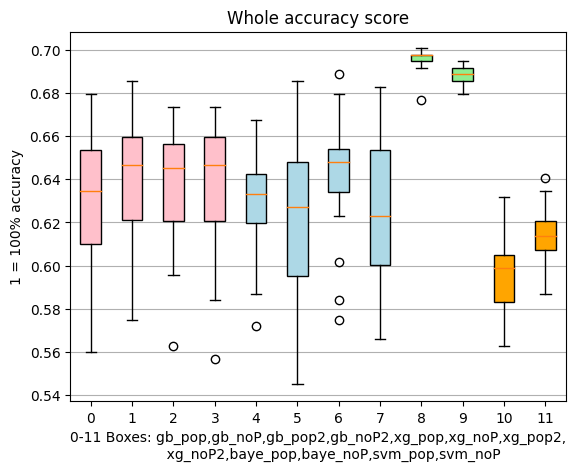

In [ ]:
import os
import csv

def read_csv_file(file_path):
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        data_list = [[float(value) for value in row] for row in csv_reader]
        data_list = np.concatenate(data_list)
    return data_list

# Define the folder names and file names
folders = ["gb1_odata_pop", "gb1_odata_noP", "xg1_odata_pop", "xg1_odata_noP", \
           "gb2_odata_pop", "gb2_odata_noP", "xg2_odata_pop", "xg2_odata_noP",\
           "baye_odata_pop", "baye_odata_noP", "svm_odata_pop", "svm_odata_noP"]

# Initialize empty lists
acc_w_gb_pop, acc_w_gb_noP, acc_w_xg_pop, acc_w_xg_noP, \
acc_w_gb_pop2, acc_w_gb_noP2, acc_w_xg_pop2, acc_w_xg_noP2, \
acc_w_baye_pop, acc_w_baye_noP,\
acc_w_svm_pop, acc_w_svm_noP= [], [], [], [], [], [], [], [], [], [], [], []
auc_gb_pop, auc_gb_noP, auc_xg_pop, auc_xg_noP, \
auc_gb_pop2, auc_gb_noP2, auc_xg_pop2, auc_xg_noP2,\
auc_baye_pop, auc_baye_noP,\
auc_w_svm_pop, auc_w_svm_noP= [], [], [], [], [], [], [], [], [], [], [], []

# Read data and store in corresponding lists
for folder,in zip(folders):
    acc_w_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "acc_w_all.csv")
    auc_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "auc_all.csv")

    if "baye" in folder:
        if "pop" in folder:
            acc_w_baye_pop = read_csv_file(acc_w_file_path)
            auc_baye_pop = read_csv_file(auc_file_path)
        else:
            acc_w_baye_noP = read_csv_file(acc_w_file_path)
            auc_baye_noP = read_csv_file(auc_file_path)
    elif "gb1" in folder:
        if "pop" in folder:
            acc_w_gb_pop = read_csv_file(acc_w_file_path)
            auc_gb_pop = read_csv_file(auc_file_path)
        else:
            acc_w_gb_noP = read_csv_file(acc_w_file_path)
            auc_gb_noP = read_csv_file(auc_file_path)
    elif "xg1" in folder:
        if "pop" in folder:
            acc_w_xg_pop = read_csv_file(acc_w_file_path)
            auc_xg_pop = read_csv_file(auc_file_path)
        else:
            acc_w_xg_noP = read_csv_file(acc_w_file_path)
            auc_xg_noP = read_csv_file(auc_file_path)
    elif "gb2" in folder:
        if "pop" in folder:
            acc_w_gb_pop2 = read_csv_file(acc_w_file_path)
            auc_gb_pop2 = read_csv_file(auc_file_path)
        else:
            acc_w_gb_noP2 = read_csv_file(acc_w_file_path)
            auc_gb_noP2 = read_csv_file(auc_file_path)
    elif "xg2" in folder:
        if "pop" in folder:
            acc_w_xg_pop2 = read_csv_file(acc_w_file_path)
            auc_xg_pop2 = read_csv_file(auc_file_path)
        else:
            acc_w_xg_noP2 = read_csv_file(acc_w_file_path)
            auc_xg_noP2 = read_csv_file(auc_file_path)
    elif "svm" in folder:
        if "pop" in folder:
            acc_w_svm_pop = read_csv_file(acc_w_file_path)
            auc_svm_pop = read_csv_file(auc_file_path)
        else:
            acc_w_svm_noP = read_csv_file(acc_w_file_path)
            auc_svm_noP = read_csv_file(auc_file_path)
# Print the lengths of the lists to verify the data has been loaded successfully
print(len(acc_w_gb_pop), len(acc_w_gb_noP), len(acc_w_xg_pop), len(acc_w_xg_noP)
    , len(acc_w_baye_pop), len(acc_w_baye_noP), len(acc_w_svm_pop), len(acc_w_svm_noP))
print(len(auc_gb_pop), len(auc_gb_noP), len(auc_xg_pop), len(auc_xg_noP)
    , len(auc_baye_pop), len(auc_baye_noP), len(auc_svm_pop), len(auc_svm_noP))

# Plotting
box_plot_data=[acc_w_gb_pop,acc_w_gb_noP,acc_w_xg_pop,acc_w_xg_noP,\
        acc_w_gb_pop2, acc_w_gb_noP2, acc_w_xg_pop2, acc_w_xg_noP2,
        acc_w_baye_pop,acc_w_baye_noP,acc_w_svm_pop,acc_w_svm_noP]#,acc_w_nn_pop,acc_w_nn_noP]
fig,ax1=plt.subplots()
bplot=ax1.boxplot(box_plot_data,labels=range(0,12),vert=True,patch_artist=True)
# fill with colors
colors = ['pink', 'pink', 'pink', 'pink', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'orange', 'orange']
for patch, color in zip(bplot['boxes'], colors):
  patch.set_facecolor(color)
ax1.yaxis.grid(True)
plt.title('Whole accuracy score')
plt.ylabel('1 = 100% accuracy')
plt.xlabel("0-11 Boxes: gb_pop,gb_noP,gb_pop2,gb_noP2,xg_pop,xg_noP,xg_pop2,\n\
       xg_noP2,baye_pop,baye_noP,svm_pop,svm_noP")#,nn_pop,nn_noP
plt.show()

##### Average acc/whole auc

20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20


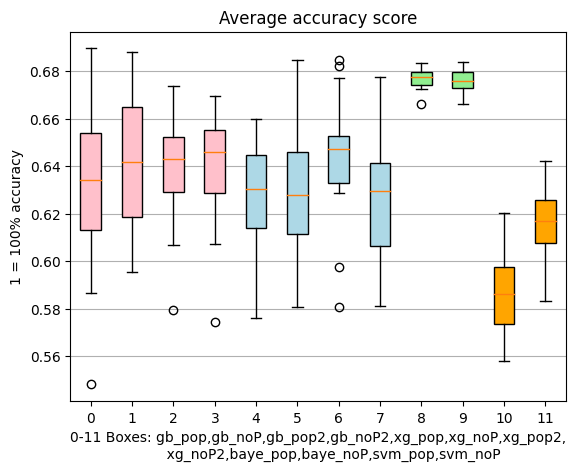

In [ ]:
# Take acc_all instead of acc_all
import os
import csv

def read_csv_file(file_path):
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        data_list = [[float(value) for value in row] for row in csv_reader]
        data_list = np.concatenate(data_list)
    return data_list

# Define the folder names and file names
folders = ["gb1_odata_pop", "gb1_odata_noP", "xg1_odata_pop", "xg1_odata_noP", \
           "gb2_odata_pop", "gb2_odata_noP", "xg2_odata_pop", "xg2_odata_noP",\
           "baye_odata_pop", "baye_odata_noP", "svm_odata_pop", "svm_odata_noP"]

# Initialize empty lists
acc_gb_pop, acc_gb_noP, acc_xg_pop, acc_xg_noP, \
acc_gb_pop2, acc_gb_noP2, acc_xg_pop2, acc_xg_noP2, \
acc_baye_pop, acc_baye_noP,\
acc_svm_pop, acc_svm_noP= [], [], [], [], [], [], [], [], [], [], [], []
auc_gb_pop, auc_gb_noP, auc_xg_pop, auc_xg_noP, \
auc_gb_pop2, auc_gb_noP2, auc_xg_pop2, auc_xg_noP2,\
auc_baye_pop, auc_baye_noP,\
auc_w_svm_pop, auc_w_svm_noP= [], [], [], [], [], [], [], [], [], [], [], []

# Read data and store in corresponding lists
for folder,in zip(folders):
    acc_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "acc_all.csv")
    auc_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "auc_all.csv")

    if "baye" in folder:
        if "pop" in folder:
            acc_baye_pop = read_csv_file(acc_file_path)
            auc_baye_pop = read_csv_file(auc_file_path)
        else:
            acc_baye_noP = read_csv_file(acc_file_path)
            auc_baye_noP = read_csv_file(auc_file_path)
    elif "gb1" in folder:
        if "pop" in folder:
            acc_gb_pop = read_csv_file(acc_file_path)
            auc_gb_pop = read_csv_file(auc_file_path)
        else:
            acc_gb_noP = read_csv_file(acc_file_path)
            auc_gb_noP = read_csv_file(auc_file_path)
    elif "xg1" in folder:
        if "pop" in folder:
            acc_xg_pop = read_csv_file(acc_file_path)
            auc_xg_pop = read_csv_file(auc_file_path)
        else:
            acc_xg_noP = read_csv_file(acc_file_path)
            auc_xg_noP = read_csv_file(auc_file_path)
    elif "gb2" in folder:
        if "pop" in folder:
            acc_gb_pop2 = read_csv_file(acc_file_path)
            auc_gb_pop2 = read_csv_file(auc_file_path)
        else:
            acc_gb_noP2 = read_csv_file(acc_file_path)
            auc_gb_noP2 = read_csv_file(auc_file_path)
    elif "xg2" in folder:
        if "pop" in folder:
            acc_xg_pop2 = read_csv_file(acc_file_path)
            auc_xg_pop2 = read_csv_file(auc_file_path)
        else:
            acc_xg_noP2 = read_csv_file(acc_file_path)
            auc_xg_noP2 = read_csv_file(auc_file_path)
    elif "svm" in folder:
        if "pop" in folder:
            acc_svm_pop = read_csv_file(acc_file_path)
            auc_svm_pop = read_csv_file(auc_file_path)
        else:
            acc_svm_noP = read_csv_file(acc_file_path)
            auc_svm_noP = read_csv_file(auc_file_path)
# Print the lengths of the lists to verify the data has been loaded successfully
print(len(acc_gb_pop), len(acc_gb_noP), len(acc_xg_pop), len(acc_xg_noP)
    , len(acc_baye_pop), len(acc_baye_noP), len(acc_svm_pop), len(acc_svm_noP))
print(len(auc_gb_pop), len(auc_gb_noP), len(auc_xg_pop), len(auc_xg_noP)
    , len(auc_baye_pop), len(auc_baye_noP), len(auc_svm_pop), len(auc_svm_noP))

# Plotting
box_plot_data=[acc_gb_pop,acc_gb_noP,acc_xg_pop,acc_xg_noP,\
        acc_gb_pop2, acc_gb_noP2, acc_xg_pop2, acc_xg_noP2,
        acc_baye_pop,acc_baye_noP,acc_svm_pop,acc_svm_noP]#,acc_nn_pop,acc_nn_noP]
fig,ax1=plt.subplots()
bplot=ax1.boxplot(box_plot_data,labels=range(0,12),vert=True,patch_artist=True)
# fill with colors
colors = ['pink', 'pink', 'pink', 'pink', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'orange', 'orange']
for patch, color in zip(bplot['boxes'], colors):
  patch.set_facecolor(color)
ax1.yaxis.grid(True)
plt.title('Average accuracy score')
plt.ylabel('1 = 100% accuracy')
plt.xlabel("0-11 Boxes: gb_pop,gb_noP,gb_pop2,gb_noP2,xg_pop,xg_noP,xg_pop2,\n\
       xg_noP2,baye_pop,baye_noP,svm_pop,svm_noP")#,nn_pop,nn_noP
plt.show()

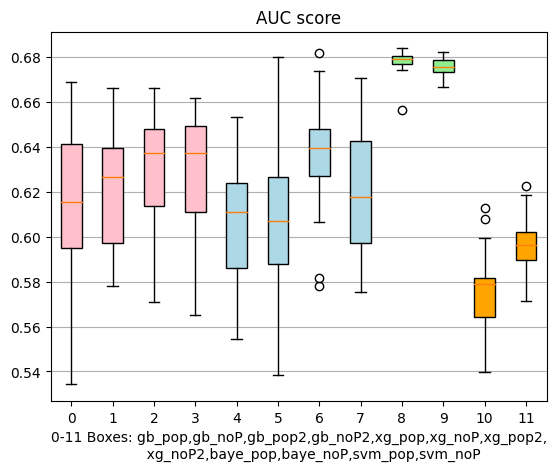

In [ ]:
# Plotting
box_plot_data=[auc_gb_pop,auc_gb_noP,auc_xg_pop,auc_xg_noP,\
        auc_gb_pop2, auc_gb_noP2, auc_xg_pop2, auc_xg_noP2,
        auc_baye_pop,auc_baye_noP,auc_svm_pop,auc_svm_noP]#,auc_nn_pop,auc_nn_noP]
fig,ax1=plt.subplots()
bplot=ax1.boxplot(box_plot_data,labels=range(0,12),vert=True,patch_artist=True)
# fill with colors
colors = ['pink', 'pink', 'pink', 'pink', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'orange', 'orange']
for patch, color in zip(bplot['boxes'], colors):
  patch.set_facecolor(color)
ax1.yaxis.grid(True)
plt.title('AUC score')
# plt.ylabel('1 = 100% aucuracy')
plt.xlabel("0-11 Boxes: gb_pop,gb_noP,gb_pop2,gb_noP2,xg_pop,xg_noP,xg_pop2,\n\
       xg_noP2,baye_pop,baye_noP,svm_pop,svm_noP")#,nn_pop,nn_noP
plt.show()

#### GKB data

In [ ]:
# Load gkb data for nn model
# Import data
data2 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/GKBdata_fzero.csv")
# One hot encode with get_dummies
Y2 = data2['Label']
Y2 = np.array([Y2.values.tolist()]).reshape(Y2.shape[0],)
Y2.shape

(700,)

##### Read NN results - GKBdata

In [ ]:
# read nn resulting files
nn_acc_pop= pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/nn_gkb_pop/acc_all_folds.csv",header=None)
# nn_acc_pop
nn_acc_pop = nn_acc_pop.T
nn_acc_pop = np.array([nn_acc_pop.values.tolist()]).reshape(nn_acc_pop.shape[0],-1)
# nn_acc_pop[0].shape
acc_nn_pop = []
for x in nn_acc_pop:
  acc_nn_pop.append(np.mean(x))
# acc_nn_pop

In [ ]:
# read nn resulting files2
nn_acc_noP= pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/nn_gkb_noP/acc_all_folds.csv",header=None)
# nn_acc_noP
nn_acc_noP = nn_acc_noP.T
nn_acc_noP = np.array([nn_acc_noP.values.tolist()]).reshape(nn_acc_noP.shape[0],-1)
# nn_acc_noP[0].shape
acc_nn_noP = []
for x in nn_acc_noP:
  acc_nn_noP.append(np.mean(x))
# acc_nn_noP

In [ ]:
# df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/nn_odata_pop/Fold8_yhat_l.csv", header=None)
# print(df)
base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/nn_gkb_pop/"

def read_yhat(path):
  df = pd.read_csv(path,header=None)
  # df = df.T
  nn_pop_yhat = np.array([df.values.tolist()]).reshape(df.shape[0],-1)
  return nn_pop_yhat

yhat = np.empty((20, 0))
for fold_number in range(11):
  path = f"{base}Fold{fold_number}_yhat_l.csv"
  fold_array = read_yhat(path)
  # print(fold_array.dtype)
  print(fold_array.shape)
  yhat = np.concatenate((yhat,fold_array),axis=1)
  # print(yhat.shape)
  # print(fold_array)

auc_nn_pop = []
acc_w_nn_pop = []
for x in yhat:
  auc = roc_auc_score(Y2, x)
  auc_nn_pop.append(auc)
  acc = accuracy_score(Y2, x)
  acc_w_nn_pop.append(acc)
print(auc_nn_pop,"\n",acc_w_nn_pop)

(20, 136)
(20, 62)
(20, 51)
(20, 83)
(20, 31)
(20, 121)
(20, 37)
(20, 38)
(20, 31)
(20, 70)
(20, 40)
[0.5120915032679738, 0.49468954248366015, 0.5195261437908496, 0.5023692810457516, 0.5098856209150326, 0.5080882352941176, 0.516421568627451, 0.49795751633986923, 0.4956699346405229, 0.5141339869281045, 0.4893790849673202, 0.4985294117647059, 0.5239379084967319, 0.497140522875817, 0.5188725490196078, 0.5165849673202615, 0.506781045751634, 0.5062908496732027, 0.5034313725490196, 0.47973856209150323] 
 [0.51, 0.4942857142857143, 0.5228571428571429, 0.5, 0.5128571428571429, 0.51, 0.5185714285714286, 0.4957142857142857, 0.49714285714285716, 0.5157142857142857, 0.48714285714285716, 0.5014285714285714, 0.5242857142857142, 0.5, 0.5214285714285715, 0.5185714285714286, 0.5028571428571429, 0.5085714285714286, 0.5071428571428571, 0.4785714285714286]


In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/nn_gkb_noP/Fold8_yhat_l.csv", header=None)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...


In [ ]:
# df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/nn_odata_noP/Fold8_yhat_l.csv", header=None)
# print(df)
base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/nn_gkb_noP/"

def read_yhat(path):
  df = pd.read_csv(path,header=None)
  # print(df)
  df = df.T
  nn_pop_yhat = np.array([df.values.tolist()]).reshape(df.shape[0],-1)
  return nn_pop_yhat

yhat = np.empty((20, 0))
for fold_number in range(11):
  path = f"{base}Fold{fold_number}_yhat_l.csv"
  fold_array = read_yhat(path)
  # print(fold_array.dtype)
  print(fold_array.shape)
  yhat = np.concatenate((yhat,fold_array),axis=1)
  # print(yhat.shape)
  # print(fold_array)

auc_nn_noP = []
acc_w_nn_noP = []
for x in yhat:
  auc = roc_auc_score(Y2, x)
  auc_nn_noP.append(auc)
  acc = accuracy_score(Y2, x)
  acc_w_nn_noP.append(acc)
print(auc_nn_noP,"\n",acc_w_nn_noP)

(20, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)
(20, 1)


ValueError: ignored

##### Whole acc/Read results from repeated training for xg,gb,svm and bayes model

20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20


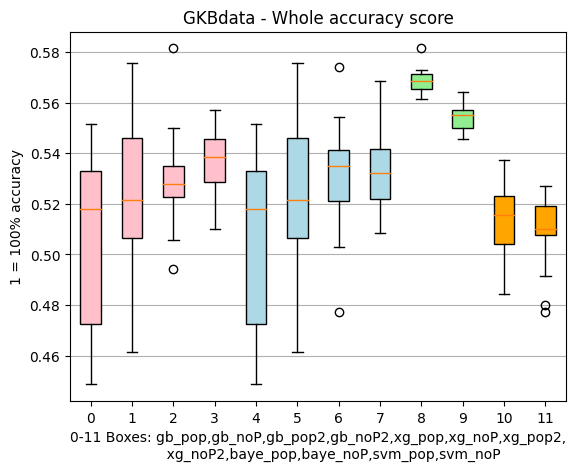

In [ ]:
import os
import csv

def read_csv_file(file_path):
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        data_list = [[float(value) for value in row] for row in csv_reader]
        data_list = np.concatenate(data_list)
    return data_list

# Define the folder names and file names
folders = ["gb1_gkb_pop", "gb1_gkb_noP", "xg1_gkb_pop", "xg1_gkb_noP", \
           "gb2_gkb_pop", "gb2_gkb_noP", "xg2_gkb_pop", "xg2_gkb_noP",\
           "baye_gkb_pop", "baye_gkb_noP", "svm_gkb_pop", "svm_gkb_noP"]

# Initialize empty lists
acc_w_gb_pop, acc_w_gb_noP, acc_w_xg_pop, acc_w_xg_noP, \
acc_w_gb_pop2, acc_w_gb_noP2, acc_w_xg_pop2, acc_w_xg_noP2, \
acc_w_baye_pop, acc_w_baye_noP,\
acc_w_svm_pop, acc_w_svm_noP= [], [], [], [], [], [], [], [], [], [], [], []
auc_gb_pop, auc_gb_noP, auc_xg_pop, auc_xg_noP, \
auc_gb_pop2, auc_gb_noP2, auc_xg_pop2, auc_xg_noP2,\
auc_baye_pop, auc_baye_noP,\
auc_w_svm_pop, auc_w_svm_noP= [], [], [], [], [], [], [], [], [], [], [], []

# Read data and store in corresponding lists
for folder,in zip(folders):
    acc_w_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "acc_w_all.csv")
    auc_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "auc_all.csv")

    if "baye" in folder:
        if "pop" in folder:
            acc_w_baye_pop = read_csv_file(acc_w_file_path)
            auc_baye_pop = read_csv_file(auc_file_path)
        else:
            acc_w_baye_noP = read_csv_file(acc_w_file_path)
            auc_baye_noP = read_csv_file(auc_file_path)
    elif "gb1" in folder:
        if "pop" in folder:
            acc_w_gb_pop = read_csv_file(acc_w_file_path)
            auc_gb_pop = read_csv_file(auc_file_path)
        else:
            acc_w_gb_noP = read_csv_file(acc_w_file_path)
            auc_gb_noP = read_csv_file(auc_file_path)
    elif "xg1" in folder:
        if "pop" in folder:
            acc_w_xg_pop = read_csv_file(acc_w_file_path)
            auc_xg_pop = read_csv_file(auc_file_path)
        else:
            acc_w_xg_noP = read_csv_file(acc_w_file_path)
            auc_xg_noP = read_csv_file(auc_file_path)
    elif "gb2" in folder:
        if "pop" in folder:
            acc_w_gb_pop2 = read_csv_file(acc_w_file_path)
            auc_gb_pop2 = read_csv_file(auc_file_path)
        else:
            acc_w_gb_noP2 = read_csv_file(acc_w_file_path)
            auc_gb_noP2 = read_csv_file(auc_file_path)
    elif "xg2" in folder:
        if "pop" in folder:
            acc_w_xg_pop2 = read_csv_file(acc_w_file_path)
            auc_xg_pop2 = read_csv_file(auc_file_path)
        else:
            acc_w_xg_noP2 = read_csv_file(acc_w_file_path)
            auc_xg_noP2 = read_csv_file(auc_file_path)
    elif "svm" in folder:
        if "pop" in folder:
            acc_w_svm_pop = read_csv_file(acc_w_file_path)
            auc_svm_pop = read_csv_file(auc_file_path)
        else:
            acc_w_svm_noP = read_csv_file(acc_w_file_path)
            auc_svm_noP = read_csv_file(auc_file_path)
# Print the lengths of the lists to verify the data has been loaded successfully
print(len(acc_w_gb_pop), len(acc_w_gb_noP), len(acc_w_xg_pop), len(acc_w_xg_noP)
    , len(acc_w_baye_pop), len(acc_w_baye_noP), len(acc_w_svm_pop), len(acc_w_svm_noP))
print(len(auc_gb_pop), len(auc_gb_noP), len(auc_xg_pop), len(auc_xg_noP)
    , len(auc_baye_pop), len(auc_baye_noP), len(auc_svm_pop), len(auc_svm_noP))

# Plotting
box_plot_data=[acc_w_gb_pop,acc_w_gb_noP,acc_w_xg_pop,acc_w_xg_noP,\
        acc_w_gb_pop2, acc_w_gb_noP2, acc_w_xg_pop2, acc_w_xg_noP2,
        acc_w_baye_pop,acc_w_baye_noP,acc_w_svm_pop,acc_w_svm_noP]#,acc_w_nn_pop,acc_w_nn_noP]
fig,ax1=plt.subplots()
bplot=ax1.boxplot(box_plot_data,labels=range(0,12),vert=True,patch_artist=True)
# fill with colors
colors = ['pink', 'pink', 'pink', 'pink', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'orange', 'orange']
for patch, color in zip(bplot['boxes'], colors):
  patch.set_facecolor(color)
ax1.yaxis.grid(True)
plt.title('GKBdata - Whole accuracy score')
plt.ylabel('1 = 100% accuracy')
plt.xlabel("0-11 Boxes: gb_pop,gb_noP,gb_pop2,gb_noP2,xg_pop,xg_noP,xg_pop2,\n\
       xg_noP2,baye_pop,baye_noP,svm_pop,svm_noP")#,nn_pop,nn_noP
plt.show()

##### Whole auc

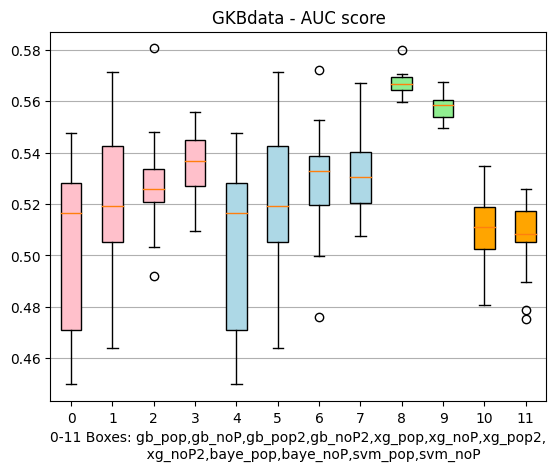

In [ ]:
# Plotting
box_plot_data=[auc_gb_pop,auc_gb_noP,auc_xg_pop,auc_xg_noP,\
        auc_gb_pop2, auc_gb_noP2, auc_xg_pop2, auc_xg_noP2,
        auc_baye_pop,auc_baye_noP,auc_svm_pop,auc_svm_noP]#,auc_nn_pop,auc_nn_noP]
fig,ax1=plt.subplots()
bplot=ax1.boxplot(box_plot_data,labels=range(0,12),vert=True,patch_artist=True)
# fill with colors
colors = ['pink', 'pink', 'pink', 'pink', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'orange', 'orange']
for patch, color in zip(bplot['boxes'], colors):
  patch.set_facecolor(color)
ax1.yaxis.grid(True)
plt.title('GKBdata - AUC score')
# plt.ylabel('1 = 100% aucuracy')
plt.xlabel("0-11 Boxes: gb_pop,gb_noP,gb_pop2,gb_noP2,xg_pop,xg_noP,xg_pop2,\n\
       xg_noP2,baye_pop,baye_noP,svm_pop,svm_noP")#,nn_pop,nn_noP
plt.show()

##### Average acc

20 20 20 20 20 20 20 20
20 20 20 20 20 20 20 20


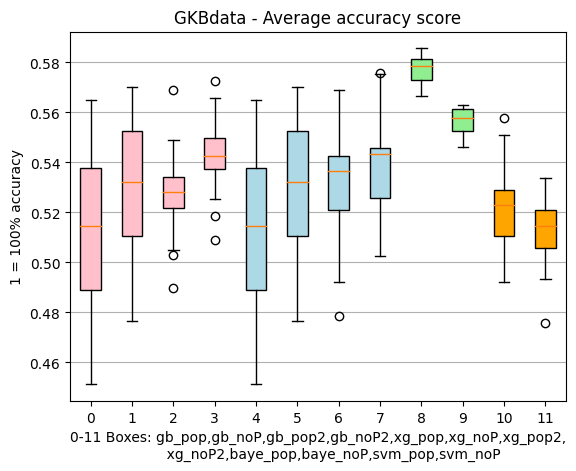

In [ ]:
# Take acc_all instead of acc_all
import os
import csv

def read_csv_file(file_path):
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        data_list = [[float(value) for value in row] for row in csv_reader]
        data_list = np.concatenate(data_list)
    return data_list

# Define the folder names and file names
folders = ["gb1_gkb_pop", "gb1_gkb_noP", "xg1_gkb_pop", "xg1_gkb_noP", \
           "gb2_gkb_pop", "gb2_gkb_noP", "xg2_gkb_pop", "xg2_gkb_noP",\
           "baye_gkb_pop", "baye_gkb_noP", "svm_gkb_pop", "svm_gkb_noP"]

# Initialize empty lists
acc_gb_pop, acc_gb_noP, acc_xg_pop, acc_xg_noP, \
acc_gb_pop2, acc_gb_noP2, acc_xg_pop2, acc_xg_noP2, \
acc_baye_pop, acc_baye_noP,\
acc_svm_pop, acc_svm_noP= [], [], [], [], [], [], [], [], [], [], [], []
auc_gb_pop, auc_gb_noP, auc_xg_pop, auc_xg_noP, \
auc_gb_pop2, auc_gb_noP2, auc_xg_pop2, auc_xg_noP2,\
auc_baye_pop, auc_baye_noP,\
auc_w_svm_pop, auc_w_svm_noP= [], [], [], [], [], [], [], [], [], [], [], []

# Read data and store in corresponding lists
for folder,in zip(folders):
    acc_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "acc_all.csv")
    auc_file_path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/ADME Project", folder, "auc_all.csv")

    if "baye" in folder:
        if "pop" in folder:
            acc_baye_pop = read_csv_file(acc_file_path)
            auc_baye_pop = read_csv_file(auc_file_path)
        else:
            acc_baye_noP = read_csv_file(acc_file_path)
            auc_baye_noP = read_csv_file(auc_file_path)
    elif "gb1" in folder:
        if "pop" in folder:
            acc_gb_pop = read_csv_file(acc_file_path)
            auc_gb_pop = read_csv_file(auc_file_path)
        else:
            acc_gb_noP = read_csv_file(acc_file_path)
            auc_gb_noP = read_csv_file(auc_file_path)
    elif "xg1" in folder:
        if "pop" in folder:
            acc_xg_pop = read_csv_file(acc_file_path)
            auc_xg_pop = read_csv_file(auc_file_path)
        else:
            acc_xg_noP = read_csv_file(acc_file_path)
            auc_xg_noP = read_csv_file(auc_file_path)
    elif "gb2" in folder:
        if "pop" in folder:
            acc_gb_pop2 = read_csv_file(acc_file_path)
            auc_gb_pop2 = read_csv_file(auc_file_path)
        else:
            acc_gb_noP2 = read_csv_file(acc_file_path)
            auc_gb_noP2 = read_csv_file(auc_file_path)
    elif "xg2" in folder:
        if "pop" in folder:
            acc_xg_pop2 = read_csv_file(acc_file_path)
            auc_xg_pop2 = read_csv_file(auc_file_path)
        else:
            acc_xg_noP2 = read_csv_file(acc_file_path)
            auc_xg_noP2 = read_csv_file(auc_file_path)
    elif "svm" in folder:
        if "pop" in folder:
            acc_svm_pop = read_csv_file(acc_file_path)
            auc_svm_pop = read_csv_file(auc_file_path)
        else:
            acc_svm_noP = read_csv_file(acc_file_path)
            auc_svm_noP = read_csv_file(auc_file_path)
# Print the lengths of the lists to verify the data has been loaded successfully
print(len(acc_gb_pop), len(acc_gb_noP), len(acc_xg_pop), len(acc_xg_noP)
    , len(acc_baye_pop), len(acc_baye_noP), len(acc_svm_pop), len(acc_svm_noP))
print(len(auc_gb_pop), len(auc_gb_noP), len(auc_xg_pop), len(auc_xg_noP)
    , len(auc_baye_pop), len(auc_baye_noP), len(auc_svm_pop), len(auc_svm_noP))

# Plotting
box_plot_data=[acc_gb_pop,acc_gb_noP,acc_xg_pop,acc_xg_noP,\
        acc_gb_pop2, acc_gb_noP2, acc_xg_pop2, acc_xg_noP2,
        acc_baye_pop,acc_baye_noP,acc_svm_pop,acc_svm_noP]#,acc_nn_pop,acc_nn_noP]
fig,ax1=plt.subplots()
bplot=ax1.boxplot(box_plot_data,labels=range(0,12),vert=True,patch_artist=True)
# fill with colors
colors = ['pink', 'pink', 'pink', 'pink', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'orange', 'orange']
for patch, color in zip(bplot['boxes'], colors):
  patch.set_facecolor(color)
ax1.yaxis.grid(True)
plt.title('GKBdata - Average accuracy score')
plt.ylabel('1 = 100% accuracy')
plt.xlabel("0-11 Boxes: gb_pop,gb_noP,gb_pop2,gb_noP2,xg_pop,xg_noP,xg_pop2,\n\
       xg_noP2,baye_pop,baye_noP,svm_pop,svm_noP")#,nn_pop,nn_noP
plt.show()

### Thresholding

##### Proba reading initialization

In [10]:
def convert(pred_probs, thres):
    converted_preds = np.empty(len(pred_probs), dtype=object)
    # print(pred_probs)
    for i in range(len(pred_probs)):
        # print(pred_probs[i])
        prob_class_0 = pred_probs[i][0]
        prob_class_1 = pred_probs[i][1]
        if prob_class_0 > thres:
            converted_preds[i] = 0
        elif prob_class_1 > thres:
            converted_preds[i] = 1
        else:
            converted_preds[i] = np.nan
    return converted_preds

def prob_acc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    # print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    # print(len(valid_y_test))
    accuracy = accuracy_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

def prob_auc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    # print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    # print(len(valid_y_test))
    accuracy = roc_auc_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

# Define XGBoost model hyperparameters grid
def create_xgboost_model(learning_rate, max_depth, n_estimators, min_child_weight, subsample, gamma, reg_alpha):
    model = xgb.XGBClassifier(
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        n_estimators=int(n_estimators),
        min_child_weight=min_child_weight,
        subsample=subsample,
        gamma=gamma,
        reg_alpha=reg_alpha,
        objective='binary:logistic',
        random_state=42
    )
    return model # in data loading, X is already scaled
    # make_pipeline(StandardScaler(),model) # From early results, scaler gives more consistent/stable results.
    # model = make_pipeline(StandardScaler(), XGBClassifier(objective='binary:logistic', random_state=0))

# # Define the hyperparameter search space
# param_space = {
#     'learning_rate': (0.01, 1.0, 'log-uniform'),
#     'max_depth': (1, 10),
#     'n_estimators': (50, 1000),
#     'min_child_weight': (1, 10),
#     'subsample': (0.1, 1.0, 'uniform'),
#     'gamma': (0.01, 1.0, 'uniform'),
#     'reg_alpha': (0.01, 1.0, 'uniform')
# }

#### XGboost Thresholding

##### Read best paras

(?) Add reg lambda? - Tried, the performance is not promoted.

In [16]:
import csv
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [element for element in row]
            data.append(row_data)
    return data
path = f"{base}xg1_odata_pop/best_params_list_1.csv"
paras_l = read_csv(path)
paras_l = paras_l[0]
paras_l

["OrderedDict([('gamma', 1.0), ('learning_rate', 0.01756567096207286), ('max_depth', 1), ('min_child_weight', 4), ('n_estimators', 119), ('reg_alpha', 0.01), ('subsample', 0.698463294217359)])",
 "OrderedDict([('gamma', 1.0), ('learning_rate', 0.05558799935811328), ('max_depth', 6), ('min_child_weight', 7), ('n_estimators', 228), ('reg_alpha', 0.8600333361727824), ('subsample', 0.38567613301781933)])",
 "OrderedDict([('gamma', 0.01), ('learning_rate', 0.014116602443684874), ('max_depth', 10), ('min_child_weight', 10), ('n_estimators', 58), ('reg_alpha', 0.26750034385169486), ('subsample', 0.4607524370885613)])",
 "OrderedDict([('gamma', 0.20431190407392957), ('learning_rate', 0.01), ('max_depth', 10), ('min_child_weight', 10), ('n_estimators', 1000), ('reg_alpha', 0.8962521772880749), ('subsample', 0.36250443403160915)])",
 "OrderedDict([('gamma', 0.7402075378552239), ('learning_rate', 0.5925935888492632), ('max_depth', 9), ('min_child_weight', 3), ('n_estimators', 965), ('reg_alpha', 

In [17]:
import ast
def convert_to_dict(entry):
    ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
    ordered_dict = ast.literal_eval(ordered_dict_str)
    return dict(ordered_dict)
converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
converted_paras_l

[{'gamma': 1.0,
  'learning_rate': 0.01756567096207286,
  'max_depth': 1,
  'min_child_weight': 4,
  'n_estimators': 119,
  'reg_alpha': 0.01,
  'subsample': 0.698463294217359},
 {'gamma': 1.0,
  'learning_rate': 0.05558799935811328,
  'max_depth': 6,
  'min_child_weight': 7,
  'n_estimators': 228,
  'reg_alpha': 0.8600333361727824,
  'subsample': 0.38567613301781933},
 {'gamma': 0.01,
  'learning_rate': 0.014116602443684874,
  'max_depth': 10,
  'min_child_weight': 10,
  'n_estimators': 58,
  'reg_alpha': 0.26750034385169486,
  'subsample': 0.4607524370885613},
 {'gamma': 0.20431190407392957,
  'learning_rate': 0.01,
  'max_depth': 10,
  'min_child_weight': 10,
  'n_estimators': 1000,
  'reg_alpha': 0.8962521772880749,
  'subsample': 0.36250443403160915},
 {'gamma': 0.7402075378552239,
  'learning_rate': 0.5925935888492632,
  'max_depth': 9,
  'min_child_weight': 3,
  'n_estimators': 965,
  'reg_alpha': 0.5286125075563574,
  'subsample': 0.27657952021923926},
 {'gamma': 0.590303499703

##### Test with different Thres

In [18]:
#Trial
train_v_indexes = trainlist[0]
val_indexes = vlist[0]
test_indexes = testlist[0]
X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
X_test, y_test= X[test_indexes], Y[test_indexes]

paras  = converted_paras_l[0]

model = create_xgboost_model(**paras)
model.fit(X_train, y_train)
yhat = model.predict_proba(X_test)

#6 Calculate and store
thres = 0.7
acc, o_p = prob_acc(y_test, yhat, thres)
print(acc, o_p)

0.8 82.14285714285714


In [19]:
acc_tl = []
acc_w_tl = []
auc_tl = []
o_p_tl = []
o_p_all = 0
thres = 0.51
while o_p_all < 90:
  acc_scores = []
  n = 1
  yhat_all = []
  ytrue_all = []
  o_p_l = []
  for i in range(len(testlist)):
    print(f"Fold {i}; ")
    paras = converted_paras_l[i]
    #1 Build training, validation and test sets/Extract individual index list
    train_v_indexes = trainlist[i]
    val_indexes = vlist[i]
    test_indexes = testlist[i]
    X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
    X_test, y_test= X[test_indexes], Y[test_indexes]
    # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
    #     f"testing index: {len(test_indexes)}") #{test_indexes},

    #2 Use train and validation indexes to create the custom split
    # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
    custom_split = [-1] * len(train_v_indexes)
    for j, x in enumerate(train_v_indexes):
      if x in val_indexes: custom_split[j] = 0
    # Initialize the PredefinedSplit object
    ps = PredefinedSplit(test_fold=custom_split)

    #3 Create model with paras found by former BayesSearch
    model = create_xgboost_model(**paras)
    model.fit(X_train, y_train)
    yhat = model.predict_proba(X_test)

    #6 Calculate and store
    acc, o_p = prob_acc(y_test, yhat, thres)
    # auc = roc_auc_score(y_test, yhat)
    acc_scores.append(acc)
    o_p_l.append(o_p)
    ytrue_all.append(y_test)
    yhat_all.append(yhat)
    # auc_scores.append(auc)
    # print("Iteration Accuray: {:.2f}%".format(100*acc))
    # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
    n+=1
  thres = thres+0.01
  #For one thres
  #7 Results for all testing folds
  # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
  ytrue_all = np.concatenate(ytrue_all)
  yhat_all= np.concatenate(yhat_all)
  acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
  auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
  # Filter nan in acc
  nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
  acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
  #
  acc_ave = np.mean(acc_scores)
  acc_w_tl.append(acc_w)
  acc_tl.append(acc_ave)
  auc_tl.append(auc)
  o_p_tl.append(o_p_all)
  print("Average Accuray: {:.2f}%".format(100*acc_ave))
  print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
      {:.2f}%".format(acc_w * 100, o_p_all))
  print("Whole AUC: {:.4f}%".format(auc))

Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 66.17%
Whole Accuracy: 66.46%, Percentage of Data Omitted:       3.59%
Whole AUC: 0.6554%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 66.51%
Whole Accuracy: 66.24%, Percentage of Data Omitted:       5.99%
Whole AUC: 0.6519%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 66.53%
Whole Accuracy: 66.01%, Percentage of Data Omitted:       8.38%
Whole AUC: 0.6507%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 66.35%
Whole Accuracy: 66.89%, Percentage of Data Omitted:       12.28%
Whole AUC: 0.6604%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 68.08%
Whole Accuracy: 66.78%, Percentage of Data Omitted:       14.37%
Whole AUC: 0.6608%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 68.43%
Whole Accuracy: 65.58%, Percentage of Data Omitted:       35.63%
Whole AUC: 0.6541%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 68.11%
Whole Accuracy: 65.07%, Percentage of Data Omitted:       37.43%
Whole AUC: 0.6486%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 67.44%
Whole Accuracy: 65.05%, Percentage of Data Omitted:       38.32%
Whole AUC: 0.6487%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 67.04%
Whole Accuracy: 64.82%, Percentage of Data Omitted:       40.42%
Whole AUC: 0.6467%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 66.63%
Whole Accuracy: 64.47%, Percentage of Data Omitted:       41.02%
Whole AUC: 0.6436%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 66.41%
Whole Accuracy: 65.41%, Percentage of Data Omitted:       44.61%
Whole AUC: 0.6528%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 68.85%
Whole Accuracy: 65.56%, Percentage of Data Omitted:       46.11%
Whole AUC: 0.6545%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 68.73%
Whole Accuracy: 64.74%, Percentage of Data Omitted:       48.20%
Whole AUC: 0.6458%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 67.62%
Whole Accuracy: 64.85%, Percentage of Data Omitted:       50.60%
Whole AUC: 0.6474%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 71.80%
Whole Accuracy: 65.00%, Percentage of Data Omitted:       52.10%
Whole AUC: 0.6486%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 71.72%
Whole Accuracy: 64.94%, Percentage of Data Omitted:       53.89%
Whole AUC: 0.6479%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 72.45%
Whole Accuracy: 63.70%, Percentage of Data Omitted:       56.29%
Whole AUC: 0.6357%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 68.14%
Whole Accuracy: 63.45%, Percentage of Data Omitted:       56.59%
Whole AUC: 0.6329%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 66.95%
Whole Accuracy: 61.83%, Percentage of Data Omitted:       60.78%
Whole AUC: 0.6143%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 60.67%
Whole Accuracy: 61.72%, Percentage of Data Omitted:       61.68%
Whole AUC: 0.6142%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 61.06%
Whole Accuracy: 62.90%, Percentage of Data Omitted:       62.87%
Whole AUC: 0.6266%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 63.21%
Whole Accuracy: 62.39%, Percentage of Data Omitted:       64.97%
Whole AUC: 0.6190%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 64.44%
Whole Accuracy: 62.73%, Percentage of Data Omitted:       67.07%
Whole AUC: 0.6246%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 65.39%
Whole Accuracy: 62.50%, Percentage of Data Omitted:       68.86%
Whole AUC: 0.6205%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 66.01%
Whole Accuracy: 63.37%, Percentage of Data Omitted:       69.76%
Whole AUC: 0.6298%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 67.18%
Whole Accuracy: 68.97%, Percentage of Data Omitted:       73.95%
Whole AUC: 0.6985%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 86.33%
Whole Accuracy: 71.08%, Percentage of Data Omitted:       75.15%
Whole AUC: 0.7154%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 86.61%
Whole Accuracy: 71.08%, Percentage of Data Omitted:       75.15%
Whole AUC: 0.7154%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 86.61%
Whole Accuracy: 68.00%, Percentage of Data Omitted:       77.54%
Whole AUC: 0.6847%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 72.22%
Whole Accuracy: 70.42%, Percentage of Data Omitted:       78.74%
Whole AUC: 0.7121%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518

Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 78.43%
Whole Accuracy: 69.70%, Percentage of Data Omitted:       80.24%
Whole AUC: 0.7036%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518

Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518

Average Accuray: 78.86%
Whole Accuracy: 66.67%, Percentage of Data Omitted:       82.04%
Whole AUC: 0.6742%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 76.77%
Whole Accuracy: 64.29%, Percentage of Data Omitted:       83.23%
Whole AUC: 0.6503%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518

Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 73.59%
Whole Accuracy: 65.38%, Percentage of Data Omitted:       84.43%
Whole AUC: 0.6636%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518

Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 61.50%
Whole Accuracy: 66.00%, Percentage of Data Omitted:       85.03%
Whole AUC: 0.6741%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518

Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 64.58%
Whole Accuracy: 63.83%, Percentage of Data Omitted:       85.93%
Whole AUC: 0.6541%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 57.93%
Whole Accuracy: 60.47%, Percentage of Data Omitted:       87.13%
Whole AUC: 0.6222%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518

Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 56.08%
Whole Accuracy: 60.00%, Percentage of Data Omitted:       89.52%
Whole AUC: 0.6071%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518

Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 63.02%
Whole Accuracy: 60.00%, Percentage of Data Omitted:       91.02%
Whole AUC: 0.6111%


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


##### Plot

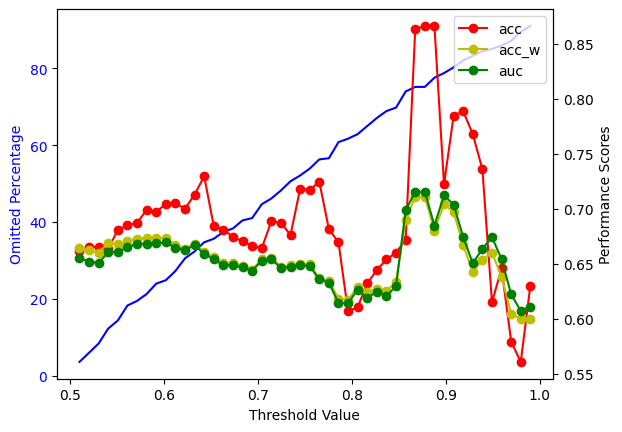

In [20]:
fig, ax1 = plt.subplots()
x_lim = np.linspace(0.51,thres,(len(o_p_tl)))
ax1.plot(x_lim, o_p_tl, 'b-')
ax1.set_xlabel('Threshold Value')
ax1.set_ylabel('Omitted Percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(x_lim, acc_tl, 'ro-', label='acc')
ax2.plot(x_lim, acc_w_tl, 'yo-', label='acc_w')
ax2.plot(x_lim, auc_tl, 'go-', label='auc')
ax2.legend()
ax2.set_ylabel('Performance Scores',color='k')
ax2.tick_params(axis='y',labelcolor='k')

Conclusion: the middle drops means that the high thresholding region has considerable mis-predictions.

#### Baye Thresholding

##### Load predictions/best parameters

In [21]:
import csv
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [element for element in row]
            data.append(row_data)
    return data
path = f"{base}baye_odata_pop/best_params_0.csv"
paras_l = read_csv(path)
paras_l = paras_l[0]
import ast
def convert_to_dict(entry):
    ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
    ordered_dict = ast.literal_eval(ordered_dict_str)
    return dict(ordered_dict)
converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
converted_paras_l

[{'var_smoothing': 7.031608284596767e-08},
 {'var_smoothing': 7.090799148967775e-08},
 {'var_smoothing': 5.777522173521324e-08},
 {'var_smoothing': 3.319754587452058e-08},
 {'var_smoothing': 6.943385166706948e-08},
 {'var_smoothing': 8.984640371894955e-08},
 {'var_smoothing': 4.165148774754093e-08},
 {'var_smoothing': 1e-11},
 {'var_smoothing': 8.50591256187659e-08}]

##### Baye Initiliazation

In [22]:
from sklearn.naive_bayes import GaussianNB
# Build training, validation and test sets/Extract individual index list
train_v_indexes = trainlist[-1]
val_indexes = vlist[-1]
test_indexes = testlist[-1]
X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
X_test, y_test= X[test_indexes], Y[test_indexes]
print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
    f"testing index: {len(test_indexes)}") #{test_indexes},
gnb = GaussianNB()
gnb.fit(X_train, y_train)
pred = gnb.predict(X_test)
acc_b_tr = gnb.score(X_train, y_train)
acc_b = accuracy_score(y_test, pred)
auc_b = roc_auc_score(y_test, pred)
print("Training Accuray: {:.2f}%".format(100*gnb.score(X_train, y_train)))
print("Model Accuray: {:.2f}%".format(100*acc_b))
print("Model AUC_ROC: {:.4f}".format(auc_b))

training+validation index: 299;  testing index: 35
Training Accuray: 65.55%
Model Accuray: 77.14%
Model AUC_ROC: 0.7200


##### Test with different thres

In [47]:
from sklearn.model_selection import PredefinedSplit
def convert(pred_probs, thres):
    converted_preds = np.empty(len(pred_probs), dtype=object)
    # print(pred_probs)
    for i in range(len(pred_probs)):
        # print(pred_probs[i])
        prob_class_0 = pred_probs[i][0]
        prob_class_1 = pred_probs[i][1]
        if prob_class_0 > thres:
            converted_preds[i] = 0
        elif prob_class_1 > thres:
            converted_preds[i] = 1
        else:
            converted_preds[i] = np.nan
    return converted_preds

def prob_acc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    # print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    # print(len(valid_y_test))
    accuracy = accuracy_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

def prob_auc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    # print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    # print(len(valid_y_test))
    accuracy = roc_auc_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

acc_tl = []
acc_w_tl = []
auc_tl = []
o_p_tl = []
o_p_all = 0
a_l = []
a = 0
n = 1
while o_p_all < 90:
  a = a + 9*10**(-n)
  a_l.append(a)
  print(f"Threshold setting {n}: {a}")
  thres = np.log(a)
  acc_scores = []
  yhat_all = []
  ytrue_all = []
  o_p_l = []
  for i in range(len(testlist)):
    print(f"Fold {i}; ")
    paras = converted_paras_l[i]
    #1 Build training, validation and test sets/Extract individual index list
    train_v_indexes = trainlist[i]
    val_indexes = vlist[i]
    test_indexes = testlist[i]
    X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
    X_test, y_test= X[test_indexes], Y[test_indexes]
    print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
        f"testing index: {len(test_indexes)}") #{test_indexes},

    #2 Use train and validation indexes to create the custom split
    # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
    custom_split = [-1] * len(train_v_indexes)
    for i, x in enumerate(train_v_indexes):
      if x in val_indexes: custom_split[i] = 0
    # Initialize the PredefinedSplit object
    ps = PredefinedSplit(test_fold=custom_split)

    #3 Create model and optimise by BayesSearch
    model = GaussianNB(**paras)
    model.fit(X_train, y_train)
    yhat = model.predict_log_proba(X_test)

    #6 Calculate and store
    acc, o_p = prob_acc(y_test, yhat, thres)
    # auc = roc_auc_score(y_test, yhat)
    acc_scores.append(acc)
    o_p_l.append(o_p)
    ytrue_all.append(y_test)
    yhat_all.append(yhat)
    # auc_scores.append(auc)
    print("Iteration Accuray: {:.2f}%".format(100*acc))
    # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))

  """Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
  #7 Results for all testing folds
  n+=1
  # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
  ytrue_all = np.concatenate(ytrue_all)
  yhat_all= np.concatenate(yhat_all)
  acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
  auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
  # Filter acc_scores
  nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
  acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
  #
  acc_ave = np.mean(acc_scores)
  acc_w_tl.append(acc_w)
  acc_tl.append(acc_ave)
  auc_tl.append(auc)
  o_p_tl.append(o_p_all)
  print("Average Accuray: {:.2f}%".format(100*acc_ave))
  print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
      {:.2f}%".format(acc_w * 100, o_p_all))
  print("Whole AUC: {:.4f}%".format(auc))

Threshold setting 1: 0.9
Fold 0; 
training+validation index: 306;  testing index: 28
Iteration Accuray: 71.43%
Fold 1; 
training+validation index: 292;  testing index: 42
Iteration Accuray: 79.41%
Fold 2; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 94.44%
Fold 3; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 80.95%
Fold 4; 
training+validation index: 247;  testing index: 87
Iteration Accuray: 72.55%
Fold 5; 
training+validation index: 314;  testing index: 20
Iteration Accuray: 30.77%
Fold 6; 
training+validation index: 300;  testing index: 34
Iteration Accuray: 68.00%
Fold 7; 
training+validation index: 304;  testing index: 30
Iteration Accuray: 62.07%
Fold 8; 
training+validation index: 299;  testing index: 35
Iteration Accuray: 80.00%
Average Accuray: 71.07%
Whole Accuracy: 72.57%, Percentage of Data Omitted:       29.04%
Whole AUC: 0.7065%
Threshold setting 2: 0.99
Fold 0; 
training+validation index: 306;  testing index: 28
Iterati

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518


Fold 4; 
training+validation index: 247;  testing index: 87
Iteration Accuray: 75.00%
Fold 5; 
training+validation index: 314;  testing index: 20
Iteration Accuray: 50.00%
Fold 6; 
training+validation index: 300;  testing index: 34
Iteration Accuray: 75.00%
Fold 7; 
training+validation index: 304;  testing index: 30
Iteration Accuray: 62.07%
Fold 8; 
training+validation index: 299;  testing index: 35
Iteration Accuray: 50.00%
Average Accuray: 76.51%
Whole Accuracy: 70.18%, Percentage of Data Omitted:       82.93%
Whole AUC: 0.6906%
Threshold setting 4: 0.9999
Fold 0; 
training+validation index: 306;  testing index: 28
Iteration Accuray: 100.00%
Fold 1; 
training+validation index: 292;  testing index: 42
Iteration Accuray: nan%
Fold 2; 
training+validation index: 305;  testing index: 29
Iteration Accuray: nan%
Fold 3; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 100.00%
Fold 4; 
training+validation index: 247;  testing index: 87
Iteration Accuray: 83.33%
Fold 

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518

##### Plot

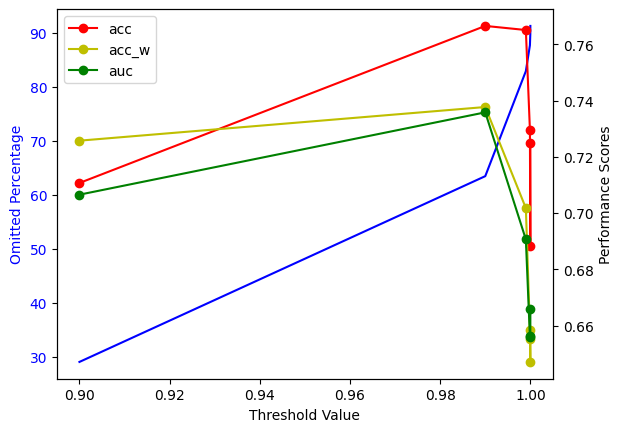

In [48]:
fig, ax1 = plt.subplots()
x_lim = a_l
ax1.plot(x_lim, o_p_tl, 'b-')
ax1.set_xlabel('Threshold Value')
ax1.set_ylabel('Omitted Percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(x_lim, acc_tl, 'ro-', label='acc')
ax2.plot(x_lim, acc_w_tl, 'yo-', label='acc_w')
ax2.plot(x_lim, auc_tl, 'go-', label='auc')
ax2.legend()
ax2.set_ylabel('Performance Scores',color='k')
ax2.tick_params(axis='y',labelcolor='k')

In [53]:
# Focus on thres lower than 0.999

acc_tl = []
acc_w_tl = []
auc_tl = []
o_p_tl = []
o_p_all = 0
a_l = []
a = 0.900
n = 1
while a < 0.999:
  a = a + 0.001
  a_l.append(a)
  print(f"Threshold setting {n}: {a}")
  thres = np.log(a)
  acc_scores = []
  yhat_all = []
  ytrue_all = []
  o_p_l = []
  for i in range(len(testlist)):
    print(f"Fold {i}; ")
    paras = converted_paras_l[i]
    #1 Build training, validation and test sets/Extract individual index list
    train_v_indexes = trainlist[i]
    val_indexes = vlist[i]
    test_indexes = testlist[i]
    X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
    X_test, y_test= X[test_indexes], Y[test_indexes]
    print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
        f"testing index: {len(test_indexes)}") #{test_indexes},

    #2 Use train and validation indexes to create the custom split
    # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
    custom_split = [-1] * len(train_v_indexes)
    for i, x in enumerate(train_v_indexes):
      if x in val_indexes: custom_split[i] = 0
    # Initialize the PredefinedSplit object
    ps = PredefinedSplit(test_fold=custom_split)

    #3 Create model and optimise by BayesSearch
    model = GaussianNB(**paras)
    model.fit(X_train, y_train)
    yhat = model.predict_log_proba(X_test)

    #6 Calculate and store
    acc, o_p = prob_acc(y_test, yhat, thres)
    # auc = roc_auc_score(y_test, yhat)
    acc_scores.append(acc)
    o_p_l.append(o_p)
    ytrue_all.append(y_test)
    yhat_all.append(yhat)
    # auc_scores.append(auc)
    print("Iteration Accuray: {:.2f}%".format(100*acc))
    # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))

  """Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
  #7 Results for all testing folds
  n+=1
  # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
  ytrue_all = np.concatenate(ytrue_all)
  yhat_all= np.concatenate(yhat_all)
  acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
  auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
  # Filter acc_scores
  nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
  acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
  #
  acc_ave = np.mean(acc_scores)
  acc_w_tl.append(acc_w)
  acc_tl.append(acc_ave)
  auc_tl.append(auc)
  o_p_tl.append(o_p_all)
  print("Average Accuray: {:.2f}%".format(100*acc_ave))
  print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
      {:.2f}%".format(acc_w * 100, o_p_all))
  print("Whole AUC: {:.4f}%".format(auc))

Threshold setting 1: 0.901
Fold 0; 
training+validation index: 306;  testing index: 28
Iteration Accuray: 71.43%
Fold 1; 
training+validation index: 292;  testing index: 42
Iteration Accuray: 78.79%
Fold 2; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 94.44%
Fold 3; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 80.95%
Fold 4; 
training+validation index: 247;  testing index: 87
Iteration Accuray: 72.55%
Fold 5; 
training+validation index: 314;  testing index: 20
Iteration Accuray: 30.77%
Fold 6; 
training+validation index: 300;  testing index: 34
Iteration Accuray: 68.00%
Fold 7; 
training+validation index: 304;  testing index: 30
Iteration Accuray: 62.07%
Fold 8; 
training+validation index: 299;  testing index: 35
Iteration Accuray: 80.00%
Average Accuray: 71.00%
Whole Accuracy: 72.46%, Percentage of Data Omitted:       29.34%
Whole AUC: 0.7060%
Threshold setting 2: 0.902
Fold 0; 
training+validation index: 306;  testing index: 28
Iter

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


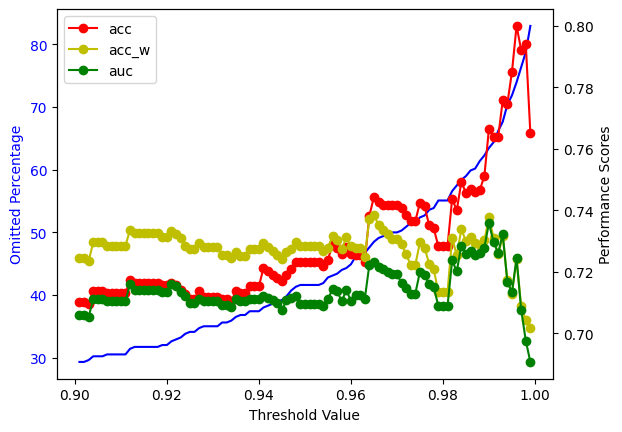

In [54]:
fig, ax1 = plt.subplots()
x_lim = a_l
ax1.plot(x_lim, o_p_tl, 'b-')
ax1.set_xlabel('Threshold Value')
ax1.set_ylabel('Omitted Percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(x_lim, acc_tl, 'ro-', label='acc')
ax2.plot(x_lim, acc_w_tl, 'yo-', label='acc_w')
ax2.plot(x_lim, auc_tl, 'go-', label='auc')
ax2.legend()
ax2.set_ylabel('Performance Scores',color='k')
ax2.tick_params(axis='y',labelcolor='k')

#### GB Thresholding

##### Load predictions/best parameters

In [ ]:
import csv
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [element for element in row]
            data.append(row_data)
    return data
path = f"{base}gb1_odata_pop/best_params_list_1.csv"
paras_l = read_csv(path)
paras_l = paras_l[0]
import ast
def convert_to_dict(entry):
    ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
    ordered_dict = ast.literal_eval(ordered_dict_str)
    return dict(ordered_dict)
converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
converted_paras_l

[{'ccp_alpha': 0.013155077555920025,
  'learning_rate': 0.11175703942290195,
  'max_depth': 9,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 5,
  'n_estimators': 885,
  'subsample': 1.0},
 {'ccp_alpha': 0.0,
  'learning_rate': 0.01,
  'max_depth': 1,
  'min_impurity_decrease': 1.0,
  'min_samples_leaf': 10,
  'n_estimators': 50,
  'subsample': 0.4856101034882243},
 {'ccp_alpha': 0.0,
  'learning_rate': 0.01,
  'max_depth': 1,
  'min_impurity_decrease': 1.0,
  'min_samples_leaf': 20,
  'n_estimators': 1000,
  'subsample': 1.0},
 {'ccp_alpha': 0.0,
  'learning_rate': 0.025425381947906216,
  'max_depth': 1,
  'min_impurity_decrease': 1.0,
  'min_samples_leaf': 1,
  'n_estimators': 50,
  'subsample': 1.0},
 {'ccp_alpha': 1.0,
  'learning_rate': 1.0,
  'max_depth': 8,
  'min_impurity_decrease': 1.0,
  'min_samples_leaf': 5,
  'n_estimators': 100,
  'subsample': 0.32928912027753043},
 {'ccp_alpha': 0.05221174641019,
  'learning_rate': 1.0,
  'max_depth': 10,
  'min_impurity_decrease'

##### Model Initiliazation

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from skopt.space import Real, Categorical, Integer
# reg = GradientBoostingClassifier(random_state=0)
# Define XGBoost model hyperparameters grid
def create_gb_model(learning_rate, max_depth, n_estimators, min_samples_leaf,
                    subsample,min_impurity_decrease, ccp_alpha):
    model = GradientBoostingClassifier(
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        n_estimators=int(n_estimators),
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        min_impurity_decrease=min_impurity_decrease,
        #gamma=gamma,
        #alpha
        ccp_alpha=ccp_alpha,
        random_state=42
    )
    return model

##### Test with different thres

In [ ]:
def convert(pred_probs, thres):
    converted_preds = np.empty(len(pred_probs), dtype=object)
    # print(pred_probs)
    for i in range(len(pred_probs)):
        # print(pred_probs[i])
        prob_class_0 = pred_probs[i][0]
        prob_class_1 = pred_probs[i][1]
        if prob_class_0 > thres:
            converted_preds[i] = 0
        elif prob_class_1 > thres:
            converted_preds[i] = 1
        else:
            converted_preds[i] = np.nan
    return converted_preds

def prob_acc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    # print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    # print(len(valid_y_test))
    accuracy = accuracy_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

def prob_auc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    print(len(valid_y_test))
    accuracy = roc_auc_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

acc_tl = []
acc_w_tl = []
auc_tl = []
o_p_tl = []
o_p_all = 0
thres = 0.51
while o_p_all < 90:
  print(thres)
  acc_scores = []
  n = 1
  yhat_all = []
  ytrue_all = []
  # o_p_l = []
  for i in range(len(testlist)):
    print(f"Fold {i}; ")
    paras = converted_paras_l[i]
    #1 Build training, validation and test sets/Extract individual index list
    train_v_indexes = trainlist[i]
    val_indexes = vlist[i]
    test_indexes = testlist[i]
    X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
    X_test, y_test= X[test_indexes], Y[test_indexes]
    # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
    #     f"testing index: {len(test_indexes)}") #{test_indexes},

    #2 Use train and validation indexes to create the custom split
    # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
    custom_split = [-1] * len(train_v_indexes)
    for j, x in enumerate(train_v_indexes):
      if x in val_indexes: custom_split[j] = 0
    # Initialize the PredefinedSplit object
    ps = PredefinedSplit(test_fold=custom_split)

    #3 Create model with paras found by former BayesSearch
    model = create_gb_model(**paras)
    model.fit(X_train, y_train)
    yhat = model.predict_proba(X_test)

    #6 Calculate and store
    acc, o_p = prob_acc(y_test, yhat, thres)
    # auc = roc_auc_score(y_test, yhat)
    acc_scores.append(acc)
    o_p_l.append(o_p)
    ytrue_all.append(y_test)
    yhat_all.append(yhat)
    # auc_scores.append(auc)
    # print("Iteration Accuray: {:.2f}%".format(100*acc))
    # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
    n+=1
  # a+=0.001
  thres+=0.01
  #For one thres
  #7 Results for all testing folds
  # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
  ytrue_all = np.concatenate(ytrue_all)
  yhat_all= np.concatenate(yhat_all)
  acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
  auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
  # Filter nan in acc
  nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
  acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
  #
  acc_ave = np.mean(acc_scores)
  acc_w_tl.append(acc_w)
  acc_tl.append(acc_ave)
  auc_tl.append(auc)
  o_p_tl.append(o_p_all)
  print("Average Accuray: {:.2f}%".format(100*acc_ave))
  print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
      {:.2f}%".format(acc_w * 100, o_p_all))
  print("Whole AUC: {:.4f}%".format(auc))

0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
229
229
Average Accuray: 70.29%
Whole Accuracy: 70.74%, Percentage of Data Omitted:       31.44%
Whole AUC: 0.6934%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
218
218
Average Accuray: 70.91%
Whole Accuracy: 71.56%, Percentage of Data Omitted:       34.73%
Whole AUC: 0.7004%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
213
213
Average Accuray: 71.88%
Whole Accuracy: 71.83%, Percentage of Data Omitted:       36.23%
Whole AUC: 0.7000%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
209
209
Average Accuray: 72.30%
Whole Accuracy: 71.77%, Percentage of Data Omitted:       37.43%
Whole AUC: 0.6976%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
202
202
Average Accuray: 72.51%
Whole Accuracy: 71.29%, Percentage of Data Omitted:       39.52%
Whole AUC: 0.6947%
0.56
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
200
200
Average Accuray: 72.27%
Whole Accuracy: 71.50%, Percentage of Data Omitted:       40.12%
Whole AUC: 0.6972%
0.5700000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
193
193
Average Accuray: 72.26%
Whole Accuracy: 70.47%, Percentage of Data Omitted:       42.22%
Whole AUC: 0.6843%
0.5800000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
184
184
Average Accuray: 71.24%
Whole Accuracy: 71.20%, Percentage of Data Omitted:       44.91%
Whole AUC: 0.6923%
0.5900000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
170
170
Average Accuray: 72.64%
Whole Accuracy: 70.59%, Percentage of Data Omitted:       49.10%
Whole AUC: 0.6916%
0.6000000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
154
154
Average Accuray: 72.82%
Whole Accuracy: 71.43%, Percentage of Data Omitted:       53.89%
Whole AUC: 0.7042%
0.6100000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
133
133
Average Accuray: 73.48%
Whole Accuracy: 70.68%, Percentage of Data Omitted:       60.18%
Whole AUC: 0.7041%
0.6200000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
123
123
Average Accuray: 71.33%
Whole Accuracy: 71.54%, Percentage of Data Omitted:       63.17%
Whole AUC: 0.7122%
0.6300000000000001
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
120
120
Average Accuray: 74.90%
Whole Accuracy: 70.83%, Percentage of Data Omitted:       64.07%
Whole AUC: 0.7042%
0.6400000000000001
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
114
114
Average Accuray: 74.29%
Whole Accuracy: 70.18%, Percentage of Data Omitted:       65.87%
Whole AUC: 0.6994%
0.6500000000000001
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
112
112
Average Accuray: 74.56%
Whole Accuracy: 69.64%, Percentage of Data Omitted:       66.47%
Whole AUC: 0.6927%
0.6600000000000001
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
106
106
Average Accuray: 73.06%
Whole Accuracy: 69.81%, Percentage of Data Omitted:       68.26%
Whole AUC: 0.6978%
0.6700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
103
103
Average Accuray: 73.10%
Whole Accuracy: 68.93%, Percentage of Data Omitted:       69.16%
Whole AUC: 0.6884%
0.6800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
100
100
Average Accuray: 72.75%
Whole Accuracy: 69.00%, Percentage of Data Omitted:       70.06%
Whole AUC: 0.6909%
0.6900000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
94
94
Average Accuray: 72.94%
Whole Accuracy: 69.15%, Percentage of Data Omitted:       71.86%
Whole AUC: 0.6933%
0.7000000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
69
69
Average Accuray: 74.10%
Whole Accuracy: 63.77%, Percentage of Data Omitted:       79.34%
Whole AUC: 0.6235%
0.7100000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
66
66
Average Accuray: 71.00%
Whole Accuracy: 63.64%, Percentage of Data Omitted:       80.24%
Whole AUC: 0.6222%
0.7200000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
46
46
Average Accuray: 70.81%
Whole Accuracy: 67.39%, Percentage of Data Omitted:       86.23%
Whole AUC: 0.6598%
0.7300000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


45
45
Average Accuray: 76.01%
Whole Accuracy: 66.67%, Percentage of Data Omitted:       86.53%
Whole AUC: 0.6549%
0.7400000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


41
41
Average Accuray: 75.31%
Whole Accuracy: 65.85%, Percentage of Data Omitted:       87.72%
Whole AUC: 0.6412%
0.7500000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


39
39
Average Accuray: 68.89%
Whole Accuracy: 66.67%, Percentage of Data Omitted:       88.32%
Whole AUC: 0.6508%
0.7600000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


35
35
Average Accuray: 69.05%
Whole Accuracy: 68.57%, Percentage of Data Omitted:       89.52%
Whole AUC: 0.6548%
0.7700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
31
31
Average Accuray: 69.55%
Whole Accuracy: 67.74%, Percentage of Data Omitted:       90.72%
Whole AUC: 0.6068%


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


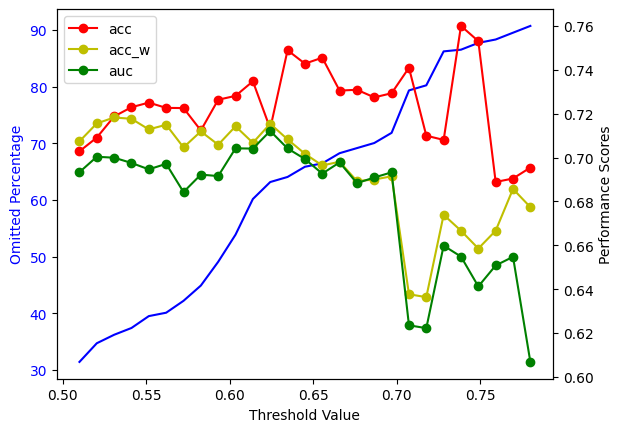

In [ ]:
fig, ax1 = plt.subplots()
x_lim = np.linspace(0.51,thres,(len(o_p_tl)))
ax1.plot(x_lim, o_p_tl, 'b-')
ax1.set_xlabel('Threshold Value')
ax1.set_ylabel('Omitted Percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(x_lim, acc_tl, 'ro-', label='acc')
ax2.plot(x_lim, acc_w_tl, 'yo-', label='acc_w')
ax2.plot(x_lim, auc_tl, 'go-', label='auc')
ax2.legend()
ax2.set_ylabel('Performance Scores',color='k')
ax2.tick_params(axis='y',labelcolor='k')

# ax4.set_ylabel('Running time (seconds)',color='r')
# ax4.tick_params(axis='y',labelcolor='r')

Conclusion: similarly...

### Bar chart

<class 'numpy.ndarray'>


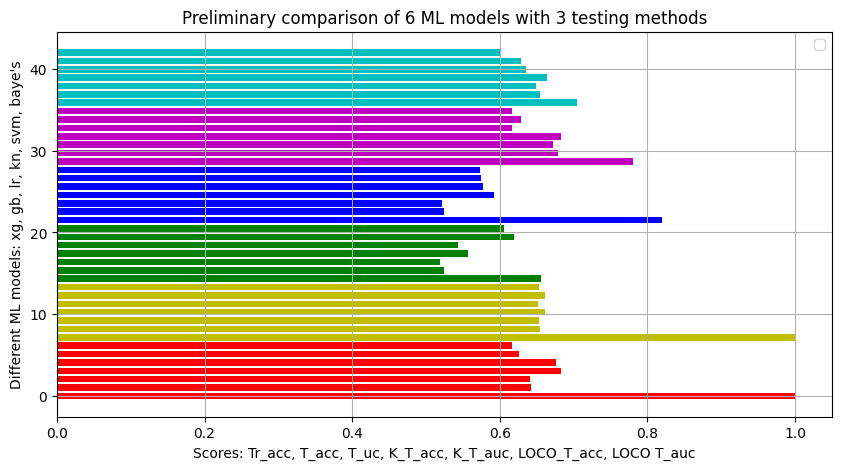

In [ ]:
## Display all results from different classifiers in one chart.
data = np.array([acc_xg_tr, acc_xg_v, auc_xg_v, acc_xg_k, auc_xg_k, acc_xg_lolo, auc_xg_lolo,
           acc_gb_tr, acc_gb, auc_gb, acc_gb_k, auc_gb_k, acc_gb_lolo, auc_gb_lolo,
            acc_lr_tr, acc_lr_v, auc_lr_v, acc_lr_k, auc_lr_k, acc_lr_lolo, auc_lr_lolo,
             acc_kn_tr, acc_kn, auc_kn, acc_kn_k, auc_kn_k, acc_kn_lolo, auc_kn_lolo,
              acc_svm_tr, acc_svm_v, auc_svm_v, acc_svm_k, auc_svm_lolo, acc_svm_lolo, auc_svm_lolo,
               acc_b_tr, acc_b, auc_b, acc_b_k, auc_b_k, acc_b_lolo, auc_b_lolo,]).reshape(-1, 1)
print(type(data))
plt.figure(figsize=(10,5))

# Define the labels for the data
#labels = ['1', '2', '3', '4', '5', '6', '7']
labels = np.linspace(0, 6*7, num=6*7)
# Plot the data as a bar chart and assign the labels to the bars
colors = ['r','r','r','r','r','r','r',
       'y','y','y','y','y','y','y',
        'g','g','g','g','g','g','g',
         'b','b','b','b','b','b','b',
          'm','m','m','m','m','m','m',
          'c','c','c','c','c','c','c']
for i in range(len(data)):
  plt.barh(labels[i], data[i], color=colors[i])#label=names[i],
# Add a legend to the plot
plt.legend()
# Set the x-axis ticks and labels

# Set the y-axis label
#plt.ylim(0.212,0.218)
plt.xlabel('Scores: Tr_acc, T_acc, T_uc, K_T_acc, K_T_auc, LOCO_T_acc, LOCO T_auc')#,size=16
plt.ylabel('Different ML models: xg, gb, lr, kn, svm, baye\'s')#,size=16
plt.title("Preliminary comparison of 6 ML models with 3 testing methods")#(Scores:Tr_acc, T_acc, T_auc, K_T_acc, K_T_auc, LOCO_T_acc, LOCO T_auc;\n Different ML models: xg, lr, kn, svm, baye\'s)
#plt.xticks()
#plt.yticks()
plt.grid()

# Show the plot
plt.show()

##** Achieved parts
The later sections are trials runs for XGBoost hyperparameter tuning and leave-one-sample out testing

In [ ]:
# Tuning the model with testing method 1:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
#from sklearn.model_selection import GridSearchCV
param_grid = {'gamma': [0.1,0.4,0.8,1.6,6.4],
        'min_child_weight': [1,100,150,200],
        'subsample': [0.4,0.6,0.8,1],
        'reg_lambda': [0,0.4,1.6,6.4],
        #'eta': [0.1,0.2,0.3,0.4], #default: 0.3
        #'sampling_method': ['uniform', 'gradient_based'],
        'grow_policy' : ['depthwise','lossguide'],
        }
search = HalvingGridSearchCV(classifier, param_grid, scoring = 'accuracy',
                      resource='n_estimators',
                      max_resources=1000,
                      cv = 4)#delete pds to gain more reliable results
search.fit(X_train,y_train)
print("Best Parameters:",search.best_params_)
print("Training Score:",search.best_score_)

In [ ]:
print("Test Score:",search.score(X_test,y_test)) #Increase significantly (orginal: 62.35%)

In [ ]:
search.cv_results_

In [ ]:
new_classifier = XGBClassifier(objective='binary:logistic',tree_method='gpu_hist')
#params = {'gamma': 6.4, 'grow_policy': 'depthwise', 'n_estimators': 50, 'reg_alpha': 0.4, 'reg_lambda': 1.6, 'sampling_method': 'uniform'}
new_classifier.set_params(**search.best_params_)
new_classifier.fit(X_train, y_train)
print("Training Accuray: {:.2f}%".format(100*new_classifier.score(X_train, y_train)))
print("Model Accuray: {:.2f}%".format(100*new_classifier.score(X_test, y_test)))
y_pred = new_classifier.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred)
print("Model AUC_ROC: {:.4f}".format(auc_score))

Supoport Vector Machine Idea: Lots of points get ignored in training.

###Conclusion for tuning
The results are more reliable since testing score is similar to training score.

In [ ]:
# Build training/testing sets 2
# This testing method gives better overview of the classifer
# as the early one has varied reuslts with different
# random states.
from sklearn.model_selection import LeaveOneOut
#define cross-validation method to use
cv = LeaveOneOut()
# enumerate splits
y_true, y_pred1 = list(), list()
for train_ix, test_ix in cv.split(X):
 # split data
 X_train1, X_test1 = X[train_ix, :], X[test_ix, :]
 y_train1, y_test1 = Y[train_ix], Y[test_ix]
 # fit model
 model = XGBClassifier(objective='binary:logistic')
 model.fit(X_train1, y_train1)
 # evaluate model
 yhat = model.predict(X_test1)
 # store
 y_true.append(y_test1[0])
 y_pred1.append(yhat[0])
# calculate accuracy
acc = accuracy_score(y_true, y_pred1)
auc_score = roc_auc_score(y_true, y_pred1)
print("Model Accuray: {:.2f}%".format(100*acc))
#66.17% for all features
print("Model AUC_ROC: {:.4f}".format(auc_score))
#0.65 for all features

In [ ]:
#Display results
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(model,rankdir='LR',ax=ax)

In [ ]:
# Build training/testing sets 2 - Hyperparameters Optimised
from sklearn.model_selection import LeaveOneOut
#define cross-validation method to use
cv = LeaveOneOut()
# enumerate splits
y_true, y_pred11 = list(), list()
for train_ix, test_ix in cv.split(X):
 # split data
 X_train1, X_test1 = X[train_ix, :], X[test_ix, :]
 y_train1, y_test1 = Y[train_ix], Y[test_ix]
 # fit model
 new_classifier.fit(X_train1, y_train1)
 # evaluate model
 yhat = new_classifier.predict(X_test1)
 # store
 y_true.append(y_test1[0])
 y_pred11.append(yhat[0])
# calculate accuracy
acc1 = accuracy_score(y_true, y_pred11)
auc_score1 = roc_auc_score(y_true, y_pred11)
print("Model Accuray: {:.2f}%".format(100*acc1))
#69.44%
print("Model AUC_ROC: {:.4f}".format(auc_score1))
#0.6681

#Note the running time increases to 3 min!

In [ ]:
#Display results
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(new_classifier,rankdir='LR',ax=ax)

### Conlusion for Hyperparameter Tuning:
It might be the limit training groups that causes the low accuracy result;
hence tuninig the hyperparameter doesn't help for improving the accuracy (within controlled computational cost).